In [6]:
import numpy as np
import pandas as pd
import random
import re
import scipy as sp
import seaborn as sns
import yaml
import shutil

from copy import deepcopy
from pathlib import Path
from collections import namedtuple, defaultdict
from typing import Literal

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as mticker
from matplotlib import rcParams
import matplotlib.gridspec as gridspec
import scienceplots

import sys
import os
import re

# Get the path of the parent directory and add it to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

import importlib
import assistive_arm.utils.analyze_emg_data_loading
importlib.reload(assistive_arm.utils.analyze_emg_data_loading)
import assistive_arm.utils.analyze_emg_data_processing
importlib.reload(assistive_arm.utils.analyze_emg_data_processing)
import assistive_arm.utils.analyze_emg_data_plotting
importlib.reload(assistive_arm.utils.analyze_emg_data_plotting)

from assistive_arm.utils.analyze_emg_data_loading import setup_datastructure, get_muscle_mapping, write_emg_config_yaml, load_motor_data_hilo, load_profile_data_hilo, load_mvic_data_hilo, load_raw_emg_imu_data_hilo, load_segmented_emg_data_hilo, load_log_data_hilo, load_optimizer_data_hilo
from assistive_arm.utils.analyze_emg_data_processing import *
from assistive_arm.utils.analyze_emg_data_plotting import *
from assistive_arm.utils.data_preprocessing import read_headers, smooth_dataframe
from assistive_arm.utils.emg_processing import filter_emg, interpolate_dataframe_to_length, apply_lowpass_filter, extract_time, segmentation
from assistive_arm.utils.emg_plotting import plot_every_muscle, plot_muscle_emg, plot_collected_and_calculated_imu_data
from assistive_arm.utils.optimum_length_utils import get_jacobian, get_rotation_matrix
from assistive_arm.utils.printing import print_dict_structure


np.set_printoptions(precision=3, suppress=True)

### Load Data

In [7]:
# Select subjects and sessions
select_subjects = ["subject_Validation_2"]
select_sessions = ["February_07"]
validation = True

# Setup datastructure
subject_data, subject_dirs, subjects, motor_config = setup_datastructure(selected_subjects=select_subjects, selected_sessions=select_sessions)

# Define mapping
muscle_mapping = get_muscle_mapping(subject_data[subjects[0].name][next(iter(subject_data[subjects[0].name].keys()))]["emg_config"])

# Write emg config yaml
subject_data = write_emg_config_yaml(subject_data, subject_dirs, muscle_mapping)

# Before loading data, get the file with all the iterations to be ignored
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        motor_dir = subject_dirs[subject][session]["motor_dir"]
        
        # Manually added iterations (keep as a list of strings)
        profile_to_delete = ["20250207172806", "20250207173937", "20250207180008", "20250207172007"]
        # profile_to_delete = ["20250211191827", "20250211192957", "20250211193437", "20250211194939", "20250211194947", "20250211191754", "20250211194957", "20250211195008", "20250211200949", "20250211200631"]

        subject_data[subject][session]["profile_to_delete"] = profile_to_delete

# Load motor data
subject_data, subject_dirs, subjects, data_dict = load_motor_data_hilo(subject_data, subject_dirs, subjects, validation)

# Load profiles
if not validation:
    subject_data, subject_dirs, subjects = load_profile_data_hilo(subject_data, subject_dirs, subjects)

# Load raw data, in most cases this is not needed (comment, as it takes a lot of time), except if you need to go deeper into the data
if True:
    subject_data, subject_dirs, subjects = load_raw_emg_imu_data_hilo(subject_data, subject_dirs, subjects)

# Load MVIC data
subject_data, subject_dirs, subjects = load_mvic_data_hilo(subject_data, subject_dirs, subjects)

# Load processed data
subject_data, subject_dirs, subjects = load_segmented_emg_data_hilo(subject_data, subject_dirs, subjects)

# Load log data
subject_data, subject_dirs, subjects = load_log_data_hilo(subject_data, subject_dirs, subjects)


0 ['EMG IMU,EMG OR,EMG RF_R,EMG VM_R,EMG G_R,EMG TA_R,EMG SO_R,EMG RF_L,EMG VM_L,EMG BF_L,EMG G_L,EMG TA_L,EMG SO_L']
EMG config already exists
Removing Tag 20250207172007 Motor from session February_07
Removing Tag 20250207180008 Motor from session February_07
Removing Tag 20250207173937 Motor from session February_07
Removing Profile 20250207172007 EMG from session ../subject_logs/subject_Validation_2/February_07
Removing Profile 20250207173937 EMG from session ../subject_logs/subject_Validation_2/February_07
Removing Profile 20250207180008 EMG from session ../subject_logs/subject_Validation_2/February_07


KeyError: '20250207165944'

In [23]:
# Print the whole structure
print_dict_structure(subject_data)

subject_Validation_2: <class 'dict'>
    February_07: <class 'dict'>
        emg_config: <class 'dict'>
            CHANNEL_NAMES: <class 'list'>
            EMG_FREQUENCY: <class 'float'>
            IMU_FREQUENCY: <class 'float'>
            OR_FREQUENCY: <class 'float'>
            MAPPING: <class 'dict'>
                EMG IMU: <class 'str'>
                EMG OR: <class 'str'>
                EMG RF_R: <class 'str'>
                EMG VM_R: <class 'str'>
                EMG G_R: <class 'str'>
                EMG TA_R: <class 'str'>
                EMG SO_R: <class 'str'>
                EMG RF_L: <class 'str'>
                EMG VM_L: <class 'str'>
                EMG BF_L: <class 'str'>
                EMG G_L: <class 'str'>
                EMG TA_L: <class 'str'>
                EMG SO_L: <class 'str'>
        angle_calibration: <class 'dict'>
            Percentage: <class 'list'>
            new_range: <class 'dict'>
                max: <class 'float'>
                min

### Plot MVIC data

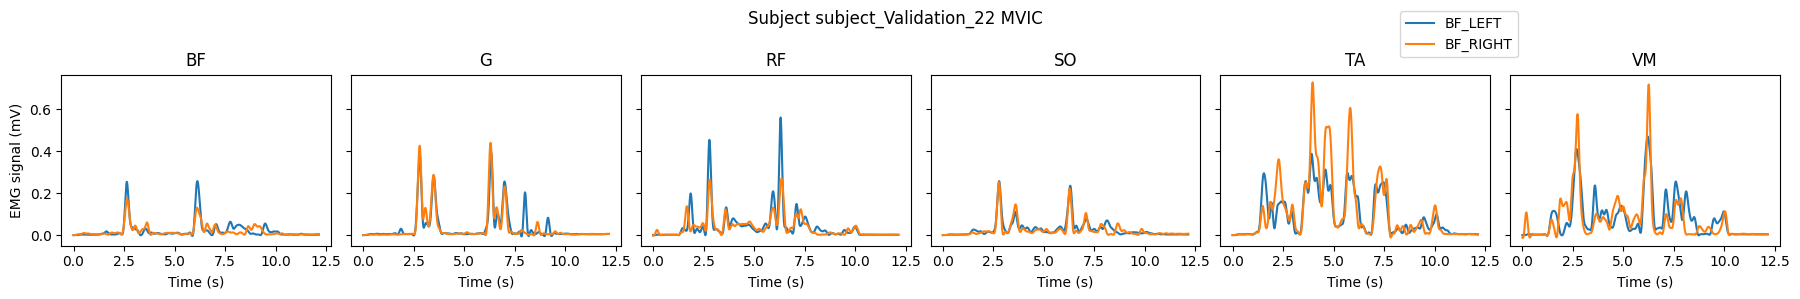

In [211]:
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        # Prepare directories
        mvic_dir = subject_dirs[subject][session]["plot_dir"] / "mvic"
        mvic_dir.mkdir(parents=True, exist_ok=True)

        # Retrieve data
        emg_config = subject_data[subject][session]["emg_config"]
        session_data = subject_data[subject][session]["session_data"]

        # Plot the data
        plot_mvic_data(subject, session_data, emg_config, mvic_dir)

        # Extract the max data and save it in a dict
        max_values = session_data["MVIC"]["Filtered"].max()

        # Replace all the LEFT with L and RIGHT with R
        max_values.index = max_values.index.str.replace("LEFT", "L").str.replace("RIGHT", "R")

        session_data["MVIC"]["MAX"] = max_values

In [225]:
# Plot mean curve over all unassisted trials, sclaed with MVIC
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        # Prepare directories
        emg_dir = subject_dirs[subject][session]["plot_dir"] / "emg"
        emg_dir.mkdir(parents=True, exist_ok=True)

        # Retrieve data
        session_data = subject_data[subject][session]["session_data"]

        max_values = session_data["MVIC"]["MAX"]

        max_values["BF_R"] = max_values["BF_L"]

        counter = 0

        all_data = None
        # Plot the data
        for first_tag in session_data["UNPOWERED"]["FIRST_TAGS"]:
            for i, emg_data in enumerate(session_data["UNPOWERED"][first_tag]["EMG"]["Filtered"]):

                counter += 1
                # Plot the selected muscle
                emg_data = detect_peak_and_crop(emg_data)

                # replace BF_R with BF_L
                emg_data["BF_R"] = emg_data["BF_L"]

                # Scale the data
                emg_data = emg_data / max_values

                if all_data is None:
                    all_data = emg_data
                else:
                    all_data += emg_data

        all_data = all_data / counter

        added_up = pd.DataFrame()
        # get mean over left and right muscles
        added_up["RF"] = (all_data[["RF_L", "RF_R"]].mean(axis=1))
        added_up["VM"] = (all_data[["VM_L", "VM_R"]].mean(axis=1))
        added_up["BF"] = (all_data[["BF_L", "BF_R"]].mean(axis=1))
        added_up["G"] = (all_data[["G_L", "G_R"]].mean(axis=1))
        added_up["TA"] = (all_data[["TA_L", "TA_R"]].mean(axis=1))
        added_up["SO"] = (all_data[["SO_L", "SO_R"]].mean(axis=1))

        sampling_frequ= float(2148.259)
        
        # Ctreate time column
        added_up["Time"] = np.arange(0, len(added_up)/sampling_frequ, 1/sampling_frequ)
        # set time as index 
        added_up = added_up.set_index("Time")

        # Create plot here
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        plt.style.use('science')
        added_up.plot(ax=ax, linewidth=2)
        ax.set_title("Mean scaled with MVIC")
        ax.set_xlabel("Time [s]")
        ax.set_ylabel("Amplitude")
        ax.legend(title="Muscle")
        plt.tight_layout()
        plt.savefig(emg_dir / "mean_curve_unassisted_trials.png", dpi=500)
        plt.close()

        

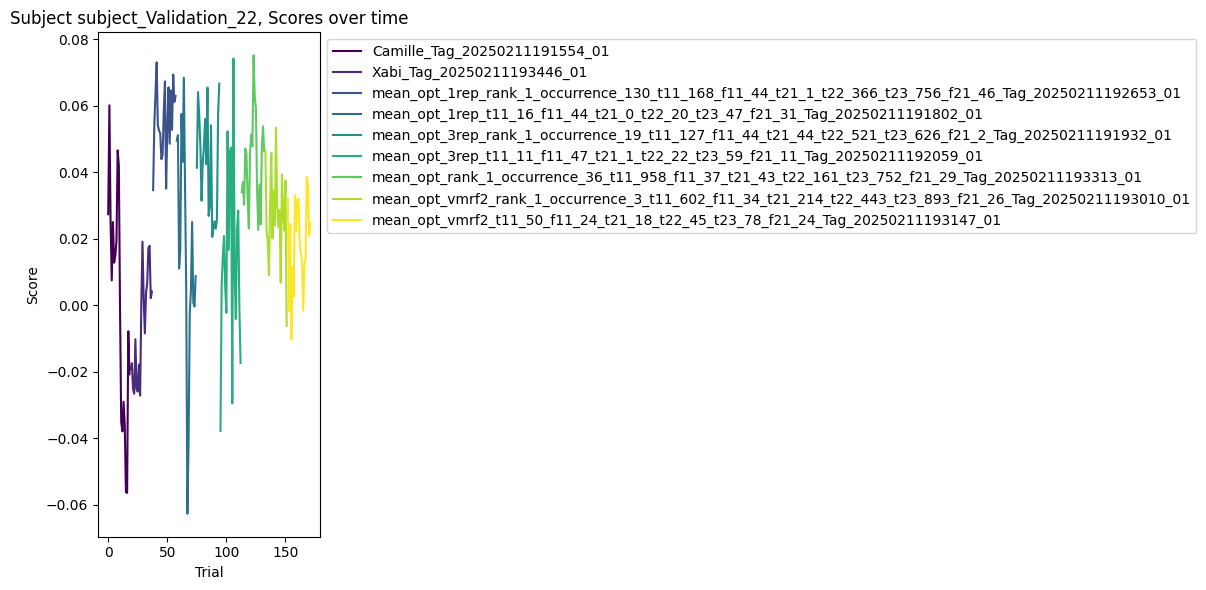

In [203]:
# Plot all scores

for subject in subjects:
    for session in iter(subject_data[subject.name].keys()):
        # Prepare directories
        scores_dir = subject_dirs[subject.name][session]["plot_dir"] / "scores"
        scores_dir.mkdir(parents=True, exist_ok=True)

        # Extract data
        session_data = subject_data[subject.name][session]["session_data"].copy()
        name_tag_mapping = subject_data[subject.name][session]["name_tag_mapping"]

        # Call the plotting function
        plot_scores(subject.name, session_data, name_tag_mapping, scores_dir)



In [142]:
# Plot all for certain muscle
muscle = "VM"
muscle1 = "VM_L"
muscle2 = "VM_R"

for subject in subjects:
    for session in iter(subject_data[subject.name].keys()):
        all_emg_dir = subject_dirs[subject.name][session]["plot_dir"] / "all_emg"
        all_emg_dir.mkdir(parents=True, exist_ok=True)

        session_data = subject_data[subject.name][session]["session_data"].copy()


        for first_tag in session_data["ASSISTED"]["FIRST_TAGS"]:
            for i, emg_data in enumerate(session_data["ASSISTED"][first_tag]["EMG"]["Filtered"]):
                # Plot the selected muscle
                emg_data = detect_peak_and_crop(emg_data)

                # Extract EMG data for the selected muscle
                emg_signal1 = emg_data[muscle1]
                emg_signal2 = emg_data[muscle2]

                # Crop the signal
                # crop_size = int(0.25 * 2148.148)  # Convert to integer
                # emg_signal1 = emg_signal1.iloc[crop_size:-crop_size]
                # emg_signal2 = emg_signal2.iloc[crop_size:-crop_size]
                
                time_vector = range(len(emg_signal1))

                # Plot the EMG signal
                plt.figure(figsize=(12, 6))
                plt.plot(time_vector, emg_signal1, label=muscle1, color="blue", linewidth=1.5)
                plt.plot(time_vector, emg_signal2, label=muscle2, color="purple", linewidth=1.5)
                plt.title(f"{muscle} EMG Data: Subject {subject.name}, Session {session}, Tag {session_data['ASSISTED'][first_tag]['PROFILE_TAGS'][i]}")
                plt.xlabel("Samples")
                plt.ylabel("Filtered EMG Signal")
                plt.grid(linestyle="--", alpha=0.6)
                plt.legend()

                
                # Save the plot
                save_path = all_emg_dir / f"{subject.name}_{session}_{session_data['ASSISTED'][first_tag]['PROFILE_TAGS'][i]}_{muscle}_emg.png"
                plt.savefig(save_path, dpi=300, bbox_inches="tight", format="png")
                plt.close()

In [ ]:
# Plot all muscles scaled by mvic
for subject in subjects:
    for session in iter(subject_data[subject.name].keys()):
        all_emg_dir = subject_dirs[subject.name][session]["plot_dir"] / "all_emg_all_muscles"
        all_emg_dir.mkdir(parents=True, exist_ok=True)

        session_data = subject_data[subject.name][session]["session_data"].copy()


        for first_tag in session_data["ASSISTED"]["FIRST_TAGS"]:
            for i, emg_data in enumerate(session_data["ASSISTED"][first_tag]["EMG"]["Filtered"]):
                # Plot the selected muscle
                emg_data = detect_peak_and_crop(emg_data)

                time_vector = range(len(emg_data))

                # Plot the EMG signal
                plt.figure(figsize=(12, 6))

                for muscle in emg_data.columns:
                    emg_signal = emg_data[muscle]
                    emg_signal = emg_signal / session_data["MVIC"]["MAX"][muscle]
                    plt.plot(time_vector, emg_signal, label=muscle, linewidth=1.5)
                plt.title(f"{muscle} EMG Data: Subject {subject.name}, Session {session}, Tag {session_data['ASSISTED'][first_tag]['PROFILE_TAGS'][i]}")
                plt.xlabel("Samples")
                plt.ylabel("Filtered EMG Signal")
                plt.grid(linestyle="--", alpha=0.6)
                plt.legend()

                
                # Save the plot
                save_path = all_emg_dir / f"{subject.name}_{session}_{session_data['ASSISTED'][first_tag]['PROFILE_TAGS'][i]}_{all}_emg.png"
                plt.savefig(save_path, dpi=300, bbox_inches="tight", format="png")
                plt.close()

In [213]:
# Plot mean curves

for subject in subjects:
    for session in iter(subject_data[subject.name].keys()):

        mean_dir = subject_dirs[subject.name][session]["plot_dir"] / "mean_curves"
        mean_dir.mkdir(parents=True, exist_ok=True)

        session_data = subject_data[subject.name][session]["session_data"]
        name_tag_mapping = subject_data[subject.name][session]["name_tag_mapping"]

        emg_frequency = subject_data[subject.name][session]["emg_config"]["EMG_FREQUENCY"]

        process_emg_data(session_data, "ASSISTED")
        process_emg_data(session_data, "UNPOWERED")

        unpowered_means = []
        for tag in session_data["UNPOWERED"]["FIRST_TAGS"]:
            unpowered_means.append(session_data["UNPOWERED"][tag]["EMG"]["Mean"])

        # Plot mean curves of assisted and unassisted
        # plot_means(session_data["ASSISTED"]["Overall_Mean"], unpowered_means, mean_dir)

        plot_means_MVIC(session_data["ASSISTED"]["Overall_Mean"], unpowered_means, mean_dir, session_data["MVIC"]["MAX"])

        # plot means of assisted and unsassisted and each condition
        # plot_tag_means_with_individuals(session_data, session_data["ASSISTED"]["Overall_Mean"], unpowered_means, name_tag_mapping, mean_dir)

        # same as above but added force profile
        # plot_emg_and_force_profiles_with_means(session_data, name_tag_mapping, session_data["ASSISTED"]["Overall_Mean"], unpowered_means, mean_dir, emg_frequency)




In [209]:
# Plot the deltas (assisted-unassisted)/unassisted

# Define muscles and assign colors
muscles = ["VM", "RF", "BF", "SO", "TA", "G", "ALL"]
muscle_colors = {
    "VM": "blue",
    "RF": "green",
    "BF": "red",
    "SO": "purple",
    "TA": "orange",
    "G": "brown",
    "ALL": "black",
}

for subject in subjects:
    for session in iter(subject_data[subject.name].keys()):

        delta_dir = subject_dirs[subject.name][session]["plot_dir"] / "deltas"
        delta_dir.mkdir(parents=True, exist_ok=True)

        session_data = subject_data[subject.name][session]["session_data"]
        name_tag_mapping = subject_data[subject.name][session]["name_tag_mapping"]

        # Extract left and right muscle names
        muscle_names = [f"{m}_L" for m in muscles] + [f"{m}_R" for m in muscles]

        # Compute mean of unassisted trials
        num_unpowered = len(session_data["UNPOWERED"]["FIRST_TAGS"])
        unpowered_mean = np.zeros(len(muscle_names)-2)
        mean_unpowered_peak = np.zeros(len(muscle_names)-2)

        for tag in session_data["UNPOWERED"]["FIRST_TAGS"]:
            current_unpowered_mean = np.mean(session_data["UNPOWERED"][tag]["EMG"]["Mean"], axis=0)
            unpowered_mean += current_unpowered_mean
            mean_unpowered_peak += session_data["UNPOWERED"][tag]["EMG"]["Peak"]

        unpowered_mean /= num_unpowered  # Take mean across unpowered trials
        mean_unpowered_peak /= num_unpowered

        for tag in session_data["ASSISTED"]["FIRST_TAGS"]:
            profile_name = name_tag_mapping[tag]
            profile_mean = np.mean(session_data["ASSISTED"][tag]["EMG"]["Mean"], axis=0)
            profile_peak = session_data["ASSISTED"][tag]["EMG"]["Peak"]


            # replace BF_L with BF_R
            profile_mean["BF_R"] = profile_mean["BF_L"]
            profile_peak["BF_R"] = profile_peak["BF_L"]

            mean_delta = -(unpowered_mean - profile_mean) / unpowered_mean
            peak_delta = -(mean_unpowered_peak - profile_peak) / mean_unpowered_peak

            mean_delta["ALL"] = np.mean(mean_delta)
            peak_delta["ALL"] = np.mean(peak_delta)

            x = np.arange(len(muscles))  # Positions for muscle groups
            width = 0.4  

            fig, axs = plt.subplots(2, 1, figsize=(10, 8))

            # Mean Delta subplot
            for i, muscle in enumerate(muscles):
                # if muscle == "BF": 
                #     bar_L = axs[0].bar(x[i] - width / 2, mean_delta[f"{muscle}_L"], width, color=muscle_colors[muscle], label=f"{muscle}_L" if i == 0 else "")
                #     bars = [bar_L]
                if muscle == "ALL":
                    bar = axs[0].bar(x[i] - width / 2, mean_delta[f"{muscle}"], width, color=muscle_colors[muscle], label=f"{muscle}" if i == 0 else "")
                    bars = [bar]
                else:
                    bar_L = axs[0].bar(x[i] - width / 2, mean_delta[f"{muscle}_L"], width, color=muscle_colors[muscle], label=f"{muscle}_L" if i == 0 else "")
                    bar_R = axs[0].bar(x[i] + width / 2, mean_delta[f"{muscle}_R"], width, color=muscle_colors[muscle], alpha=0.6, label=f"{muscle}_R" if i == 0 else "")
                    bars = [bar_L, bar_R]

                # Add text labels above or below bars
                for bar_group in bars:
                    for bar in bar_group:
                        height = bar.get_height()
                        axs[0].text(
                            bar.get_x() + bar.get_width() / 2,
                            height + 0.02 if height > 0 else height - 0.02,
                            f"{height:.2f}",
                            ha="center",
                            va="bottom" if height > 0 else "top",
                            fontsize=8
                        )

            axs[0].axhline(0, color="black", linestyle="dashed", linewidth=1)
            axs[0].set_ylim(-0.5, 0.5)
            axs[0].set_ylabel("Mean EMG Reduction (%)")
            axs[0].set_title(f"Mean EMG Reduction for {tag}")
            axs[0].set_xticks(x)
            axs[0].set_xticklabels(muscles)
            # axs[0].legend()
            

            # Peak Delta subplot
            for i, muscle in enumerate(muscles):
                # if muscle == "BF":
                #     bar_L = axs[1].bar(x[i] - width / 2, peak_delta[f"{muscle}_L"], width, color=muscle_colors[muscle], label=f"{muscle}_L" if i == 0 else "")
                #     bars = [bar_L]
                if muscle == "ALL":
                    bar = axs[1].bar(x[i] - width / 2, peak_delta[f"{muscle}"], width, color=muscle_colors[muscle], label=f"{muscle}" if i == 0 else "")
                    bars = [bar]
                else:
                    bar_L = axs[1].bar(x[i] - width / 2, peak_delta[f"{muscle}_L"], width, color=muscle_colors[muscle], label=f"{muscle}_L" if i == 0 else "")
                    bar_R = axs[1].bar(x[i] + width / 2, peak_delta[f"{muscle}_R"], width, color=muscle_colors[muscle], alpha=0.6, label=f"{muscle}_R" if i == 0 else "")
                    bars = [bar_L, bar_R]

                # Add text labels above or below bars
                for bar_group in bars:
                    for bar in bar_group:
                        height = bar.get_height()
                        axs[1].text(
                            bar.get_x() + bar.get_width() / 2,
                            height + 0.02 if height > 0 else height - 0.02,
                            f"{height:.2f}",
                            ha="center",
                            va="bottom" if height > 0 else "top",
                            fontsize=8
                        )
            axs[1].axhline(0, color="black", linestyle="dashed", linewidth=1)
            axs[1].set_ylim(-0.5, 0.5)
            axs[1].set_ylabel("Peak EMG Reduction (%)")
            axs[1].set_title(f"Peak EMG Reduction for {tag}")
            axs[1].set_xticks(x)
            axs[1].set_xticklabels(muscles)
            # axs[1].legend()


            plt.tight_layout()
            plt.savefig(delta_dir / f"emg_deltas_{profile_name}.png")
            plt.close()


In [ ]:
# Plot the deltas (assisted-unassisted)/MVIC

# Define muscles and assign colors
muscles = ["VM", "RF", "BF", "SO", "TA", "G", "ALL"]
muscle_colors = {
    "VM": "blue",
    "RF": "green",
    "BF": "red",
    "SO": "purple",
    "TA": "orange",
    "G": "brown",
    "ALL": "black",
}

for subject in subjects:
    for session in iter(subject_data[subject.name].keys()):
        max_values = subject_data[subject.name][session]["session_data"]["MVIC"]["MAX"]

        delta_dir = subject_dirs[subject.name][session]["plot_dir"] / "deltas_MVIC"
        delta_dir.mkdir(parents=True, exist_ok=True)

        session_data = subject_data[subject.name][session]["session_data"]
        name_tag_mapping = subject_data[subject.name][session]["name_tag_mapping"]

        # Extract left and right muscle names
        muscle_names = [f"{m}_L" for m in muscles] + [f"{m}_R" for m in muscles]

        # Compute mean of unassisted trials
        num_unpowered = len(session_data["UNPOWERED"]["FIRST_TAGS"])
        unpowered_mean = np.zeros(len(muscle_names)-2)
        mean_unpowered_peak = np.zeros(len(muscle_names)-2)

        for tag in session_data["UNPOWERED"]["FIRST_TAGS"]:
            current_unpowered_mean = np.mean(session_data["UNPOWERED"][tag]["EMG"]["Mean"], axis=0)
            unpowered_mean += current_unpowered_mean
            mean_unpowered_peak += session_data["UNPOWERED"][tag]["EMG"]["Peak"]

        unpowered_mean /= num_unpowered  # Take mean across unpowered trials
        mean_unpowered_peak /= num_unpowered

        for tag in session_data["ASSISTED"]["FIRST_TAGS"]:
            profile_name = name_tag_mapping[tag]
            profile_mean = np.mean(session_data["ASSISTED"][tag]["EMG"]["Mean"], axis=0)
            profile_peak = session_data["ASSISTED"][tag]["EMG"]["Peak"]

            mean_delta = -(unpowered_mean - profile_mean) / max_values
            peak_delta = -(mean_unpowered_peak - profile_peak) / max_values

            mean_delta["ALL"] = np.mean(mean_delta)
            peak_delta["ALL"] = np.mean(peak_delta)

            x = np.arange(len(muscles))  # Positions for muscle groups
            width = 0.4  

            fig, axs = plt.subplots(2, 1, figsize=(10, 8))

            # Mean Delta subplot
            for i, muscle in enumerate(muscles):
                # if muscle == "BF": 
                #     bar_L = axs[0].bar(x[i] - width / 2, mean_delta[f"{muscle}_L"], width, color=muscle_colors[muscle], label=f"{muscle}_L" if i == 0 else "")
                #     bars = [bar_L]
                if muscle == "ALL":
                    bar = axs[0].bar(x[i] - width / 2, mean_delta[f"{muscle}"], width, color=muscle_colors[muscle], label=f"{muscle}" if i == 0 else "")
                    bars = [bar]
                else:
                    bar_L = axs[0].bar(x[i] - width / 2, mean_delta[f"{muscle}_L"], width, color=muscle_colors[muscle], label=f"{muscle}_L" if i == 0 else "")
                    bar_R = axs[0].bar(x[i] + width / 2, mean_delta[f"{muscle}_R"], width, color=muscle_colors[muscle], alpha=0.6, label=f"{muscle}_R" if i == 0 else "")
                    bars = [bar_L, bar_R]

                # Add text labels above or below bars
                for bar_group in bars:
                    for bar in bar_group:
                        height = bar.get_height()
                        axs[0].text(
                            bar.get_x() + bar.get_width() / 2,
                            height + 0.02 if height > 0 else height - 0.02,
                            f"{height:.2f}",
                            ha="center",
                            va="bottom" if height > 0 else "top",
                            fontsize=8
                        )

            axs[0].axhline(0, color="black", linestyle="dashed", linewidth=1)
            axs[0].set_ylim(-0.5, 0.5)
            axs[0].set_ylabel("Mean EMG Reduction (%)")
            axs[0].set_title(f"Mean EMG Reduction for {tag}")
            axs[0].set_xticks(x)
            axs[0].set_xticklabels(muscles)
            # axs[0].legend()
            

            # Peak Delta subplot
            for i, muscle in enumerate(muscles):
                # if muscle == "BF":
                #     bar_L = axs[1].bar(x[i] - width / 2, peak_delta[f"{muscle}_L"], width, color=muscle_colors[muscle], label=f"{muscle}_L" if i == 0 else "")
                #     bars = [bar_L]
                if muscle == "ALL":
                    bar = axs[1].bar(x[i] - width / 2, peak_delta[f"{muscle}"], width, color=muscle_colors[muscle], label=f"{muscle}" if i == 0 else "")
                    bars = [bar]
                else:
                    bar_L = axs[1].bar(x[i] - width / 2, peak_delta[f"{muscle}_L"], width, color=muscle_colors[muscle], label=f"{muscle}_L" if i == 0 else "")
                    bar_R = axs[1].bar(x[i] + width / 2, peak_delta[f"{muscle}_R"], width, color=muscle_colors[muscle], alpha=0.6, label=f"{muscle}_R" if i == 0 else "")
                    bars = [bar_L, bar_R]

                # Add text labels above or below bars
                for bar_group in bars:
                    for bar in bar_group:
                        height = bar.get_height()
                        axs[1].text(
                            bar.get_x() + bar.get_width() / 2,
                            height + 0.02 if height > 0 else height - 0.02,
                            f"{height:.2f}",
                            ha="center",
                            va="bottom" if height > 0 else "top",
                            fontsize=8
                        )
            axs[1].axhline(0, color="black", linestyle="dashed", linewidth=1)
            axs[1].set_ylim(-0.5, 0.5)
            axs[1].set_ylabel("Peak EMG Reduction (%)")
            axs[1].set_title(f"Peak EMG Reduction for {tag}")
            axs[1].set_xticks(x)
            axs[1].set_xticklabels(muscles)
            # axs[1].legend()


            plt.tight_layout()
            plt.savefig(delta_dir / f"emg_deltas_{profile_name}.png")
            plt.close()


In [ ]:
# Plot the deltas (assisted-unassisted)/unassisted with std

# Define muscles and assign colors
muscles = ["VM", "RF", "BF", "SO", "TA", "G", "ALL"]
muscle_colors = {
    "VM": "blue",
    "RF": "green",
    "BF": "red",
    "SO": "purple",
    "TA": "orange",
    "G": "brown",
    "ALL": "black",
}

for subject in subjects:
    for session in iter(subject_data[subject.name].keys()):

        delta_dir = subject_dirs[subject.name][session]["plot_dir"] / "deltas"
        delta_dir.mkdir(parents=True, exist_ok=True)

        session_data = subject_data[subject.name][session]["session_data"]
        name_tag_mapping = subject_data[subject.name][session]["name_tag_mapping"]

        # Extract left and right muscle names
        muscle_names = [f"{m}_L" for m in muscles] + [f"{m}_R" for m in muscles]

        # Compute mean of unassisted trials
        num_unpowered = len(session_data["UNPOWERED"]["FIRST_TAGS"])
        unpowered_mean = np.zeros(len(muscle_names)-2)
        mean_unpowered_peak = np.zeros(len(muscle_names)-2)

        for tag in session_data["UNPOWERED"]["FIRST_TAGS"]:
            unpowered_mean += np.mean(session_data["UNPOWERED"][tag]["EMG"]["Mean"], axis=0)
            mean_unpowered_peak += session_data["UNPOWERED"][tag]["EMG"]["Peak"]

        unpowered_mean /= num_unpowered  # Take mean across unpowered trials
        mean_unpowered_peak /= num_unpowered

        for first_tag in session_data["ASSISTED"]["FIRST_TAGS"]:

            profile_name = name_tag_mapping[first_tag]

            # Initialize dictionaries to store deltas
            mean_delta_dict = {}
            peak_delta_dict = {}

            std_mean_delta_dict = {}
            std_peak_delta_dict = {}

            # Compute mean and std deltas for each trial
            trial_mean_deltas = []
            trial_peak_deltas = []

            columns = None

            for df in session_data["ASSISTED"][first_tag]["EMG"]["Filtered"]:
                if columns is None:
                    columns = df.columns

                df = detect_peak_and_crop(df)

                trial_mean = np.mean(df, axis=0)
                trial_peak = np.max(df, axis=0)

                trial_mean_delta = -(unpowered_mean - trial_mean) / unpowered_mean
                trial_peak_delta = -(mean_unpowered_peak - trial_peak) / mean_unpowered_peak

                trial_mean_deltas.append(trial_mean_delta)
                trial_peak_deltas.append(trial_peak_delta)

            # Convert list of deltas to arrays
            # trial_mean_deltas = np.array(trial_mean_deltas)
            # trial_peak_deltas = np.array(trial_peak_deltas)

            # Compute mean and standard deviation across trials
            mean_delta = np.mean(trial_mean_deltas, axis=0)
            std_mean_delta = np.std(trial_mean_deltas, axis=0, ddof=1)

            peak_delta = np.mean(trial_peak_deltas, axis=0)
            std_peak_delta = np.std(trial_peak_deltas, axis=0, ddof=1)

            # Store results in dictionaries
            for muscle in muscles:
                for m in [f"{muscle}_L", f"{muscle}_R"]:
                    if m not in columns:
                        continue
                    idx = columns.get_loc(m)
                    mean_delta_dict[m] = mean_delta[idx] if muscle != "ALL" else np.mean(mean_delta)
                    peak_delta_dict[m] = peak_delta[idx] if muscle != "ALL" else np.mean(peak_delta)

                    std_mean_delta_dict[m] = std_mean_delta[idx]
                    std_peak_delta_dict[m] = std_peak_delta[idx]

            # Add "ALL" to the dictionary with mean valuesx
            mean_delta_dict["ALL"] = np.mean(mean_delta)
            peak_delta_dict["ALL"] = np.mean(peak_delta)

            std_mean_delta_dict["ALL"] = np.mean(std_mean_delta)
            std_peak_delta_dict["ALL"] = np.mean(std_peak_delta)

            # Now plotting
            x = np.arange(len(muscles))  # Positions for muscle groups
            width = 0.4  

            fig, axs = plt.subplots(2, 1, figsize=(10, 8))

            # Mean Delta subplot
            for i, muscle in enumerate(muscles):
                if muscle == "BF":
                    axs[0].bar(
                        x[i] - width / 2, mean_delta_dict[f"{muscle}_L"], width, 
                        yerr=std_mean_delta_dict[f"{muscle}_L"], color=muscle_colors[muscle], 
                        label=f"{muscle}_L" if i == 0 else "", capsize=4
                    )
                elif muscle == "ALL":
                    axs[0].bar(
                        x[i] - width / 2, mean_delta_dict[muscle], width, 
                        yerr=std_mean_delta_dict[muscle], color=muscle_colors[muscle], 
                        label=f"{muscle}" if i == 0 else "", capsize=4
                    )
                else:
                    axs[0].bar(
                        x[i] - width / 2, mean_delta_dict[f"{muscle}_L"], width, 
                        yerr=std_mean_delta_dict[f"{muscle}_L"], color=muscle_colors[muscle], 
                        label=f"{muscle}_L" if i == 0 else "", capsize=4
                    )
                    axs[0].bar(
                        x[i] + width / 2, mean_delta_dict[f"{muscle}_R"], width, 
                        yerr=std_mean_delta_dict[f"{muscle}_R"], color=muscle_colors[muscle], alpha=0.6, 
                        label=f"{muscle}_R" if i == 0 else "", capsize=4
                    )

            axs[0].axhline(0, color="black", linestyle="dashed", linewidth=1)
            axs[0].set_ylim(-0.5, 0.5)
            axs[0].set_ylabel("Mean EMG Reduction (%)")
            axs[0].set_title(f"Mean EMG Reduction for {tag}")
            axs[0].set_xticks(x)
            axs[0].set_xticklabels(muscles)

            # Peak Delta subplot
            for i, muscle in enumerate(muscles):
                if muscle == "BF":
                    axs[1].bar(
                        x[i] - width / 2, peak_delta_dict[f"{muscle}_L"], width, 
                        yerr=std_peak_delta_dict[f"{muscle}_L"], color=muscle_colors[muscle], 
                        label=f"{muscle}_L" if i == 0 else "", capsize=4
                    )
                elif muscle == "ALL":
                    axs[1].bar(
                        x[i] - width / 2, peak_delta_dict[muscle], width, 
                        yerr=std_peak_delta_dict[muscle], color=muscle_colors[muscle], 
                        label=f"{muscle}" if i == 0 else "", capsize=4
                    )
                else:
                    axs[1].bar(
                        x[i] - width / 2, peak_delta_dict[f"{muscle}_L"], width, 
                        yerr=std_peak_delta_dict[f"{muscle}_L"], color=muscle_colors[muscle], 
                        label=f"{muscle}_L" if i == 0 else "", capsize=4
                    )
                    axs[1].bar(
                        x[i] + width / 2, peak_delta_dict[f"{muscle}_R"], width, 
                        yerr=std_peak_delta_dict[f"{muscle}_R"], color=muscle_colors[muscle], alpha=0.6, 
                        label=f"{muscle}_R" if i == 0 else "", capsize=4
                    )

            axs[1].axhline(0, color="black", linestyle="dashed", linewidth=1)
            axs[1].set_ylim(-0.5, 0.5)
            axs[1].set_ylabel("Peak EMG Reduction (%)")
            axs[1].set_title(f"Peak EMG Reduction for {tag}")
            axs[1].set_xticks(x)
            axs[1].set_xticklabels(muscles)

            plt.tight_layout()
            plt.savefig(delta_dir / f"emg_deltas_std_{profile_name}.png")
            plt.close()


        

In [15]:
for subject in subjects:
    for session in iter(subject_data[subject.name].keys()):

        delta_dir = subject_dirs[subject.name][session]["plot_dir"] / "deltas"
        delta_dir.mkdir(parents=True, exist_ok=True)

        session_data = subject_data[subject.name][session]["session_data"]
        name_tag_mapping = subject_data[subject.name][session]["name_tag_mapping"]
        name_tag_mapping['20250203182420'] = "Seed"
        name_tag_mapping['20250203182621'] = "Max Opt"
        name_tag_mapping['20250203182733'] = "Mean Opt 2"
        name_tag_mapping['20250203182149'] = "Mean Opt 1"
        name_tag_mapping['20250203182301'] = "Mean Opt 3"
        name_tag_mapping['20250203182956'] = "Xabi"
        name_tag_mapping['20250203181957'] = "Camille"


        # Compute mean of unassisted trials
        unpowered_mean = 0
        mean_unpowered_peak = 0
        num_unpowered = len(session_data["UNPOWERED"]["FIRST_TAGS"])
        for tag in session_data["UNPOWERED"]["FIRST_TAGS"]:
            unpowered_mean += np.mean(session_data["UNPOWERED"][tag]["EMG"]["Mean"], axis=0)
            mean_unpowered_peak += session_data["UNPOWERED"][tag]["EMG"]["Peak"]
        unpowered_mean /= num_unpowered
        mean_unpowered_peak /= num_unpowered

        profiles = list(session_data["ASSISTED"]["FIRST_TAGS"])
        n_profiles = len(profiles)

        mean_deltas = []
        peak_deltas = []
        profile_labels = []

        for tag in profiles:
            profile_name = name_tag_mapping[tag]
            profile_mean = np.mean(session_data["ASSISTED"][tag]["EMG"]["Mean"], axis=0)
            profile_peak = session_data["ASSISTED"][tag]["EMG"]["Peak"]

            mean_delta = -(unpowered_mean - profile_mean) / unpowered_mean
            peak_delta = -(mean_unpowered_peak - profile_peak) / mean_unpowered_peak

            mean_deltas.append([mean_delta[2], mean_delta[3]])  # VM_L, VM_R
            peak_deltas.append([peak_delta[2], peak_delta[3]])  # VM_L, VM_R
            profile_labels.append(profile_name)

        mean_deltas = np.array(mean_deltas)
        peak_deltas = np.array(peak_deltas)

        # Create plot
        fig, axs = plt.subplots(2, 1, figsize=(10, 8))

        x = np.arange(n_profiles)  # X positions for bars
        width = 0.4  # Bar width

        # Mean Delta subplot
        axs[0].bar(x - width / 2, mean_deltas[:, 0], width, label="VM_L", color="green")
        axs[0].bar(x + width / 2, mean_deltas[:, 1], width, label="VM_R", color="lightgreen")
        axs[0].axhline(0, color="black", linestyle="dashed", linewidth=1)
        axs[0].set_ylim(-0.5, 0.5)
        axs[0].set_ylabel("Mean EMG Reduction (%)")
        axs[0].set_title("Mean EMG Reduction (VM)")
        axs[0].set_xticks(x)
        axs[0].set_xticklabels(profile_labels, rotation=45, ha="right")
        axs[0].legend()

        # Peak Delta subplot
        axs[1].bar(x - width / 2, peak_deltas[:, 0], width, label="VM_L", color="red")
        axs[1].bar(x + width / 2, peak_deltas[:, 1], width, label="VM_R", color="salmon")
        axs[1].axhline(0, color="black", linestyle="dashed", linewidth=1)
        axs[1].set_ylim(-0.5, 0.5)
        axs[1].set_ylabel("Peak EMG Reduction (%)")
        axs[1].set_title("Peak EMG Reduction (VM)")
        axs[1].set_xticks(x)
        axs[1].set_xticklabels(profile_labels, rotation=45, ha="right")
        axs[1].legend()

        plt.tight_layout()
        plt.savefig(delta_dir / "emg_deltas_all_profiles_VM.png")
        plt.close()

/var/folders/2r/11xslhkj4dv68497dqcmks200000gn/T/ipykernel_54678/286125326.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean_deltas.append([mean_delta[2], mean_delta[3]])  # VM_L, VM_R
/var/folders/2r/11xslhkj4dv68497dqcmks200000gn/T/ipykernel_54678/286125326.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  peak_deltas.append([peak_delta[2], peak_delta[3]])  # VM_L, VM_R


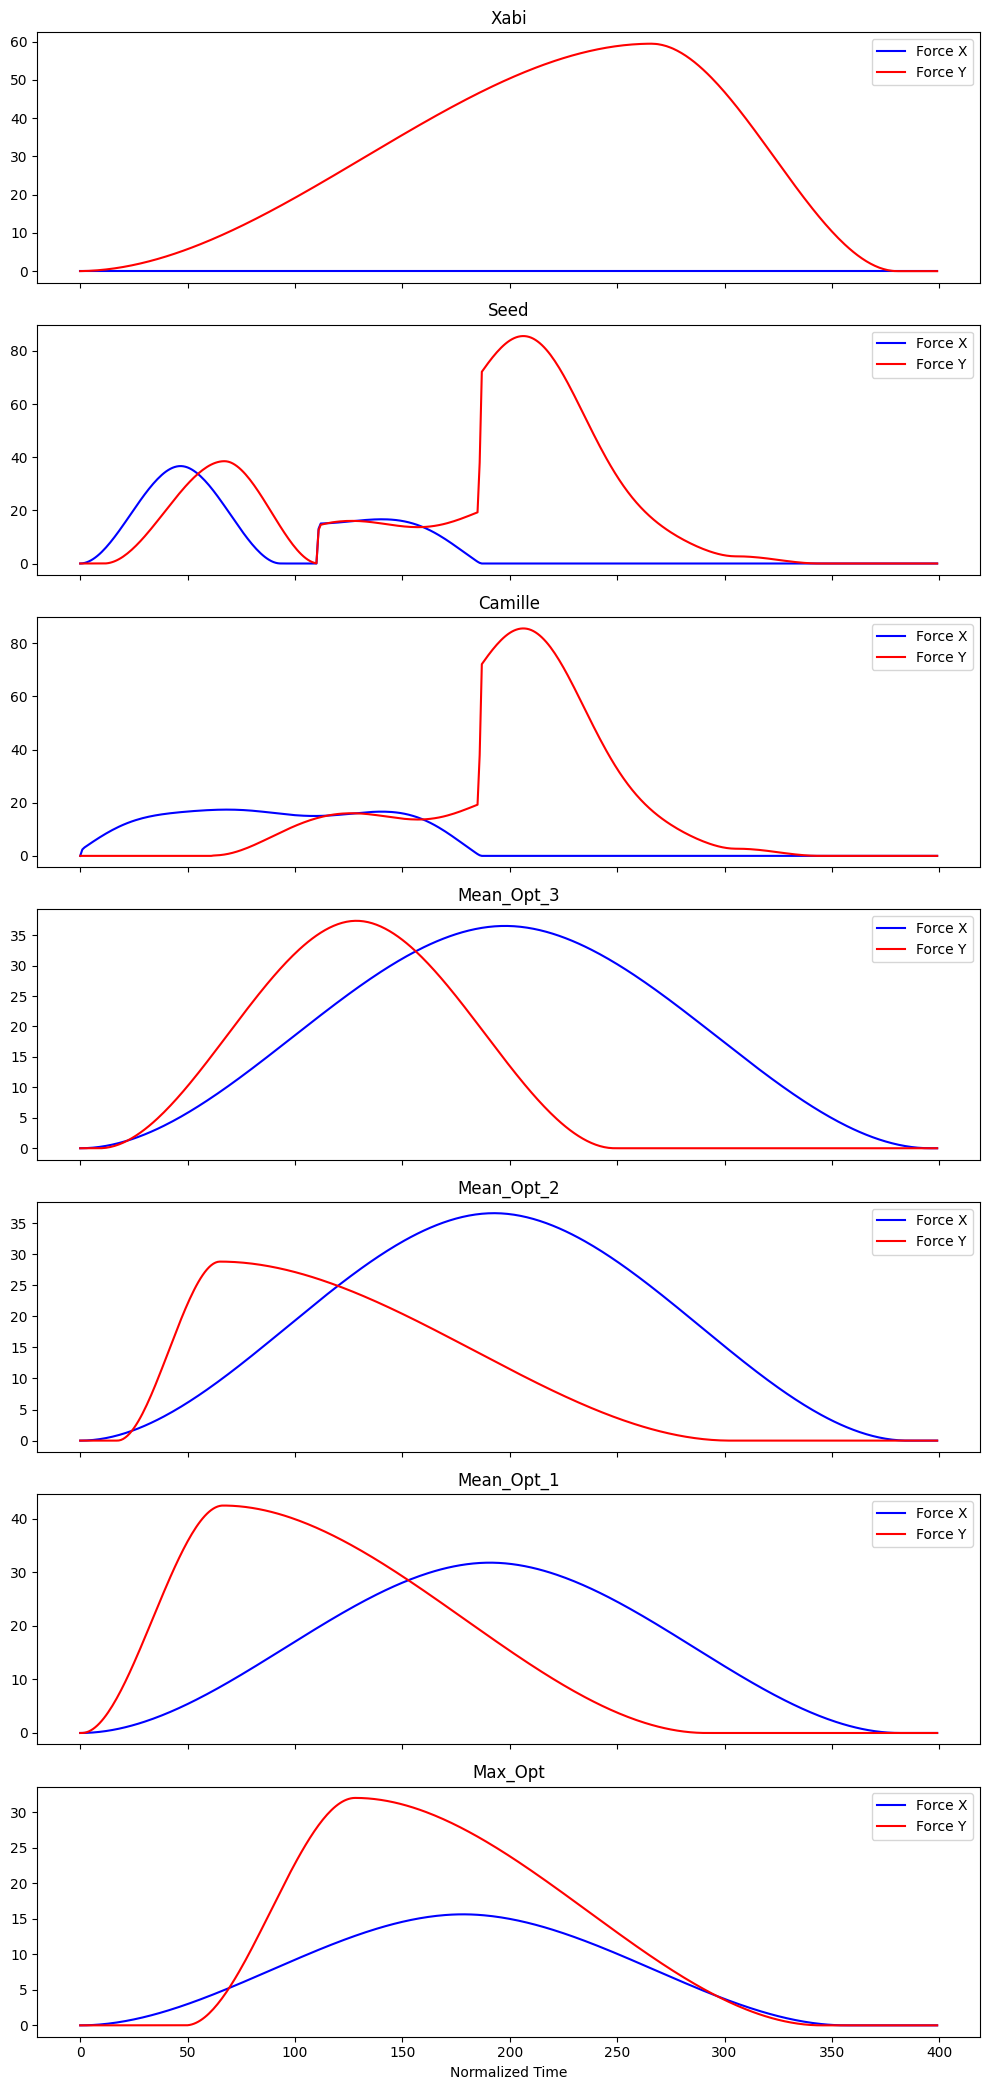

In [19]:
# Define the target length for normalization
TARGET_LENGTH = 400  # Adjust as needed

for subject in subjects:
    for session in iter(subject_data[subject.name].keys()):
        dir = subject_dirs[subject.name][session]["motor_dir"] / "profiles"
        profile_dir = subject_dirs[subject.name][session]["plot_dir"] / "profiles"
        profile_dir.mkdir(parents=True, exist_ok=True)

        csv_files = list(dir.glob("*.csv"))  # Find all CSV files in the directory

        num_profiles = len(csv_files)
        if num_profiles == 0:
            continue  # Skip if no profiles are found

        fig, axs = plt.subplots(num_profiles, 1, figsize=(10, 3 * num_profiles), sharex=True)

        if num_profiles == 1:
            axs = [axs]  # Ensure axs is iterable if there's only one subplot

        for ax, csv_file in zip(axs, csv_files):
            df = pd.read_csv(csv_file)

            if "force_X" in df and "force_Y" in df:
                # Normalize length
                old_length = len(df)
                new_x = np.linspace(0, old_length - 1, TARGET_LENGTH)
                force_X_interp = np.interp(new_x, np.arange(old_length), df["force_X"])
                force_Y_interp = np.interp(new_x, np.arange(old_length), df["force_Y"])

                ax.plot(force_X_interp, label="Force X", color="blue")
                ax.plot(force_Y_interp, label="Force Y", color="red")
                ax.set_title(csv_file.stem)
                ax.legend()

        axs[-1].set_xlabel("Normalized Time")

        plt.tight_layout()
        plt.savefig(profile_dir / "force_profiles.png")
        plt.show()
        

## Process MOTOR data

### Fix wrap-around from motor measurements

In [8]:

# Control variable to toggle the sign
torque_limits = [motor_config[motor]["T_max"] for motor in motor_config.keys()]

for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        session_data = subject_data[subject][session]["session_data"]

        for profile in session_data["ASSISTED"]["FIRST_TAGS"]:
            motor_data = session_data["ASSISTED"][profile]["MOTOR_DATA"]

            measured_torques = [column for column in motor_data[0].columns if "measured_tau" in column]

            for motor_df in motor_data:
                for torque, jump_threshold in zip(measured_torques, torque_limits):
                    differences = motor_df[torque].diff().fillna(0)

                    # Threshold for detecting a jump
                    toggle_sign = 1

                    corrected_values = []

                    for diff in differences:
                        if abs(diff) > jump_threshold:
                            toggle_sign *= -1
                        corrected_values.append(toggle_sign)
                    motor_df[torque] *= corrected_values

In [9]:
# Calculate forces 
rotate_90 = get_rotation_matrix(90)

for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        session_data = subject_data[subject][session]["session_data"]
                
        for profile in session_data["ASSISTED"]["FIRST_TAGS"]:
            for motor_log in session_data["ASSISTED"][profile]["MOTOR_DATA"]:
                measured_torques = motor_log[["measured_tau_1", "measured_tau_2"]].to_numpy()
                measured_torques = measured_torques.reshape(*measured_torques.shape, 1)

                jacobians = get_jacobian(l1=0.44, l2=0.41, theta_1=motor_log["theta_1"].to_numpy(), theta_2=motor_log["theta_2"].to_numpy())
                F = - np.linalg.inv(jacobians.T) @ measured_torques
                # F = - rotate_90[:2, :2] @ np.linalg.inv(jacobians.T) @ measured_torques

                motor_log["F_X"] = F[:, 0]
                motor_log["F_Y"] = F[:, 1]


In [5]:
# Plot motor data

for subject in subjects:
    for session in iter(subject_data[subject.name].keys()):
        # Prepare directories
        scores_dir = subject_dirs[subject.name][session]["plot_dir"] / "scores"
        scores_dir.mkdir(parents=True, exist_ok=True)

        name_tag_mapping = subject_data[subject.name][session]["name_tag_mapping"]

        for profile in subject_data[subject.name][session]["session_data"]["ASSISTED"]["FIRST_TAGS"]:
            i = 0
            for motor_log in subject_data[subject.name][session]["session_data"]["ASSISTED"][profile]["MOTOR_DATA"]:
                i += 1

                colors = iter(rcParams['axes.prop_cycle'].by_key()['color'])

                plot_dir = subject_dirs[subject.name][session]["plot_dir"] / "motor_plots"
                plot_dir.mkdir(exist_ok=True)
                filename = plot_dir / f"motor_{name_tag_mapping[profile]}_{i}.svg"

                # Use GridSpec to control subplot layouts
                fig = plt.figure(figsize=(8, 9))
                gs = gridspec.GridSpec(5, 1, height_ratios=[1, 1, 1, 1, 1.2])  # Last subplot is slightly taller
                fig.suptitle(name_tag_mapping[profile])

                # Subplots with shared x-axis
                ax0 = fig.add_subplot(gs[0])
                ax1 = fig.add_subplot(gs[1], sharex=ax0)
                ax2 = fig.add_subplot(gs[2], sharex=ax0)
                ax3 = fig.add_subplot(gs[3], sharex=ax0)

                # Subplot with independent x-axis
                ax4 = fig.add_subplot(gs[4])

                # Plot theta_2
                ax0.plot(motor_log.index, motor_log["theta_2"], label=r"$\theta_2$", color=colors.__next__())
                ax0.set_ylabel(r"$\theta_2$ (rad)")
                handles0, labels0 = ax0.get_legend_handles_labels()

                # Plot torques
                ax1.plot(motor_log.index, motor_log["target_tau_1"], label=r"Target $\tau_1$", color=colors.__next__())
                ax1.plot(motor_log.index, motor_log["measured_tau_1"], label=r"Measured $\tau_1$", color=colors.__next__())
                ax1.plot(motor_log.index, motor_log["target_tau_2"], label=r"Target $\tau_2$", color=colors.__next__())
                ax1.plot(motor_log.index, motor_log["measured_tau_2"], label=r"Measured $\tau_2$", color=colors.__next__())
                ax1.set_ylabel("Torques (Nm)", fontsize=12)
                handles1, labels1 = ax1.get_legend_handles_labels()

                # Plot forces F_X and F_Y
                ax2.plot(motor_log.index, motor_log["F_X"], label=r"$F_X$", color=colors.__next__())
                ax2.plot(motor_log.index, motor_log["F_Y"], label=r"$F_Y$", color=colors.__next__())
                ax2.set_ylabel("Forces (N)")
                handles2, labels2 = ax2.get_legend_handles_labels()

                # Plot STS percentage
                ax3.plot(motor_log.index, motor_log["Percentage"], label="STS %", color=colors.__next__())
                ax3.axhline(y=100, linestyle="--", color="black")
                ax3.axhline(y=0, linestyle="--", color="black")
                ax3.set_ylabel("STS %")
                ax3.set_xlabel('Time (s)')
                handles3, labels3 = ax3.get_legend_handles_labels()

                # Plot actual forces with a different x-axis
                # profile_data = subject_data[subject.name][session]["session_data"]["ASSISTED"][profile]["FORCE_PROFILE"]
                # ax4.plot(profile_data.index, profile_data["force_X"], label=r"Actual $F_X$", color=colors.__next__())
                # ax4.plot(profile_data.index, profile_data["force_Y"], label=r"Actual $F_Y$", color=colors.__next__())
                # ax4.set_ylabel("Forces (N)")
                # ax4.set_xlabel('Index')
                # handles4, labels4 = ax4.get_legend_handles_labels()

                # Combine all legend handles and labels
                handles = handles0 + handles1 + handles2 + handles3 #+ handles4
                labels = labels0 + labels1 + labels2 + labels3 #+ labels4
                fig.legend(handles, labels, loc='upper center', ncols=6, bbox_to_anchor=(0.5, 0.97), fontsize=10)

                # Adjust layout
                plt.tight_layout(rect=[0, 0.03, 1, 0.95])

                # Save the plot
                plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
                plt.close()


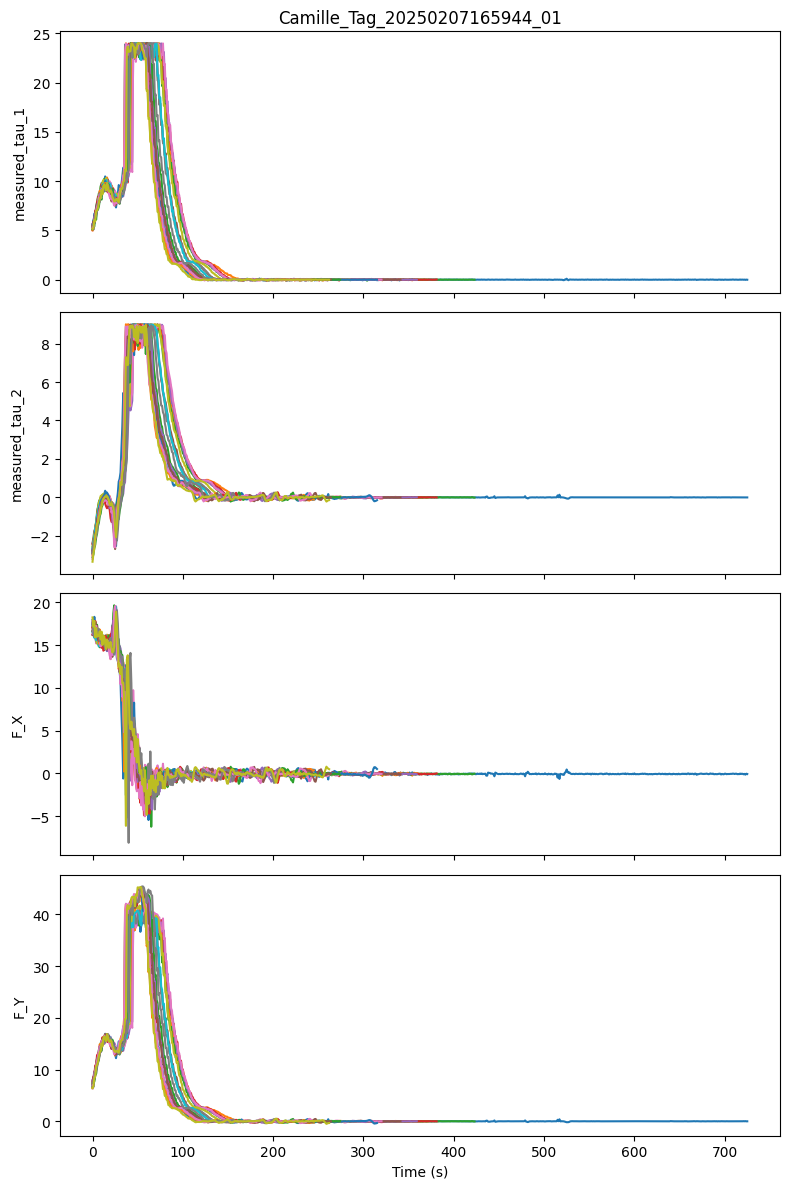

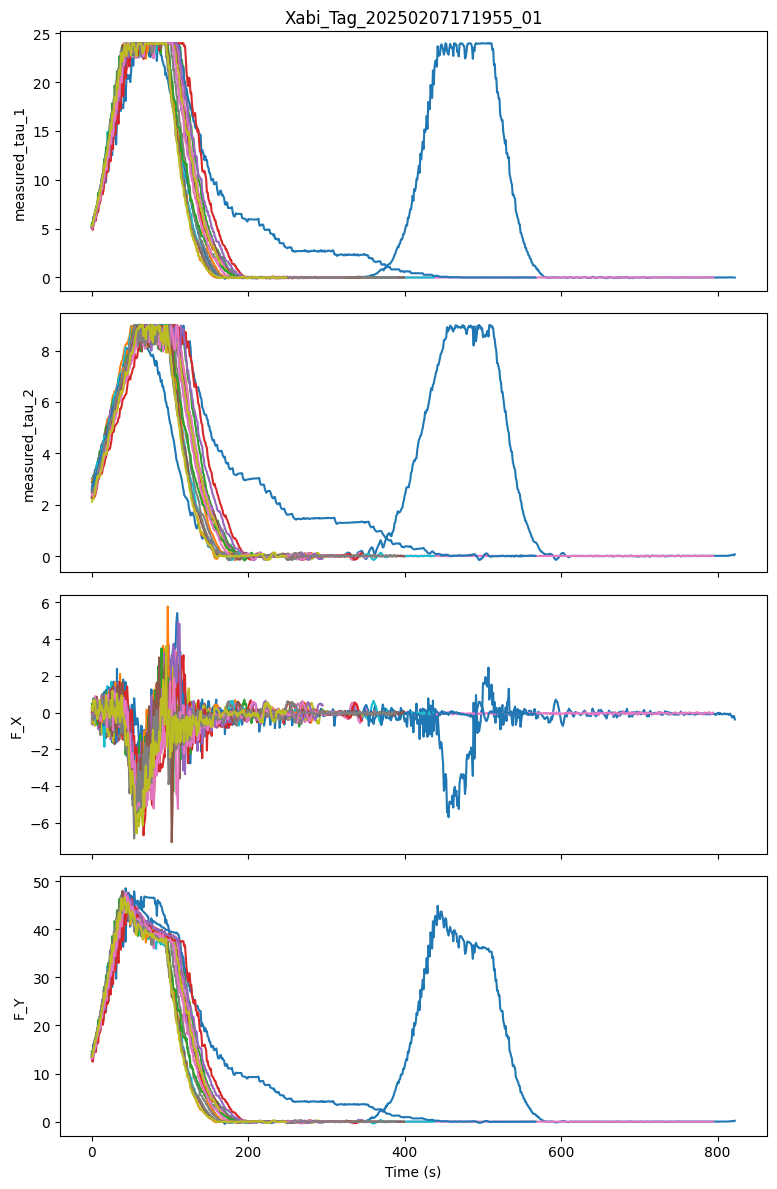

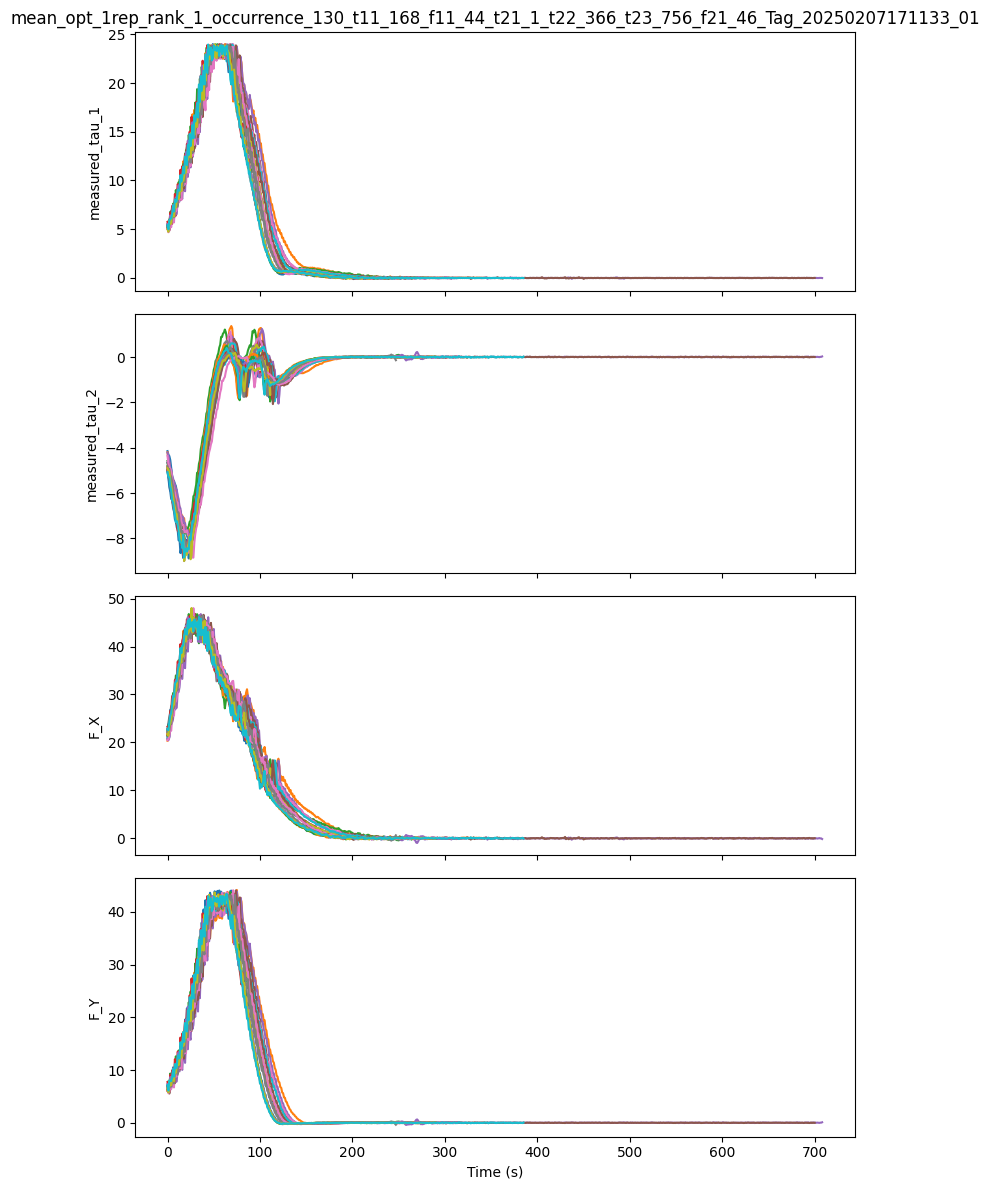

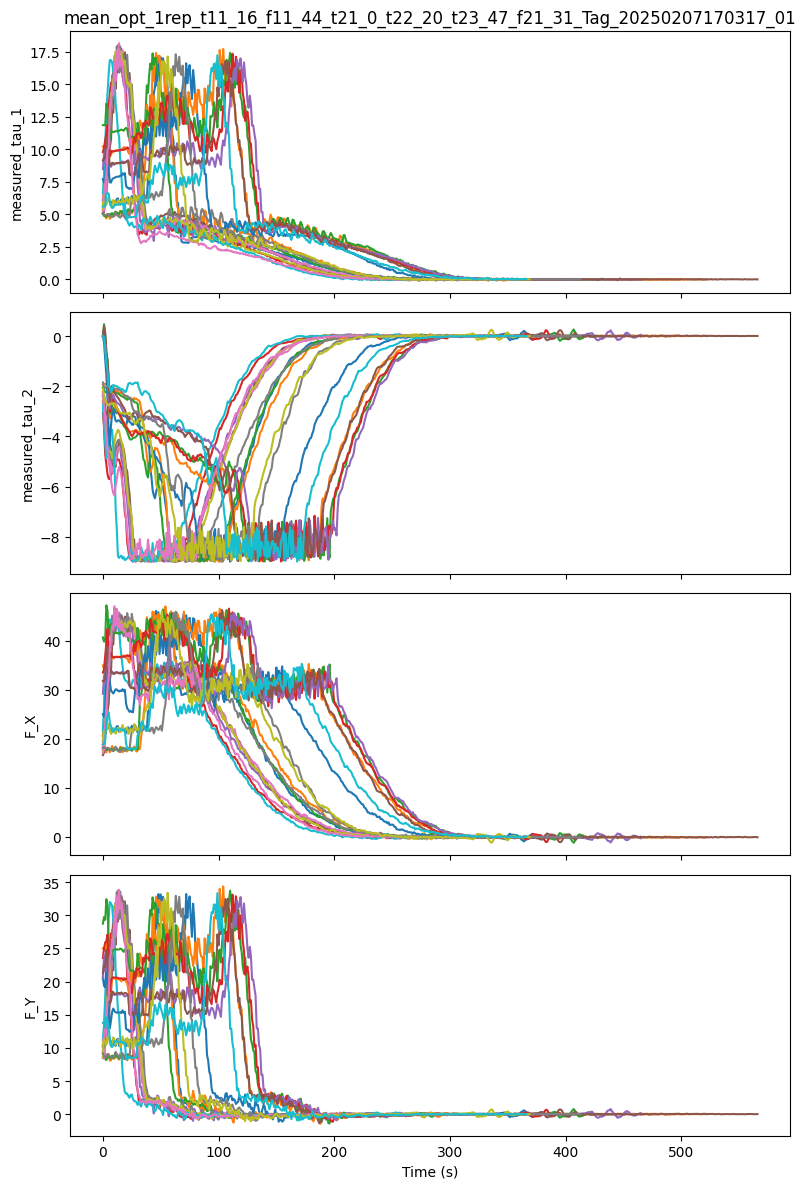

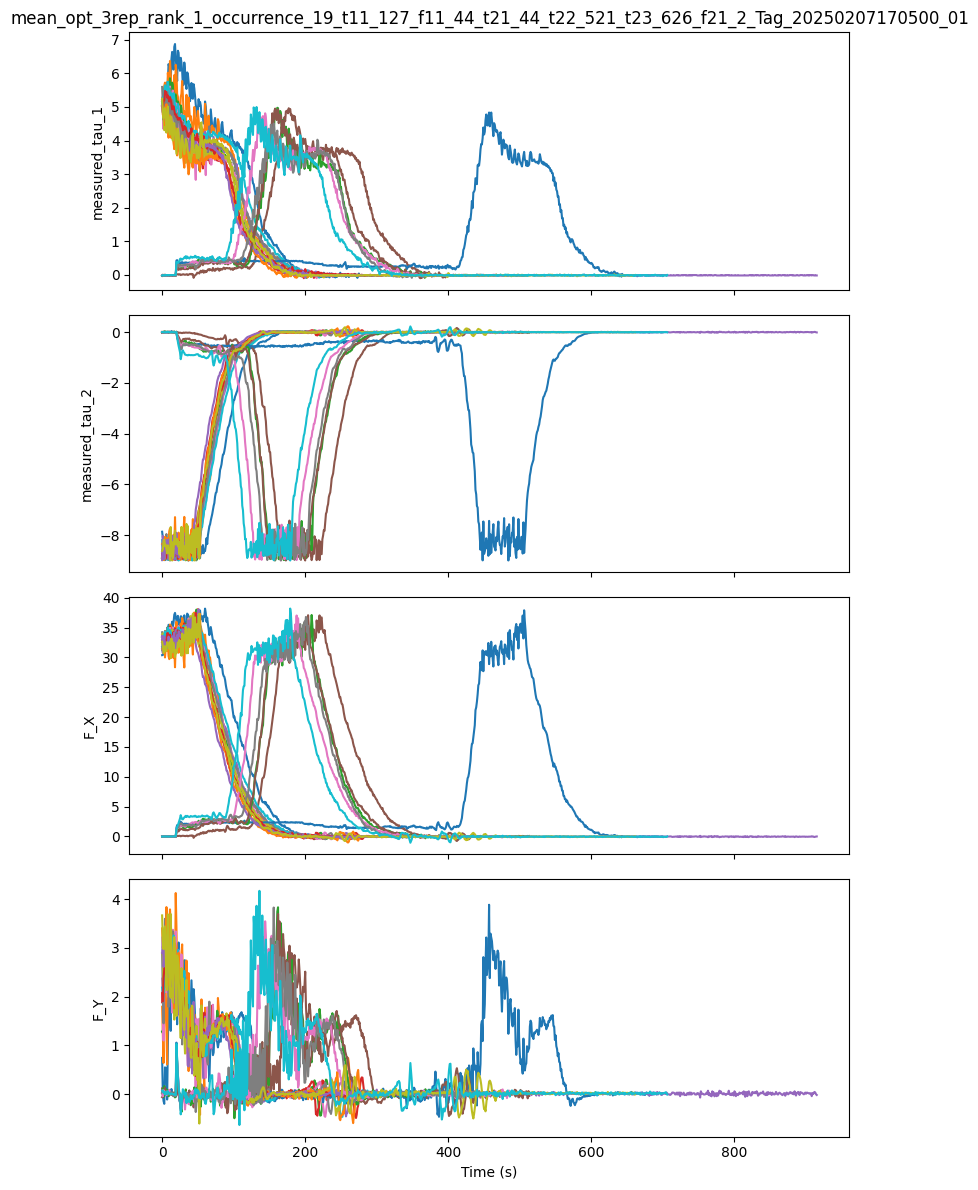

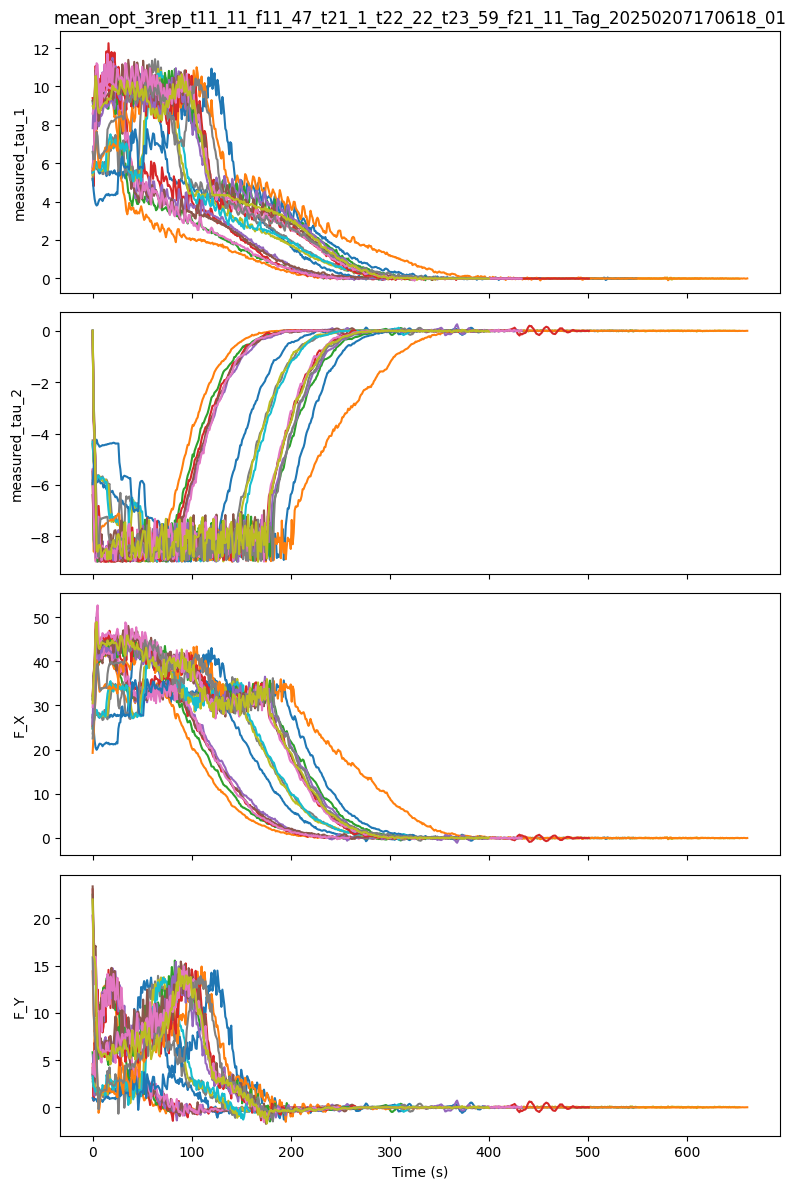

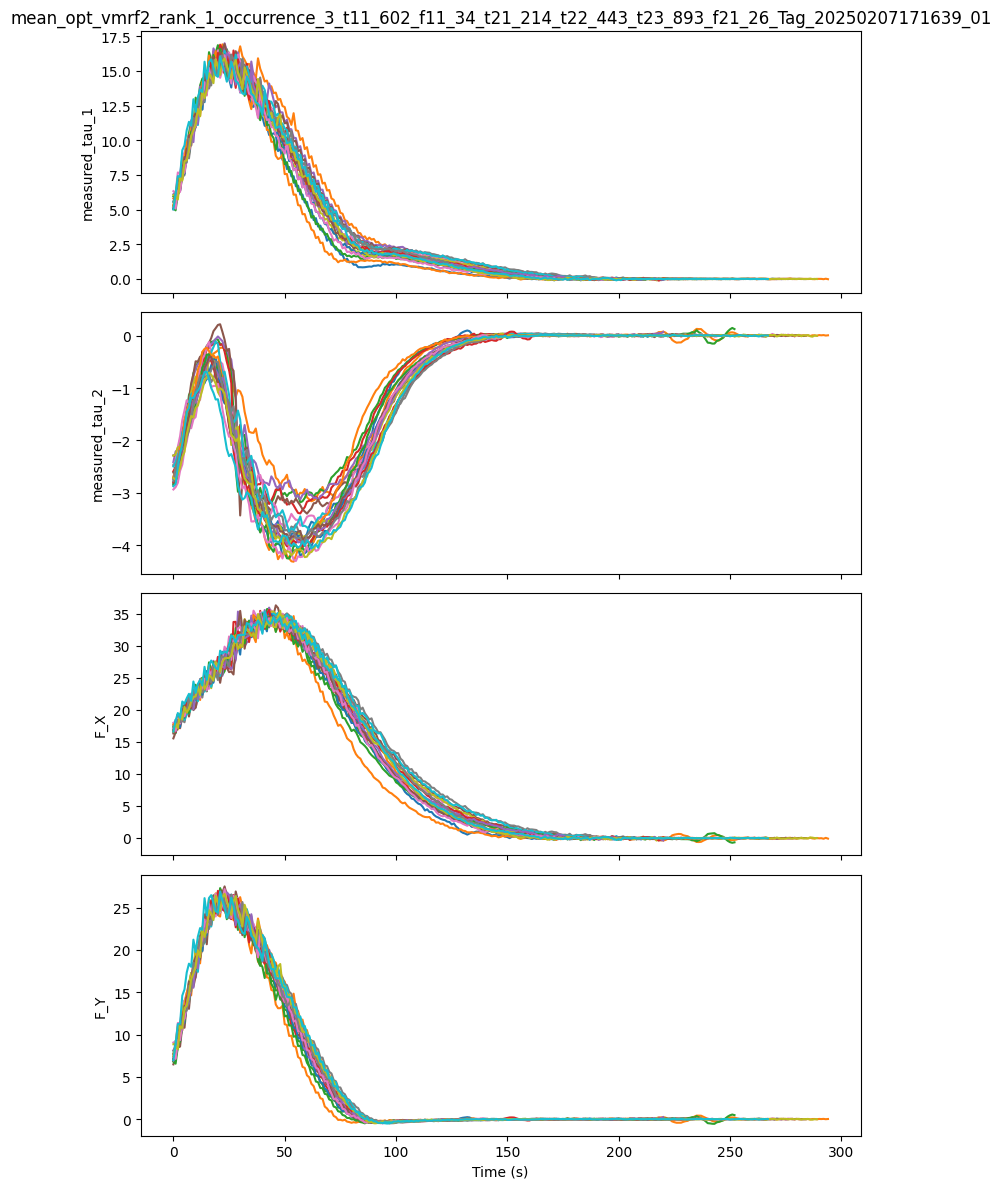

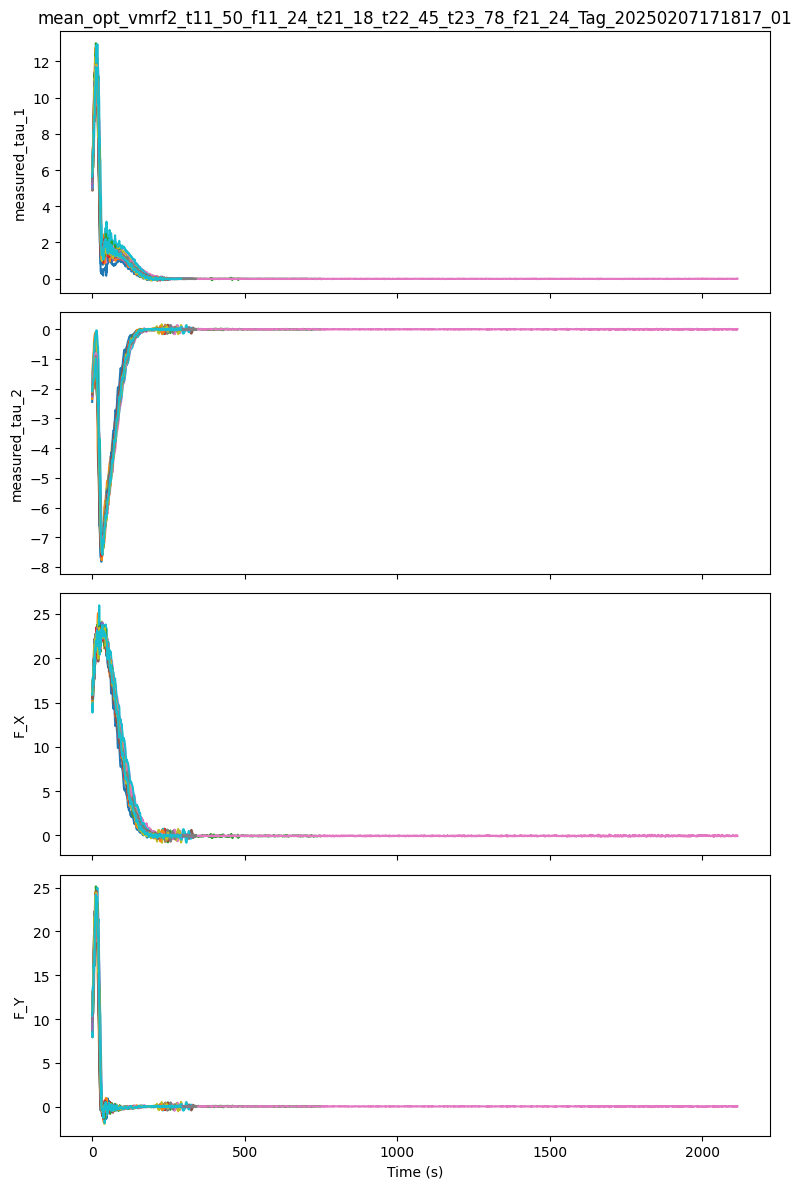

In [20]:


# Compare all motor data per profile$
for subject in subjects:
    for session in iter(subject_data[subject.name].keys()):
        # Prepare directories
        scores_dir = subject_dirs[subject.name][session]["plot_dir"] / "scores"
        scores_dir.mkdir(parents=True, exist_ok=True)

        name_tag_mapping = subject_data[subject.name][session]["name_tag_mapping"]

        for profile in subject_data[subject.name][session]["session_data"]["ASSISTED"]["FIRST_TAGS"]:
            # Initialize plot with amount of subplots equal to the number of motor logs for the profile
            length = 4
            fig, axs = plt.subplots(length, 1, figsize=(8, 3 * length), sharex=True)

            for i, motor_log in enumerate(subject_data[subject.name][session]["session_data"]["ASSISTED"][profile]["MOTOR_DATA"]):

                # Align signals based on the first point where the measured tau 1 is larger than 3
                idx = motor_log["measured_tau_1"].gt(5).idxmax()
                motor_log = motor_log.loc[idx:].reset_index(drop=True)

                

                # plot the forces and torques
                axs[0].plot(motor_log.index, motor_log["measured_tau_1"], label="measured_tau_1")
                axs[1].plot(motor_log.index, motor_log["measured_tau_2"], label="measured_tau_2")
                axs[2].plot(motor_log.index, motor_log["F_X"], label="F_X")
                axs[3].plot(motor_log.index, motor_log["F_Y"], label="F_Y")

            # Add names to axes
            axs[0].set_title(name_tag_mapping[profile])
            axs[0].set_ylabel("measured_tau_1")
            axs[1].set_ylabel("measured_tau_2")
            axs[2].set_ylabel("F_X")
            axs[3].set_ylabel("F_Y")


            # Time as x-axis
            axs[3].set_xlabel("Time (s)")
            
            plt.tight_layout()
            plt.show()
            # plt.savefig(scores_dir / f"motor_data_{name_tag_mapping[profile]}.png")
            plt.close()





In [ ]:
# Plot every muscle for every iteration

subject = "subject_Nathan"
session = "October_31"

# target_muscle = "BF_RIGHT"
# profile = "peak_77%_62N"

filtered_session_data = subject_data[subject][session]["filtered_session_data"]

plot_dir = subject_dirs[subject][session]["plot_dir"] / "force_muscle"
plot_dir.mkdir(exist_ok=True)
filename = plot_dir / f"overview_force_muscle.svg"

n_cols = len(filtered_session_data["ASSISTED"].keys())
n_rows = len(filtered_session_data["ASSISTED"][profile]["MOTOR_DATA"])

for target_muscle in ["BF_LEFT", "BF_RIGHT", "VM_LEFT", "VM_RIGHT", "G_LEFT", "G_RIGHT", "RF_LEFT", "RF_RIGHT", "TA_RIGHT", "SO_RIGHT"]:
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 10), sharey=True)
    fig.suptitle(f"Subject {subject} EMG and force data")   
    for i, profile in enumerate(filtered_session_data["ASSISTED"].keys()):
        words = profile.split('_')
        axs[0, i].set_title('_'.join(words[-2:]))
        for j, motor_df in enumerate(filtered_session_data["ASSISTED"][profile]["MOTOR_DATA"]):
            emg_data = filtered_session_data["ASSISTED"][profile]["EMG"][j]

            # Remove the first 3 seconds of EMG data
            emg_data = emg_data[emg_data.index >= 3]  # Keep data from 3 seconds onwards
            emg_data = emg_data[emg_data.index <= 5.5]  # Crop data after 2.5 seconds (3s to 5.5s)
            emg_data.index = emg_data.index - 3  # Reset index to start from 0

            # Remove everything after 2.5 Seconds in the motor data
            motor_df = motor_df[motor_df.index <= 2.5]  # Crop data after 2.5 seconds

            # Plot force values on the primary y-axis
            axs[j, i].plot(motor_df.index, motor_df.F_Y, label=r"Applied force $F_Y$", color='orange')
            axs[j, i].tick_params(axis='y', labelcolor='orange')

            # Create a secondary y-axis for EMG data
            ax2 = axs[j, i].twinx()
            ax2.plot(emg_data.index, emg_data[target_muscle], label=target_muscle, color=u'#1f77b4')
            ax2.set_ylim(0, 1)  # Set EMG activation scale from 0 to 1
            
            if i == len(filtered_session_data["ASSISTED"].keys()) - 1:
                ax2.set_ylabel('EMG (% MVIC)', color='black')
            ax2.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
            ax2.tick_params(axis='y', labelcolor=u'#1f77b4')

            axs[j, 0].set_ylabel(f"Iteration {j+1}\nForce (N)")
            axs[-1, i].set_xlabel("Time (s)")

            handles, labels = axs[j, i].get_legend_handles_labels()
            handles2, labels2 = ax2.get_legend_handles_labels()
            handles += handles2
            labels += labels2

    fig.legend(handles, labels, loc='upper center', ncols=2, bbox_to_anchor=(0.5, 0.96), fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    # plt.savefig(filename, dpi=500, format='svg')
    plt.savefig(plot_dir / f"{target_muscle}_{filename.with_suffix('.png').name}", dpi=500, format="png")
    plt.show()

### Calculate the relevant time window through IMU



In [ ]:
# Calculate all the start and end times best on the imu data

time_range = namedtuple("TimeRange", ["min", "max"])


for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        plot_dir = subject_dirs[subject][session]["plot_dir"] / "imu_segmentation"
        plot_dir.mkdir(exist_ok=True)

        relevant_time_ranges_imu = {}
        filtered_session_data = subject_data[subject][session]["filtered_session_data"]

        for profile in filtered_session_data["ASSISTED"].keys():
            relevant_time_ranges_imu[profile] = {"ranges": []}
            imu_data = subject_data[subject][session]["filtered_session_data"]["ASSISTED"][profile]["IMU"]
            # emg_data = filtered_session_data["ASSISTED"][profile]["EMG"]
            emg_data = subject_data[subject][session]["filtered_session_data"]["ASSISTED"][profile]["EMG"]
            log_data = subject_data[subject][session]["filtered_session_data"]["ASSISTED"][profile]["LOG"]

            for i, imu_df in enumerate(imu_data):
                emg_df = emg_data[i]
                
                # Filter imu_data
                imu_df_filtered = apply_lowpass_filter(imu_df, 1, 518.519)

                imu_time_interval = 1 / 518.519
                
                if i < len(log_data):
                    log_df = log_data[i].copy()
                    # Add the global time to log data
                    log_df['Start Time'] += log_df['Segment Start Index']
                    log_df['End Time'] += log_df['Segment Start Index']

                    # Convert log data to time
                    log_df['Start Time'] = log_df['Start Time'] * imu_time_interval
                    log_df['End Time'] = log_df['End Time'] * imu_time_interval
                    log_df['Segment Start Index'] = log_df['Segment Start Index'] * imu_time_interval
                    log_df['Segment End Index'] = log_df['Segment End Index'] * imu_time_interval
                
                else:
                    log_df = pd.DataFrame()

                start_time, end_time = segmentation(imu_df_filtered)
                
                relevant_time_ranges_imu[profile]["ranges"].append(time_range(start_time, end_time))

                # plot_collected_and_calculated_imu_data(imu_df_filtered, emg_df, log_df, plot_dir, start_time, end_time, profile, i)


        for unassisted_time in filtered_session_data["UNPOWERED"].keys():
            relevant_time_ranges_imu[f"UNPOWERED_{unassisted_time}"] = {"ranges": []}
            imu_data = subject_data[subject][session]["filtered_session_data"]["UNPOWERED"][unassisted_time]["IMU"]
            emg_data = subject_data[subject][session]["filtered_session_data"]["UNPOWERED"][unassisted_time]["EMG"]
            log_data = subject_data[subject][session]["filtered_session_data"]["UNPOWERED"][unassisted_time]["LOG"]

            for i, imu_df in enumerate(imu_data):
                emg_df = emg_data[i]
                
                # Filter imu_data
                imu_df_filtered = apply_lowpass_filter(imu_df, 1, 518.519)

                imu_time_interval = 1 / 518.519

                if i < len(log_data):
                    log_df = log_data[i].copy()
                    # Add the global time to log data
                    log_df['Start Time'] += log_df['Segment Start Index']
                    log_df['End Time'] += log_df['Segment Start Index']

                    # Convert log data to time
                    log_df['Start Time'] = log_df['Start Time'] * imu_time_interval
                    log_df['End Time'] = log_df['End Time'] * imu_time_interval
                    log_df['Segment Start Index'] = log_df['Segment Start Index'] * imu_time_interval
                    log_df['Segment End Index'] = log_df['Segment End Index'] * imu_time_interval
                
                else:
                    log_df = pd.DataFrame()

                start_time, end_time = segmentation(imu_df_filtered)
                
                relevant_time_ranges_imu[f"UNPOWERED_{unassisted_time}"]["ranges"].append(time_range(start_time, end_time))

                # plot_collected_and_calculated_imu_data(imu_df_filtered, emg_df, log_df, plot_dir, start_time, end_time, f"UNPOWERED_{unassisted_time}", i)

        subject_data[subject][session]["relevant_time_ranges_imu"] = relevant_time_ranges_imu


In [ ]:
for profile in subject_data[subject][session]["filtered_session_data"]["ASSISTED"].keys():
    
    for i, motor_log in enumerate(subject_data[subject][session]["filtered_session_data"]["ASSISTED"][profile]["MOTOR_DATA"]):

        # Extract the relevant time frame
        relevant_time_ranges = subject_data[subject][session]["relevant_time_ranges_imu"][profile]["ranges"][i]
        min_trim = relevant_time_ranges.min - 3 
        max_trim = relevant_time_ranges.max - 3

        # Crop the motor data
        motor_log = motor_log[(motor_log.index >= min_trim) & (motor_log.index <= max_trim)]


        colors = iter(rcParams['axes.prop_cycle'].by_key()['color'])

        plot_dir = subject_dirs[subject][session]["plot_dir"] / "motor_plots"
        filename = plot_dir / f"motor_filtered_{profile}_cropped_{i}.svg"


        fig, ax = plt.subplots(3, 1, sharex=True, figsize=(8, 5))
        fig.suptitle(profile)

        ax[0].plot(motor_log.index, motor_log["theta_2"], label=r"$\theta_2$", color=colors.__next__())
        handles0, labels0 = ax[0].get_legend_handles_labels()
        ax[0].set_ylabel(r"$\theta_2$ (rad)")
        # add a vertical line at the start and end of the relevant time frame
        ax[0].axvline(x=min, color='red', linestyle='--')
        ax[0].axvline(x=max, color='red', linestyle='--')

        ax[1].plot(motor_log.index, motor_log["target_tau_1"], label=r"Target $\tau_1$", color=colors.__next__())
        ax[1].plot(motor_log.index, motor_log["measured_tau_1"], label=r"Measured $\tau_1$", color=colors.__next__())
        ax[1].plot(motor_log.index, motor_log["target_tau_2"], label=r"Target $\tau_2$", color=colors.__next__())
        ax[1].plot(motor_log.index, motor_log["measured_tau_2"], label=r"Measured $\tau_2$", color=colors.__next__())
        # add a vertical line at the start and end of the relevant time frame
        ax[1].axvline(x=min, color='red', linestyle='--')
        ax[1].axvline(x=max, color='red', linestyle='--')
        handles1, labels1 = ax[1].get_legend_handles_labels()
        ax[1].set_ylabel("Torques (Nm)", fontsize=12)

        ax[2].plot(motor_log.index, motor_log["Percentage"], label="STS %", color=colors.__next__())
        ax[2].axhline(y=100, linestyle="--", color="black")
        ax[2].axhline(y=0, linestyle="--", color="black")
        # add a vertical line at the start and end of the relevant time frame
        ax[2].axvline(x=min, color='red', linestyle='--')
        ax[2].axvline(x=max, color='red', linestyle='--')
        handles2, labels2 = ax[2].get_legend_handles_labels()
        ax[2].set_ylabel("STS %")
        ax[2].set_xlabel('time(s)')

        handles = handles0 + handles1 + handles2
        labels = labels0 + labels1 + labels2
        fig.legend(handles, labels, loc='upper center', ncols=6, bbox_to_anchor=(0.5, 0.93), fontsize=10)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(filename, dpi=500, format='svg')
        plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
        plt.show()

### Average STS duration across profiles and subjects

In [ ]:
# Extract durations from the time ranges
fig, ax = plt.subplots(1, ncols=len(subject_data.keys()), figsize=(10, 5))
fig.suptitle("Durations per profile and subject")

# Ensure `ax` is always a list
if len(subject_data.keys()) == 1:
    ax = [ax]

for i, subject in enumerate(subject_data.keys()):
    for session in subject_data[subject].keys():
        
        relevant_time_ranges = subject_data[subject][session]["relevant_time_ranges_imu"]

        durations = {profile: [time_range.max - time_range.min for time_range in time_ranges["ranges"]] for profile, time_ranges in relevant_time_ranges.items()}

        # Drop empty keys
        durations = {k: v for k, v in durations.items() if v}

        # Sort and create DataFrame
        durations = dict(sorted(durations.items()))
        durations_df = pd.DataFrame.from_dict(durations, orient='index').T

        # Plot mean and std of the durations
        durations_df.mean().plot(kind='bar', yerr=durations_df.std(), ax=ax[i])
        ax[i].set_ylabel("Duration (s)")
        ax[i].set_xlabel("Profile")
        ax[i].set_title(f"Subject {subject}")
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig("../paper_figures/durations_per_profile.svg", format='svg')
plt.savefig("../paper_figures/durations_per_profile.png", dpi=500, format='png')
plt.savefig(latex_figure_dir / "emg_plots" / "durations_per_profile.png", dpi=500, format="png")
plt.show()


### Time windows across all iterations

In [ ]:
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        filtered_session_data = subject_data[subject][session]["filtered_session_data"]

        motor_data_dfs = filtered_session_data["UNPOWERED"]["BEFORE"]["MOTOR_DATA"][0]

        for power in filtered_session_data["UNPOWERED"].keys():
            motor_data_dfs = filtered_session_data["UNPOWERED"][power]["MOTOR_DATA"]

            for j, motor_df in enumerate(motor_data_dfs):
                # Filter out data to look only for indices after 0.1 seconds
                motor_df_after_01s = motor_df[motor_df.index > 0.2]
                # print(motor_df_after_01s["Percentage"])
                start_index = motor_df_after_01s[motor_df_after_01s['Percentage'] > 10].index.min()
                stop_index = motor_df_after_01s[motor_df_after_01s['Percentage'] > 85].index.min()

                plt.plot(motor_df_after_01s.index, motor_df_after_01s["Percentage"])
                plt.axvline(x=start_index-0.05, color='r', linestyle='--')
                plt.axvline(x=stop_index+0.1, color='r', linestyle='--')
                plt.show()
                

In [ ]:
# Manually remove one iteration
# print(filtered_session_data["UNPOWERED"]["BEFORE"]["EMG"][4])
# print(filtered_session_data["UNPOWERED"]["BEFORE"]["MOTOR_DATA"][4])

# filtered_session_data["UNPOWERED"]["BEFORE"]["EMG"].pop(4)
# filtered_session_data["UNPOWERED"]["BEFORE"]["MOTOR_DATA"].pop(4)

In [ ]:
# Iterate through all profiles and calculate the mean muscle activation during the relevant time period
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        filtered_session_data = subject_data[subject][session]["filtered_session_data"]

        relevant_time_ranges = subject_data[subject][session]["relevant_time_ranges_imu"]

        mean_muscle_activations = {}


        for profile in filtered_session_data["ASSISTED"].keys():
            mean_muscle_activations[profile] = []

            for i, emg_data in enumerate(filtered_session_data["ASSISTED"][profile]["EMG"]):
                # Remove the first 3 seconds of EMG data
                # emg_data = emg_data[emg_data.index >= 3]  # Keep data from 3 seconds onwards
                # emg_data.index = emg_data.index - 3  # Reset index to start from 0
                time_range = relevant_time_ranges[profile]["ranges"][i]
                emg_data = emg_data[(emg_data.index >= time_range.min) & (emg_data.index <= time_range.max)]
                # emg_data = emg_data[(emg_data.index >= 0.5) & (emg_data.index <= 1.7)]
                mean_muscle_activations[profile].append(emg_data.mean())
                

        for unpowered_time in filtered_session_data["UNPOWERED"].keys():
            mean_muscle_activations[f"UNPOWERED_{unpowered_time}"] = []

            for i, emg_data in enumerate(filtered_session_data["UNPOWERED"][unpowered_time]["EMG"]):
                # emg_data = emg_data[emg_data.index >= 3]
                # emg_data.index = emg_data.index - 3
                time_range = relevant_time_ranges[f"UNPOWERED_{unpowered_time}"]["ranges"][i]
                emg_data = emg_data[(emg_data.index >= time_range.min) & (emg_data.index <= time_range.max)]
                mean_muscle_activations[f"UNPOWERED_{unpowered_time}"].append(emg_data.mean())

        subject_data[subject][session]["mean_muscle_activations"] = mean_muscle_activations


In [ ]:
# Iterate through all profiles and calculate and plot a mean profile for each profile over all 5 iterations
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        filtered_session_data = subject_data[subject][session]["filtered_session_data"]

        mean_muscle_activations = {}

        mean_muscle_activations = subject_data[subject][session]["mean_muscle_activations"]

        plot_dir = subject_dirs[subject][session]["plot_dir"] / "mean_muscle_activation_profiles"
        plot_dir.mkdir(exist_ok=True)

        mean_profiles = {}
        total_activation = {}

        relevant_time_ranges = subject_data[subject][session]["relevant_time_ranges_imu"]

        for unpowered_time in filtered_session_data["UNPOWERED"].keys():
            mean_activation_profile = pd.DataFrame()

            for i, emg_data in enumerate(filtered_session_data["UNPOWERED"][unpowered_time]["EMG"]):
                 # Remove the first 3 seconds of EMG data
                # emg_data = emg_data[emg_data.index >= 3]  # Keep data from 3 seconds onwards
                # emg_data.index = emg_data.index - 3  # Reset index to start from 0
                time_range = relevant_time_ranges[f"UNPOWERED_{unpowered_time}"]["ranges"][i]
                emg_data = emg_data[(emg_data.index >= time_range.min) & (emg_data.index <= time_range.max)]
                # emg_data = emg_data[(emg_data.index >= 0.4) & (emg_data.index <= 1.8)]
                if mean_activation_profile.empty:
                    mean_activation_profile = emg_data/len(filtered_session_data["UNPOWERED"][unpowered_time]["EMG"])
                else:
                    # Reindex both DataFrames to the union of their indices to handle different lengths
                    common_index = mean_activation_profile.index.union(emg_data.index)
                    # Reindex both DataFrames to the common index and fill missing values with 0
                    mean_activation_profile = mean_activation_profile.reindex(common_index, fill_value=0)
                    emg_data = emg_data.reindex(common_index, fill_value=0)
                    # Add the reindexed emg_data to mean_activation_profile
                    mean_activation_profile += emg_data / len(filtered_session_data["UNPOWERED"][unpowered_time]["EMG"])

            # Sum over all muscles to get mean activation profile
            mean_activation_profile = mean_activation_profile.sum(axis=1) / len(filtered_session_data["UNPOWERED"][unpowered_time]["EMG"])
            mean_profiles[f"UNPOWERED_{unpowered_time}"] = mean_activation_profile

            # Get are under the curve for the mean activation profile
            total_activation[f"UNPOWERED_{unpowered_time}"] = mean_activation_profile.sum()/len(filtered_session_data["UNPOWERED"][unpowered_time]["EMG"])

        
        for profile in filtered_session_data["ASSISTED"].keys():
            mean_activation_profile = pd.DataFrame()

            for i, emg_data in enumerate(filtered_session_data["ASSISTED"][profile]["EMG"]):
                # Remove the first 3 seconds of EMG data
                # emg_data = emg_data[emg_data.index >= 3]  # Keep data from 3 seconds onwards
                # emg_data.index = emg_data.index - 3  # Reset index to start from 0
                time_range = relevant_time_ranges[profile]["ranges"][i]
                emg_data = emg_data[(emg_data.index >= time_range.min) & (emg_data.index <= time_range.max)]
                # emg_data = emg_data[(emg_data.index >= 0.4) & (emg_data.index <= 1.8)]
                if mean_activation_profile.empty:
                    mean_activation_profile = emg_data/len(filtered_session_data["ASSISTED"][profile]["EMG"])
                else:
                    # Reindex both DataFrames to the union of their indices to handle different lengths
                    common_index = mean_activation_profile.index.union(emg_data.index)
                    # Reindex both DataFrames to the common index and fill missing values with 0
                    mean_activation_profile = mean_activation_profile.reindex(common_index, fill_value=0)
                    emg_data = emg_data.reindex(common_index, fill_value=0)
                    # Add the reindexed emg_data to mean_activation_profile
                    mean_activation_profile += emg_data / len(filtered_session_data["UNPOWERED"][unpowered_time]["EMG"])
            
            # Get are under the curve for the mean activation profile
            total_activation[profile] = mean_activation_profile.sum()/len(filtered_session_data["ASSISTED"][profile]["EMG"])

            # Sum over all muscles to get mean activation profile
            mean_activation_profile = mean_activation_profile.sum(axis=1) / len(filtered_session_data["ASSISTED"][profile]["EMG"])
            mean_profiles[profile] = mean_activation_profile
            
            filename = plot_dir / f"mean_activation_profile_percentage{profile}"
            
            # Plot both unassisted mean profiles in addition to the current assisted profile
            fig, ax = plt.subplots(1, figsize=(10, 5))
            fig.suptitle(f"Mean muscle activation profile\n{subject} - {profile}")

            for unpowered_time in filtered_session_data["UNPOWERED"].keys():
                ax.plot(mean_profiles[f"UNPOWERED_{unpowered_time}"].index, mean_profiles[f"UNPOWERED_{unpowered_time}"], label=f"UNPOWERED_{unpowered_time}")

            ax.plot(mean_profiles[profile].index, mean_profiles[profile], label=profile)
            ax.set_ylabel("Mean activation")
            ax.set_xlabel("Time (s)")
            ax.legend()
            plt.tight_layout()
            plt.savefig(filename, dpi=500, format='svg')
            plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
            plt.show()
        
        # Plot the total activation for each profile
        fig, ax = plt.subplots(1, figsize=(10, 5))
        fig.suptitle(f"Total muscle activation\n{subject}")
        for profile in total_activation.keys():
            ax.bar(profile, total_activation[profile], label=profile)
        ax.set_ylabel("Total activation")
        ax.set_xlabel("Profile")
        # ax.legend()
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(plot_dir / "total_activation_percentage", dpi=500, format='svg')
        plt.savefig(plot_dir / "total_activation_percentage.png", dpi=500, format='png')
        plt.show()


### Time windows across all iterations

In [ ]:
subject = "subject_Nathan"
session = "Ocotber_31"
# profile = "Camille_no_counter"

filtered_session_data = subject_data[subject][session]["filtered_session_data"]
unique_muscles = get_unique_muscles(subject_data[subject][session]["filtered_session_data"])
relevant_time_ranges = subject_data[subject][session]["relevant_time_ranges"]

filename = subject_dirs[subject][session]["plot_dir"] / f"unpowered_activations.svg"

fig, axs = plt.subplots(nrows=2, ncols=5, sharex='col', figsize=(20, 5))
fig.suptitle(f"Unpowered activations (BEFORE trials)\n{subject}")

t_unpowered = "BEFORE"

target_muscle = random.choice(unique_muscles)

for i, t_range in enumerate(relevant_time_ranges[f"UNPOWERED_{t_unpowered}"]["ranges"]):
    colors = iter(rcParams['axes.prop_cycle'].by_key()['color'])
    # marker_data = filtered_session_data["UNPOWERED"][t_unpowered]["MARKER_DATA"][i]

    # Remove the first 3 seconds of EMG data
    emg_data = filtered_session_data["UNPOWERED"][t_unpowered]["EMG"][i]
    emg_data = emg_data[emg_data.index >= 3]  # Keep data from 3 seconds onwards
    emg_data.index = emg_data.index - 3  # Reset index to start from 0
    time_range = relevant_time_ranges[profile]["ranges"][i]
    emg_data = emg_data[(emg_data.index >= time_range.min) & (emg_data.index <= time_range.max)]
    # emg_data = emg_data[(emg_data.index >= 0.5) & (emg_data.index <= 1.7)]

    motor_data = filtered_session_data["UNPOWERED"][t_unpowered]["MOTOR_DATA"][i]
    motor_data = motor_data[(motor_data.index >= time_range.min) & (motor_data.index <= time_range.max)]
    # motor_data = motor_data[(motor_data.index >= 0.5) & (motor_data.index <= 1.7)]


    # axs[0, i].set_title(f"unpowered_{i}")
    # axs[0, i].plot(marker_data.index, marker_data["Hip Left Z"], label="Hip Z", color=colors.__next__())
    # axs[0, i].set_ylabel("Hip Z (m)")
    # axs[0, i].axvline(t_range.min, linestyle='--', color="red")
    # axs[0, i].axvline(t_range.max, linestyle='--', color="red")
    
    # handles0, labels0 = axs[0, i].get_legend_handles_labels()

    axs[0, i].plot(motor_data.index, motor_data["theta_2"], colors.__next__(), label=r"$\theta_2$")
    axs[0, i].set_ylabel(r"$\theta_2$ (rad)")
    axs[0, i].axvline(t_range.min, linestyle='--', color="red")
    axs[0, i].axvline(t_range.max, linestyle='--', color="red")

    handles1, labels1 = axs[0, i].get_legend_handles_labels()

    axs[1, i].plot(emg_data.index, emg_data[f"{target_muscle}_LEFT"], label=f"{target_muscle}_LEFT", color=colors.__next__())
    axs[1, i].plot(emg_data.index, emg_data[f"{target_muscle}_RIGHT"], label=f"{target_muscle}_RIGHT", color=colors.__next__())
    axs[1, i].set_xlabel("Time (s)")
    axs[1, i].set_ylabel("EMG (% of MVIC)")
    axs[1, i].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
    axs[1, i].axvline(t_range.min, linestyle='--', color="red")
    axs[1, i].axvline(t_range.max, linestyle='--', color="red")

    axs[1, i].set_ylim(0, 1)

    handles2, labels2 = axs[1, i].get_legend_handles_labels()

handles = handles1 + handles2 # + handles0
labels = labels1 + labels2 # + labels0 

fig.legend(handles, labels, loc='upper center', ncols=len(handles), bbox_to_anchor=(0.5, 0.9), fontsize=10)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(filename, dpi=500, format='svg')
plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
plt.show()

### Full data corresponding to 1 iteration per profile

In [ ]:
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        for target_muscle in unique_muscles:
            n_rows = 5
            n_cols = len(filtered_session_data["ASSISTED"].keys())

            plot_dir = subject_dirs[subject][session]["plot_dir"] / "force_muscle"
            filename = plot_dir / f"overview_force_muscle_crossed_{target_muscle}"

            relevant_time_ranges = subject_data[subject][session]["relevant_time_ranges_imu"]

            fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 2), sharey='row')
            fig.suptitle(f"Subject {subject}, Session {session}\nForce and EMG per profile")

            filtered_session_data = subject_data[subject][session]["filtered_session_data"]
            for i, profile in enumerate(filtered_session_data["ASSISTED"].keys()):
                words = profile.split('_')
                axs[0, i].set_title('_'.join(words[-2:]))

                
                for j, motor_df in enumerate(filtered_session_data["ASSISTED"][profile]["MOTOR_DATA"]):
                    emg_data = filtered_session_data["ASSISTED"][profile]["EMG"][j]

                    # Remove the first 3 seconds of EMG data
                    # emg_data = emg_data[emg_data.index >= 3]  # Keep data from 3 seconds onwards
                    # emg_data.index = emg_data.index - 3  # Reset index to start from 0
                    time_range = relevant_time_ranges[profile]["ranges"][j]
                    emg_data = emg_data[(emg_data.index >= time_range.min) & (emg_data.index <= time_range.max)]
                    # emg_data = emg_data[(emg_data.index >= 0.2) & (emg_data.index <= 1.9)]

                    motor_df = motor_df[(motor_df.index >= time_range.min) & (motor_df.index <= time_range.max)]
                    # motor_df = motor_df[(motor_df.index >= 0.2) & (motor_df.index <= 1.9)]

                    # Plot force values on the primary y-axis
                    # axs[j, i].plot(motor_df.index, motor_df.F_Y, label=r"$F_Y$", color='orange')
                    # axs[j, i].plot(motor_df.index, motor_df.F_X, label=r"$F_X$", color='red')
                    axs[j, i].tick_params(axis='y', labelcolor='orange')

                    # Create a secondary y-axis for EMG data
                    ax2 = axs[j, i].twinx()
                    ax2.plot(emg_data.index, emg_data[f"{target_muscle}_RIGHT"], label=f"{target_muscle} RIGHT", color='green')
                    ax2.plot(emg_data.index, emg_data[f"{target_muscle}_LEFT"], label=f"{target_muscle} LEFT", color=u'#1f77b4')
                    ax2.set_ylim(0, 0.2)  # Set EMG activation scale from 0 to 1

                    if i == len(profiles) - 1:
                        ax2.set_ylabel('EMG (% MVIC)', color=u'#1f77b4')
                    ax2.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
                    ax2.tick_params(axis='y', labelcolor=u'#1f77b4')

                    handles1, labels1 = axs[j, i].get_legend_handles_labels()
                    handles2, labels2 = ax2.get_legend_handles_labels()
                    handles = handles1 + handles2
                    labels = labels1 + labels2

                    axs[j, 0].set_ylabel(f"Iteration {j+1}\nForce (N)")
                    axs[-1, i].set_xlabel("Time (s)")

            fig.legend(handles, labels, loc="upper right", ncols=len(handles), bbox_to_anchor=(0.6, 0.93))
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.savefig(filename, dpi=500, format='svg')
            plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
            shutil.copy(filename.with_suffix('.png'), latex_figure_dir / "emg_plots")
            plt.show()

In [ ]:
# same for unpowered data
subject = "subject_Nathan"
session = "September_26"
t_unpowered = "BEFORE"

filtered_session_data = subject_data[subject][session]["filtered_session_data"]

n_rows = len(filtered_session_data["UNPOWERED"][t_unpowered]["MOTOR_DATA"])
n_cols = len(filtered_session_data["UNPOWERED"].keys())

target_muscle = "G"

plot_dir = subject_dirs[subject][session]["plot_dir"]
filename = plot_dir / f"overview_force_muscle_unpowered_{target_muscle}.svg"

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 2), sharey='row')
fig.suptitle(f"Subject {subject}, Session {session}\nForce and EMG per profile")

for i, profile in enumerate(filtered_session_data["UNPOWERED"].keys()):

    words = profile.split('_')
    axs[0, i].set_title('_'.join(words[-2:]))

    
    for j, motor_df in enumerate(filtered_session_data["UNPOWERED"][profile]["MOTOR_DATA"]):
        emg_data = filtered_session_data["UNPOWERED"][profile]["EMG"][j]

        # Remove the first 3 seconds of EMG data
        emg_data = emg_data[emg_data.index >= 3]  # Keep data from 3 seconds onwards
        emg_data.index = emg_data.index - 3  # Reset index to start from 0
        # time_range = relevant_time_ranges[profile]["ranges"][j]
        emg_data = emg_data[(emg_data.index >= time_range.min) & (emg_data.index <= time_range.max)]
        # emg_data = emg_data[(emg_data.index >= 0.5) & (emg_data.index <= 1.7)]

        motor_df = motor_df[(motor_df.index >= time_range.min) & (motor_df.index <= time_range.max)]
        # motor_df = motor_df[(motor_df.index >= 0.5) & (motor_df.index <= 1.7)]

        # Plot force values on the primary y-axis
        # axs[j, i].plot(motor_df.index, motor_df.F_Y, label=r"$F_Y$", color='orange')
        # axs[j, i].tick_params(axis='y', labelcolor='orange')

        # Create a secondary y-axis for EMG data
        ax2 = axs[j, i].twinx()
        ax2.plot(emg_data.index, emg_data[f"{target_muscle}_RIGHT"], label=f"{target_muscle} RIGHT", color='green')
        ax2.plot(emg_data.index, emg_data[f"{target_muscle}_LEFT"], label=f"{target_muscle} LEFT", color=u'#1f77b4')
        ax2.set_ylim(0, 0.1)  # Set EMG activation scale from 0 to 1

        if i == len(profiles) - 1:
            ax2.set_ylabel('EMG (% MVIC)', color=u'#1f77b4')
        ax2.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
        ax2.tick_params(axis='y', labelcolor=u'#1f77b4')

        handles1, labels1 = axs[j, i].get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        handles = handles1 + handles2
        labels = labels1 + labels2

        axs[j, 0].set_ylabel(f"Iteration {j+1}\nForce (N)")
        axs[-1, i].set_xlabel("Time (s)")

fig.legend(handles, labels, loc="upper right", ncols=len(handles), bbox_to_anchor=(0.6, 0.93))
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(filename, dpi=500, format='svg')
plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
shutil.copy(filename.with_suffix('.png'), latex_figure_dir / "emg_plots")
plt.show()

### Trim all dataframes based on relevant TIME window

In [ ]:
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        filtered_session_data = subject_data[subject][session]["filtered_session_data"]
        relevant_time_ranges = subject_data[subject][session]["relevant_time_ranges_imu"]

        trimmed_time_dfs = {"ASSISTED": dict(), "UNPOWERED": dict()}

        for profile in filtered_session_data["ASSISTED"].keys():
            rel_ranges = relevant_time_ranges[profile]["ranges"] # Get first iteration range
            trimmed_time_dfs["ASSISTED"][profile] = deepcopy(data_dict)

            emg_dfs, motor_dfs, imu_dfs, log = filtered_session_data["ASSISTED"][profile].values()

            trimmed_time_dfs["ASSISTED"][profile]["EMG"] = [emg_df.loc[rel_range.min:rel_range.max] for emg_df, rel_range in zip(emg_dfs, rel_ranges)]
            trimmed_time_dfs["ASSISTED"][profile]["MOTOR_DATA"] = [motor_df.loc[rel_range.min-3:rel_range.max-3] for motor_df, rel_range in zip(motor_dfs, rel_ranges)]
            trimmed_time_dfs["ASSISTED"][profile]["IMU"] = [imu_df.loc[rel_range.min:rel_range.max] for imu_df, rel_range in zip(imu_dfs, rel_ranges)]

            for motor_df, rel_range in zip(motor_dfs, rel_ranges):
                if rel_range.min-3 > motor_df.index[-1]:
                    print("Warning: cut-off range starts after motor data. Keeping whole range")
                    rel_range = rel_range._replace(min=motor_df.index[0])
                # trimmed_time_dfs["ASSISTED"][profile]["MOTOR_DATA"].append(motor_df.loc[rel_range.min:rel_range.max])

        for t_unpowered in filtered_session_data["UNPOWERED"].keys():
            rel_ranges = relevant_time_ranges[f"UNPOWERED_{t_unpowered}"]["ranges"] # Get first iteration range

            trimmed_time_dfs["UNPOWERED"][t_unpowered] = deepcopy(data_dict)

            emg_dfs, motor_dfs, imu_dfs, log = filtered_session_data["UNPOWERED"][t_unpowered].values()

            trimmed_time_dfs["UNPOWERED"][t_unpowered]["EMG"] = [emg_df.loc[rel_range.min:rel_range.max] for emg_df, rel_range in zip(emg_dfs, rel_ranges)]
            trimmed_time_dfs["UNPOWERED"][t_unpowered]["MOTOR_DATA"] = [motor_df.loc[rel_range.min-3:rel_range.max-3] for motor_df, rel_range in zip(motor_dfs, rel_ranges)]
            trimmed_time_dfs["UNPOWERED"][t_unpowered]["IMU"] = [imu_df.loc[rel_range.min:rel_range.max] for imu_df, rel_range in zip(imu_dfs, rel_ranges)]
        
        subject_data[subject][session]["trimmed_time_dfs"] = trimmed_time_dfs

## Discretize STS from time to phase percentage

In [ ]:
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        trimmed_time_dfs = subject_data[subject][session]["trimmed_time_dfs"]

        for profile in trimmed_time_dfs["ASSISTED"].keys():
            emg, motor, imu,log = trimmed_time_dfs["ASSISTED"][profile].values()

            for i in range(len(emg)):
                emg[i].reset_index(inplace=True)
                imu[i].reset_index(inplace=True)

                emg[i].index = (emg[i].index - emg[i].index.min())/(emg[i].index.max() - emg[i].index.min()) * 100
                imu[i].index = (imu[i].index - imu[i].index.min())/(imu[i].index.max() - imu[i].index.min()) * 100

                emg[i].set_index(emg[i].index, inplace=True)
                imu[i].set_index(imu[i].index, inplace=True)

                emg[i].index.name = "Percentage"
                imu[i].index.name = "Percentage"

                if len(motor) > i:
                    motor[i].reset_index(inplace=True)
                    motor[i].index = (motor[i].index - motor[i].index.min())/(motor[i].index.max() - motor[i].index.min()) * 100
                    motor[i].set_index(motor[i].index, inplace=True)
                    motor[i].index.name = "Percentage"


        for unpowered_moment in trimmed_time_dfs['UNPOWERED'].keys():
            emg, motor, imu, log = trimmed_time_dfs['UNPOWERED'][unpowered_moment].values()
            
            for i in range(len(emg)):
                emg[i].reset_index(inplace=True)
                imu[i].reset_index(inplace=True)
                
                emg[i].index = (emg[i].index - emg[i].index.min())/(emg[i].index.max() - emg[i].index.min()) * 100
                imu[i].index = (imu[i].index - imu[i].index.min())/(imu[i].index.max() - imu[i].index.min()) * 100


                emg[i].set_index(emg[i].index, inplace=True)
                imu[i].set_index(imu[i].index, inplace=True)

                emg[i].index.name = "Percentage"
                imu[i].index.name = "Percentage"

                if len(motor) > i:
                    motor[i].reset_index(inplace=True)
                    motor[i].index = (motor[i].index - motor[i].index.min())/(motor[i].index.max() - motor[i].index.min()) * 100
                    motor[i].set_index(motor[i].index, inplace=True)
                    motor[i].index.name = "Percentage"


In [ ]:
# Go through all profiles, for each profile, find the longest and interpolate the other profiles to match the longest, then calculate the average over all profiles
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        averaged_trimmed_time_dfs = deepcopy(subject_data[subject][session]["trimmed_time_dfs"])

        longest_profile = pd.DataFrame()
        longest_profile_current = pd.DataFrame()

        # Find the longest profile
        for profile in averaged_trimmed_time_dfs["ASSISTED"].keys():
            emg, motor, imu, log = averaged_trimmed_time_dfs["ASSISTED"][profile].values()
            longest_profile_current = max(emg, key=lambda x: x.shape[0])

            if longest_profile_current.shape[0] > longest_profile.shape[0]:
                longest_profile = longest_profile_current

        for unpowered_moment in averaged_trimmed_time_dfs['UNPOWERED'].keys():
            emg, motor, imu, log = averaged_trimmed_time_dfs['UNPOWERED'][unpowered_moment].values()
            longest_profile_current = max(emg, key=lambda x: x.shape[0])

            if longest_profile_current.shape[0] > longest_profile.shape[0]:
                longest_profile = longest_profile_current

        # Interpolate the other profiles to match the longest profile
        for profile in averaged_trimmed_time_dfs["ASSISTED"].keys():
            emg, motor, imu, log = averaged_trimmed_time_dfs["ASSISTED"][profile].values()
            for i in range(len(emg)):
                if emg[i].shape[0] != longest_profile.shape[0]:
                    emg[i] = emg[i].reindex(longest_profile.index, method='nearest')

            # Interpolated data is saved back to the dictionary
            subject_data[subject][session]["trimmed_time_dfs"]["ASSISTED"][profile]["EMG"] = emg

            # Calculate the average over all profiles
            emg_avg = sum(emg)/len(emg)

            averaged_trimmed_time_dfs["ASSISTED"][profile]["EMG"] = emg_avg

        
        # Average over all unpowered profiles ('BEFORE' and 'AFTER')
        for unpowered_moment in averaged_trimmed_time_dfs['UNPOWERED'].keys():
            emg, motor, imu, log = averaged_trimmed_time_dfs['UNPOWERED'][unpowered_moment].values()

            # Interpolate the other profiles to match the longest profile
            for i in range(len(emg)):
                if emg[i].shape[0] != longest_profile.shape[0]:
                    emg[i] = emg[i].reindex(longest_profile.index, method='nearest')

            # Interpolated data is saved back to the dictionary
            subject_data[subject][session]["trimmed_time_dfs"]['UNPOWERED'][unpowered_moment]["EMG"] = emg

            # Calculate the average over all profiles
            emg_avg = sum(emg)/len(emg)

            averaged_trimmed_time_dfs['UNPOWERED'][unpowered_moment]["EMG"] = emg_avg

        emg_avg_unpowered_before = averaged_trimmed_time_dfs['UNPOWERED']['BEFORE']["EMG"]
        emg_avg_unpowered_after = averaged_trimmed_time_dfs['UNPOWERED']['AFTER']["EMG"]
        
        emg_avg_unpowered = (emg_avg_unpowered_before + emg_avg_unpowered_after) / 2

        averaged_trimmed_time_dfs['UNPOWERED']["EMG"] = emg_avg_unpowered

        subject_data[subject][session]["averaged_trimmed_time_dfs"] = averaged_trimmed_time_dfs
        

In [ ]:
# Print all muslcles for each unpowered iteration
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        trimmed_time_dfs = subject_data[subject][session]["trimmed_time_dfs"]

        plot_dir = subject_dirs[subject][session]["plot_dir"] / "unpowered_vs_assisted"
        plot_dir.mkdir(exist_ok=True)

        relevant_time_ranges = subject_data[subject][session]["relevant_time_ranges_imu"]

        for unpowered_time in trimmed_time_dfs["UNPOWERED"].keys():
            for iteration in range(len(trimmed_time_dfs["UNPOWERED"][unpowered_time]["EMG"])):
                emg_unpowered = trimmed_time_dfs["UNPOWERED"][unpowered_time]["EMG"][iteration]
                filename = plot_dir / f"unpowered_{unpowered_time}_iteration_{iteration}"

                muscles = emg_unpowered.columns
                # Remove IMU and TIME
                muscles = muscles.drop(["TIME", "IMU"])
                # Remove all _LEFT muscles
                muscles = muscles[~muscles.str.contains("_LEFT")]

                # Plot the difference in muscle activation for each muscle with subplots
                fig, axs = plt.subplots(len(muscles), figsize=(10, 3 * len(muscles)))
                fig.suptitle(f"{subject}, {session}\n{unpowered_time}, iteration {iteration}")

                for i, muscle in enumerate(muscles):
                    # Muscle without _SIDE
                    m = muscle.split("_")[0]
                    
                    # Plot EMG differences
                    axs[i].plot(emg_unpowered.index, emg_unpowered[f"{m}_RIGHT"], label=f"{m}_RIGHT", color='blue')
                    axs[i].plot(emg_unpowered.index, emg_unpowered[f"{m}_LEFT"], label=f"{m}_LEFT", color='orange')
                    
                    # Primary y-axis settings
                    axs[i].set_ylabel(f"{m} (% MVIC)")
                    axs[i].set_xlabel("Time (s)")
                    axs[i].set_ylim(0, 1)
                    axs[i].axhline(0, color='black', linestyle='--')
                    
                    # Combine legends
                    lines1, labels1 = axs[i].get_legend_handles_labels()
                    axs[i].legend(lines1, labels1, loc='upper right')

                plt.tight_layout()
                plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
                plt.show()


In [ ]:
# For every assisted profile, plot the difference between the mean unpowered and the mean assisted profile
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        trimmed_time_dfs = subject_data[subject][session]["averaged_trimmed_time_dfs"]
        plot_dir = subject_dirs[subject][session]["plot_dir"] / "unpowered_vs_assisted"
        plot_dir.mkdir(exist_ok=True)

        relevant_time_ranges = subject_data[subject][session]["relevant_time_ranges_imu"]

        for profile in trimmed_time_dfs["ASSISTED"].keys():
            emg_assisted = trimmed_time_dfs["ASSISTED"][profile]["EMG"]
            emg_unpowered = trimmed_time_dfs["UNPOWERED"]["EMG"]

            emg_diff = emg_assisted - emg_unpowered

            filename = plot_dir / f"unpowered_vs_assisted_{profile}"

            muscles = emg_diff.columns
            # Remove IMU and TIME
            muscles = muscles.drop(["TIME", "IMU"])
            # Remove all _LEFT muscles
            muscles = muscles[~muscles.str.contains("_LEFT")]

            # Plot the difference in muscle activation for each muscle with subplots
            filename = plot_dir / f"unpowered_vs_assisted_{profile}"
            fig, axs = plt.subplots(len(muscles)+1, figsize=(10, 3 * (len(muscles)+1)))
            fig.suptitle(f"{subject}, {session}\n{profile}")

            for i, muscle in enumerate(muscles):
                # Muscle without _SIDE
                m = muscle.split("_")[0]
                
                # Plot EMG differences
                axs[i].plot(emg_diff.index, emg_diff[f"{m}_RIGHT"], label=f"{m}_RIGHT", color='blue')
                axs[i].plot(emg_diff.index, emg_diff[f"{m}_LEFT"], label=f"{m}_LEFT", color='orange')
                
                # Primary y-axis settings
                axs[i].set_ylabel(f"{m} (% MVIC)")
                axs[i].set_xlabel("Time (%)")
                axs[i].set_ylim(-0.5, 0.3)
                axs[i].axhline(0, color='black', linestyle='--')
                
                # Combine legends
                lines1, labels1 = axs[i].get_legend_handles_labels()
                # lines2, labels2 = ax2.get_legend_handles_labels()
                # axs[i].legend(lines1 + lines2, labels1 + labels2, loc='upper right')
                axs[i].legend(lines1, labels1, loc='upper right')
            
            # Plot sum of all muscles
            sum_muscle = emg_assisted.drop(columns = ["TIME", "IMU"])
            sum_muscle = sum_muscle.sum(axis=1)
            sum_muscle /= (len(muscles) *2)
            
            emg_unpowered = emg_unpowered.drop(columns = ["TIME", "IMU"])
            unpowered_sum = emg_unpowered.sum(axis=1)
            unpowered_sum /= (len(muscles) *2)

            sum_diff = sum_muscle - unpowered_sum

            axs[len(muscles)].plot(emg_diff.index, sum_muscle, label="mean powered", color='black')
            axs[len(muscles)].plot(emg_diff.index, unpowered_sum, label="mean unpowered", color='purple')
            axs[len(muscles)].plot(emg_diff.index, sum_diff, label="powered - unpowered", color='red')
            axs[len(muscles)].set_ylabel("Sum of all muscles (% MVIC)")
            axs[len(muscles)].set_xlabel("Time (%)")
            axs[len(muscles)].set_ylim(-0.3, 0.5)
            axs[len(muscles)].axhline(0, color='black', linestyle='--')
            axs[len(muscles)].legend(loc='upper right')

            plt.tight_layout()
            # plt.savefig(filename, dpi=500, format='svg')
            plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
            plt.show()
                





In [ ]:
# For every assisted profile, plot the difference between the unpowered and the assisted profile
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        trimmed_time_dfs = subject_data[subject][session]["trimmed_time_dfs"]
        averaged_trimmed_time_dfs = subject_data[subject][session]["averaged_trimmed_time_dfs"]
        plot_dir = subject_dirs[subject][session]["plot_dir"] / "unpowered_vs_assisted"
        plot_dir.mkdir(exist_ok=True)

        relevant_time_ranges = subject_data[subject][session]["relevant_time_ranges_imu"]

        for profile in trimmed_time_dfs["ASSISTED"].keys():
            for iteration in range(len(trimmed_time_dfs["ASSISTED"][profile]["EMG"])):
                emg_assisted = trimmed_time_dfs["ASSISTED"][profile]["EMG"][iteration]
                emg_unpowered = averaged_trimmed_time_dfs["UNPOWERED"]["EMG"]

                emg_diff = emg_assisted - emg_unpowered

                filename = plot_dir / f"unpowered_vs_assisted_{profile}_iteration_{iteration}"

                muscles = emg_diff.columns
                # Remove IMU and TIME
                muscles = muscles.drop(["TIME", "IMU"])
                # Remove all _LEFT muscles
                muscles = muscles[~muscles.str.contains("_LEFT")]

                # Plot the difference in muscle activation for each muscle with subplots
                fig, axs = plt.subplots(len(muscles)+1, figsize=(10, 3 * (len(muscles)+1)))
                fig.suptitle(f"{subject}, {session}\n{profile}_iteration_{iteration}")

                for i, muscle in enumerate(muscles):
                    # Muscle without _SIDE
                    m = muscle.split("_")[0]
                    
                    # Plot EMG differences
                    axs[i].plot(emg_diff.index, emg_diff[f"{m}_RIGHT"], label=f"{m}_RIGHT", color='blue')
                    axs[i].plot(emg_diff.index, emg_diff[f"{m}_LEFT"], label=f"{m}_LEFT", color='orange')
                    
                    # Primary y-axis settings
                    axs[i].set_ylabel(f"{m} (% MVIC)")
                    axs[i].set_xlabel("Time (%)")
                    axs[i].set_ylim(-0.5, 0.5)
                    axs[i].axhline(0, color='black', linestyle='--')
                    
                    # Combine legends
                    lines1, labels1 = axs[i].get_legend_handles_labels()
                    axs[i].legend(lines1, labels1, loc='upper right')
                
                # Plot sum of all muscles
                sum_muscle = emg_assisted.drop(columns = ["TIME", "IMU"])
                sum_muscle = sum_muscle.sum(axis=1)
                sum_muscle /= (len(muscles) *2)
                
                emg_unpowered = emg_unpowered.drop(columns = ["TIME", "IMU"])
                unpowered_sum = emg_unpowered.sum(axis=1)
                unpowered_sum /= (len(muscles) *2)

                sum_diff = sum_muscle - unpowered_sum

                axs[len(muscles)].plot(emg_diff.index, sum_muscle, label="mean powered", color='black')
                axs[len(muscles)].plot(emg_diff.index, unpowered_sum, label="mean unpowered", color='purple')
                axs[len(muscles)].plot(emg_diff.index, sum_diff, label="powered - unpowered", color='red')
                axs[len(muscles)].set_ylabel("Sum of all muscles (% MVIC)")
                axs[len(muscles)].set_xlabel("Time (%)")
                axs[len(muscles)].set_ylim(-0.3, 0.5)
                axs[len(muscles)].axhline(0, color='black', linestyle='--')
                axs[len(muscles)].legend(loc='upper right')

                plt.tight_layout()
                # plt.savefig(filename, dpi=500, format='svg')
                plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
                plt.show()
                    





### Align force peak with peak timing percentage -> Might be useful in bayes

In [ ]:
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        relevant_time_ranges = subject_data[subject][session]["relevant_time_ranges_imu"]
        trimmed_time_dfs = subject_data[subject][session]["trimmed_time_dfs"]
                
        shift_motor_data = deepcopy(relevant_time_ranges)
        profile_peaks = {profile: int(profile.split("_")[1][:-1]) for profile in trimmed_time_dfs["ASSISTED"].keys()}

        for profile in trimmed_time_dfs["ASSISTED"].keys():
            for i, motor_df in enumerate(trimmed_time_dfs["ASSISTED"][profile]["MOTOR_DATA"]):
                old_range = relevant_time_ranges[profile]["ranges"][i]

                max_ind = motor_df.F_Y.argmax()
                old_peak_time = motor_df.iloc[max_ind].time

                closest_index_value = abs(motor_df.index - profile_infos[profile]["peak_time"]).argmin()
                closest_t_ind = motor_df.index[closest_index_value]
                new_peak_time = motor_df.loc[closest_t_ind].time

                shift_by = new_peak_time - old_peak_time

                new_range = time_range(old_range.min - shift_by, old_range.max - shift_by)
                shift_motor_data[profile]["ranges"][i] = new_range

        subject_data[subject][session]["time_shifted_motor_ranges"] = shift_motor_data

### Reset index to account for shifting

In [ ]:
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        filtered_session_data = subject_data[subject][session]["filtered_session_data"]
        relevant_time_ranges = subject_data[subject][session]["relevant_time_ranges_imu"]
        time_shifted_motor_ranges = subject_data[subject][session]["time_shifted_motor_ranges"]

        trimmed_time_dfs = {"ASSISTED": dict(), "UNPOWERED": dict()}

        for profile in filtered_session_data["ASSISTED"].keys():
            rel_ranges = relevant_time_ranges[profile]["ranges"] # Get first iteration range
            motor_ranges = time_shifted_motor_ranges[profile]["ranges"]
            trimmed_time_dfs["ASSISTED"][profile] = deepcopy(data_dict)

            emg_dfs, motor_dfs, marker_dfs = filtered_session_data["ASSISTED"][profile].values()

            trimmed_time_dfs["ASSISTED"][profile]["EMG"] = [emg_df.loc[rel_range.min:rel_range.max] for emg_df, rel_range in zip(emg_dfs, rel_ranges)]
            trimmed_time_dfs["ASSISTED"][profile]["MOTOR_DATA"] = [motor_df.loc[rel_range.min:rel_range.max] for motor_df, rel_range in zip(motor_dfs, motor_ranges)]
            trimmed_time_dfs["ASSISTED"][profile]["MARKER_DATA"] = [marker_df.loc[rel_range.min:rel_range.max] for marker_df, rel_range in zip(marker_dfs, rel_ranges)]

            for motor_df, rel_range in zip(motor_dfs, rel_ranges):
                if rel_range.min > motor_df.index[-1]:
                    print("Warning: cut-off range starts after motor data. Keeping whole range")
                    rel_range = rel_range._replace(min=motor_df.index[0])
                # trimmed_time_dfs["ASSISTED"][profile]["MOTOR_DATA"].append(motor_df.loc[rel_range.min:rel_range.max])

        for t_unpowered in filtered_session_data["UNPOWERED"].keys():
            rel_ranges = relevant_time_ranges[f"UNPOWERED_{t_unpowered}"]["ranges"] # Get first iteration range

            trimmed_time_dfs["UNPOWERED"][t_unpowered] = deepcopy(data_dict)

            emg_dfs, motor_dfs, marker_dfs = filtered_session_data["UNPOWERED"][t_unpowered].values()

            trimmed_time_dfs["UNPOWERED"][t_unpowered]["EMG"] = [emg_df.loc[rel_range.min:rel_range.max] for emg_df, rel_range in zip(emg_dfs, rel_ranges)]
            trimmed_time_dfs["UNPOWERED"][t_unpowered]["MARKER_DATA"] = [marker_df.loc[rel_range.min:rel_range.max] for marker_df, rel_range in zip(marker_dfs, rel_ranges)]
            trimmed_time_dfs["UNPOWERED"][t_unpowered]["MOTOR_DATA"] = [motor_df.loc[rel_range.min:rel_range.max] for motor_df, rel_range in zip(motor_dfs, rel_ranges)]
        
        subject_data[subject][session]["trimmed_time_dfs"] = trimmed_time_dfs

### Plotting the time-shifted data

In [ ]:
subject = "subject_Nathan"
session = "October_31"

trimmed_time_dfs = subject_data[subject][session]["trimmed_time_dfs"]
unique_muscles = get_unique_muscles(subject_data[subject][session]["filtered_session_data"])

profiles = trimmed_time_dfs["ASSISTED"].keys()

n_rows = len(trimmed_time_dfs["ASSISTED"][list(profiles)[0]]["MOTOR_DATA"])
n_cols = len(profiles)

target_muscle = "BF"

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 7), sharex=True, sharey='row')  # Adjust as needed
fig.suptitle(f"{subject}\nAssisted activations for {target_muscle}\n")

plot_dir = subject_dirs[subject][session]["plot_dir"]
filename = plot_dir / f"motor_emg_{target_muscle}_assisted.svg"

for col, profile in enumerate(profiles):
    for row in range(len(trimmed_time_dfs["ASSISTED"][profile]["IMU"])):
        motor_df = trimmed_time_dfs["ASSISTED"][profile]["MOTOR_DATA"][row]  # Adjusted for demonstration
        emg_df = trimmed_time_dfs["ASSISTED"][profile]["EMG"][row]  # Adjusted for demonstration
        cur_range = relevant_time_ranges[profile]["ranges"][row]  # Assuming relevant_time_ranges is structured similarly

        axs[row, col].plot(motor_df.index, motor_df.F_Y, label=r"$F_Y$", color="g")
        axs[row, col].set_ylim(0, 70)
        axs[row, col].tick_params(axis='y', labelcolor='g')

        ax2 = axs[row, col].twinx()
        ax2.plot(emg_df.index, emg_df[f"{target_muscle}_LEFT"], label="LEFT")
        ax2.plot(emg_df.index, emg_df[f"{target_muscle}_RIGHT"], label="RIGHT")
        ax2.set_yticklabels('')
        if col == n_cols - 1:
            # Add N to the right y-axis
            ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f'{x * 100:.0f}'))

        if col == len(profiles) - 1:
            ax2.set_ylabel("EMG (% MVIC)")
        ax2.set_ylim(0, 1)  # Set EMG activation scale from 0 to 1

        handles1, labels1 = axs[row, col].get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        handles = handles1 + handles2
        labels = labels1 + labels2

        axs[row, 0].set_ylabel(f"Iteration {row+1}\nForce (N)")
        axs[-1, col].set_xlabel("STS (%")

        axs[0, col].set_title(profile, fontsize=16)

fig.legend(handles, labels, loc="upper center", ncol=len(handles), bbox_to_anchor=(0.5, 0.9))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(filename, dpi=500, format='svg')
plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
plt.savefig(latex_figure_dir / "emg_plots" / filename.with_suffix('.png').name, dpi=500, format="png")
plt.show()

## Extract metrics from EMG data

### Average activation signals across trials

#### Equalize length of MOTOR and EMG data across iterations

In [ ]:
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        trimmed_time_dfs = subject_data[subject][session]["trimmed_time_dfs"]        

        interpolated_dfs = deepcopy(trimmed_time_dfs)

        for profile in trimmed_time_dfs["ASSISTED"].keys():
            emg, motor, imu, log = trimmed_time_dfs["ASSISTED"][profile].values()

            emg_len = min([len(emg_df) for emg_df in emg])
            motor_len = min([len(motor_df) for motor_df in motor])
            imu_len = min([len(imu_df) for imu_df in imu])

            for i in range(len(emg)):
                if len(motor) > i:
                    interpolated_dfs["ASSISTED"][profile]["EMG"][i] = interpolate_dataframe_to_length(emg[i], emg_len)
                    interpolated_dfs["ASSISTED"][profile]["MOTOR_DATA"][i] = interpolate_dataframe_to_length(motor[i], motor_len)
                    interpolated_dfs["ASSISTED"][profile]["IMU"][i] = interpolate_dataframe_to_length(imu[i], imu_len)
                
        for unpowered_time in trimmed_time_dfs["UNPOWERED"].keys():
            emg, motor, imu, log = trimmed_time_dfs["UNPOWERED"][unpowered_time].values()

            emg_len = min([len(emg_df) for emg_df in emg])
            motor_len = min([len(motor_df) for motor_df in motor])
            imu_len = min([len(imu_df) for imu_df in imu])

            for i in range(len(emg)):
                if len(motor) > i:
                    interpolated_dfs["UNPOWERED"][unpowered_time]["EMG"][i] = interpolate_dataframe_to_length(emg[i], emg_len)
                    interpolated_dfs["UNPOWERED"][unpowered_time]["MOTOR_DATA"][i] = interpolate_dataframe_to_length(motor[i], motor_len)
                    interpolated_dfs["UNPOWERED"][unpowered_time]["IMU"][i] = interpolate_dataframe_to_length(imu[i], imu_len)
        
        subject_data[subject][session]["interpolated_dfs"] = interpolated_dfs

### Average activations and motor data

In [ ]:
# Interpolate dataframes to have the same length
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        trimmed_time_dfs = subject_data[subject][session]["trimmed_time_dfs"]

        interpolated_dfs = deepcopy(trimmed_time_dfs)

        # Initialize variables to store the minimum lengths for each type of data
        min_emg_len = float('inf')
        min_motor_len = float('inf')
        min_imu_len = float('inf')

        # Step 1: Identify the Minimum Lengths across all "ASSISTED" profiles
        for profile in trimmed_time_dfs["ASSISTED"].keys():
            emg, motor, imu, log = trimmed_time_dfs["ASSISTED"][profile].values()

            min_emg_len = min(min_emg_len, min([len(emg_df) for emg_df in emg]))
            min_motor_len = min(min_motor_len, min([len(motor_df) for motor_df in motor]))
            min_imu_len = min(min_imu_len, min([len(imu_df) for imu_df in imu]))

        # Step 2: Apply Interpolation to "ASSISTED"
        for profile in trimmed_time_dfs["ASSISTED"].keys():
            emg, motor, imu, log = trimmed_time_dfs["ASSISTED"][profile].values()

            for i in range(len(emg)):
                interpolated_dfs["ASSISTED"][profile]["EMG"][i] = interpolate_dataframe_to_length(emg[i], min_emg_len)
            for i in range(len(motor)):
                interpolated_dfs["ASSISTED"][profile]["MOTOR_DATA"][i] = interpolate_dataframe_to_length(motor[i], min_motor_len)
            for i in range(len(imu)):
                interpolated_dfs["ASSISTED"][profile]["IMU"][i] = interpolate_dataframe_to_length(imu[i], min_imu_len)

        # Step 3: Apply the Same Interpolation to "UNPOWERED"
        for unpowered_time in trimmed_time_dfs["UNPOWERED"].keys():
            emg, motor, imu, log = trimmed_time_dfs["UNPOWERED"][unpowered_time].values()

            for i in range(len(emg)):
                interpolated_dfs["UNPOWERED"][unpowered_time]["EMG"][i] = interpolate_dataframe_to_length(emg[i], min_emg_len)
            for i in range(len(motor)):
                interpolated_dfs["UNPOWERED"][unpowered_time]["MOTOR_DATA"][i] = interpolate_dataframe_to_length(motor[i], min_motor_len)
            for i in range(len(imu)):
                interpolated_dfs["UNPOWERED"][unpowered_time]["IMU"][i] = interpolate_dataframe_to_length(imu[i], min_imu_len)
        
        subject_data[subject][session]["interpolated_dfs"] = interpolated_dfs

In [ ]:
# Drop time column
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        interpolated_dfs = subject_data[subject][session]["interpolated_dfs"]
        for profile in interpolated_dfs["ASSISTED"].keys():
            for emg_df, motor_df, marker_df in zip(*interpolated_dfs["ASSISTED"][profile].values()):
                emg_df.drop(columns="TIME", inplace=True, errors='ignore')
                marker_df.drop(columns="TIME", inplace=True, errors='ignore')

        for unpowered_time in interpolated_dfs["UNPOWERED"].keys():
            for emg_df, motor_df, marker_df in zip(*interpolated_dfs["UNPOWERED"][unpowered_time].values()):
                emg_df.drop(columns="TIME", inplace=True, errors='ignore')
                marker_df.drop(columns="TIME", inplace=True, errors='ignore')

In [ ]:
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        interpolated_dfs = subject_data[subject][session]["interpolated_dfs"]
        filtered_session_data = subject_data[subject][session]["filtered_session_data"]
                
        average_profile_dfs = {"ASSISTED": {}, "UNPOWERED": {}}
        muscles = interpolated_dfs["UNPOWERED"]["BEFORE"]["EMG"][0].columns

        motor_assisted_columns = interpolated_dfs["ASSISTED"][list(interpolated_dfs["ASSISTED"].keys())[0]]["MOTOR_DATA"][0].columns
        motor_unpowered_columns = interpolated_dfs["UNPOWERED"]["BEFORE"]["MOTOR_DATA"][0].columns

        for mode, columns in zip(["ASSISTED", "UNPOWERED"], [motor_assisted_columns, motor_unpowered_columns]):
            for profile in interpolated_dfs[mode].keys():
                average_profile_dfs[mode][profile] = {"EMG": {"mean": None, "std": None}, "MOTOR_DATA": {"mean": None, "std": None}}

                # EMG Data
                muscles_means = {}
                muscles_std = {}

                for emg in interpolated_dfs[mode][profile]["EMG"]:
                    for muscle in emg.columns:
                        if muscle not in muscles_means:
                            muscles_means[muscle] = []
                            muscles_std[muscle] = []
                        muscles_means[muscle].append(emg[muscle])
                        muscles_std[muscle].append(emg[muscle])

                for muscle, dfs in muscles_means.items():
                    merged = pd.concat(dfs, axis=1)
                    muscles_means[muscle] = merged.mean(axis=1)
                    muscles_std[muscle] = merged.std(axis=1)

                average_profile_dfs[mode][profile]["EMG"]["mean"] = smooth_dataframe(pd.DataFrame.from_dict(muscles_means), window_size=1)
                average_profile_dfs[mode][profile]["EMG"]["std"] = smooth_dataframe(pd.DataFrame.from_dict(muscles_std), window_size=1)

                # MOTOR Data
                motor_means = {}
                motor_std = {}

                for motor_data in interpolated_dfs[mode][profile]["MOTOR_DATA"]:
                    for column in columns:
                        if column not in motor_means:
                            motor_means[column] = []
                            motor_std[column] = []
                        motor_means[column].append(motor_data[column])
                        motor_std[column].append(motor_data[column])

                for column, dfs in motor_means.items():
                    merged = pd.concat(dfs, axis=1)
                    motor_means[column] = merged.mean(axis=1)
                    motor_std[column] = merged.std(axis=1)

                average_profile_dfs[mode][profile]["MOTOR_DATA"]["mean"] = smooth_dataframe(pd.DataFrame.from_dict(motor_means))
                average_profile_dfs[mode][profile]["MOTOR_DATA"]["std"] = smooth_dataframe(pd.DataFrame.from_dict(motor_std))

        average_profile_dfs["UNPOWERED"]["BASELINE"] = {"EMG": {"mean": None, "std": None}, "MOTOR_DATA": {"mean": None, "std": None}}

        if "AFTER" in filtered_session_data["UNPOWERED"].keys():
            average_profile_dfs["UNPOWERED"]["BASELINE"]["EMG"]["mean"] = (average_profile_dfs["UNPOWERED"]["BEFORE"]["EMG"]["mean"] + average_profile_dfs["UNPOWERED"]["AFTER"]["EMG"]["mean"]) / 2
            average_profile_dfs["UNPOWERED"]["BASELINE"]["EMG"]["std"] = (average_profile_dfs["UNPOWERED"]["BEFORE"]["EMG"]["std"] + average_profile_dfs["UNPOWERED"]["AFTER"]["EMG"]["std"]) / 2
        else:
            average_profile_dfs["UNPOWERED"]["BASELINE"]["EMG"]["mean"] = average_profile_dfs["UNPOWERED"]["BEFORE"]["EMG"]["mean"]
            average_profile_dfs["UNPOWERED"]["BASELINE"]["EMG"]["std"] = average_profile_dfs["UNPOWERED"]["BEFORE"]["EMG"]["std"]
        
        subject_data[subject][session]["average_profile_dfs"] = average_profile_dfs

In [ ]:
subject = "subject_Nathan"
session = "October_31"

average_profile_dfs = subject_data[subject][session]["average_profile_dfs"]
unique_muscles = get_unique_muscles(subject_data[subject][session]["session_data"])

# Since first column is TIME we ignore it
n_muscles = len(average_profile_dfs["ASSISTED"][list(average_profile_dfs["ASSISTED"])[0]]["EMG"]["mean"].columns)
n_prof = len(average_profile_dfs["ASSISTED"].keys())

plot_dir = subject_dirs[subject][session]["plot_dir"]
filename = plot_dir / f"full_EMG_activations_and_motor.svg"

# We add 1 because we want to include the motor data in the first row
fig, ax = plt.subplots(nrows=n_muscles + 1, ncols=n_prof, figsize=(30, 20))

if False:
    fig.suptitle(f"{subject}\nEMG activations (paper match scaling)", fontsize=30)
else:
    fig.suptitle(f"{subject}\nEMG activations (MVIC scaled)", fontsize=30)

for i, profile in enumerate(average_profile_dfs["ASSISTED"].keys()):
    force_data = average_profile_dfs["ASSISTED"][profile]["MOTOR_DATA"]

    closest_index_value = abs(force_data["mean"].index).argmax()
    closest_t_ind = force_data["mean"].index[closest_index_value]

    ax[0, i].set_title(profile, fontsize=20)
    ax[0, i].plot(force_data["mean"].index, force_data["mean"].F_Y, label=r"$F_Y$", color='green')
    ax[0, i].axvline(closest_t_ind, color="red")
    ax[0, i].fill_between(force_data["mean"].index, force_data["mean"].F_Y - force_data["std"].F_Y, force_data["mean"].F_Y + force_data["std"].F_Y, alpha=0.2, color='green')
    ax[0, 0].set_ylabel('Force (N)', color='green', fontsize=16)
    ax[0, i].tick_params(axis='y', labelcolor='green', labelsize=16)
    ax[0, i].yaxis.set_major_formatter("{x:.0f}N")

    ax2 = ax[0, i].twinx()
    ax2.plot(force_data["mean"].index, force_data["mean"].Percentage/100, label="STS %", linestyle="--", color="purple")
    ax2.fill_between(force_data["mean"].index, force_data["mean"].Percentage/100 - force_data["std"].Percentage/100, force_data["mean"].Percentage/100 + force_data["std"].Percentage/100, alpha=0.2, color='purple')
    if i ==len(average_profile_dfs["ASSISTED"].keys())-1:
        ax2.set_ylabel('Measured STS %', color='purple', fontsize=16)
    ax2.tick_params(axis='y', labelcolor='purple', labelsize=16)
    ax2.xaxis.set_major_formatter(mticker.PercentFormatter())
    ax2.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
    ax2.set_ylim(0, 1)

    for j in range(1, n_muscles + 1):
        muscle = average_profile_dfs["ASSISTED"][profile]["EMG"]["mean"].columns[j-1]
        # peak_time = profile_infos[profile]["peak_time"]
        peak_time = closest_t_ind
        
        if i == 0:
            ax[j, i].set_ylabel(f"{muscle}\nEMG (% of MVIC)", fontsize=16)

        ax[-1, i].set_xlabel("Percentage of STS", fontsize=16)

        emg_mean = average_profile_dfs["ASSISTED"][profile]["EMG"]["mean"][muscle]
        emg_std = average_profile_dfs["ASSISTED"][profile]["EMG"]["std"][muscle]

        closest_peak_index = np.abs(emg_mean.index.astype(float) - peak_time).argmin()

        emg_baseline_mean = average_profile_dfs["UNPOWERED"]["BASELINE"]["EMG"]["mean"][muscle]
        emg_baseline_std = average_profile_dfs["UNPOWERED"]["BASELINE"]["EMG"]["std"][muscle]
           

        ax[j, i].plot(emg_mean.index, emg_mean, label=f"Trials")
        ax[j, i].fill_between(emg_mean.index, emg_mean - emg_std, emg_mean + emg_std, alpha=0.2)
        ax[j, i].plot(emg_baseline_mean.index, emg_baseline_mean, label=f"Baseline")
        ax[j, i].fill_between(emg_baseline_mean.index, emg_baseline_mean - emg_baseline_std, emg_baseline_mean + emg_baseline_std, alpha=0.2)
        ax[j, i].tick_params(axis='x', labelsize=16)
        ax[j, i].tick_params(axis='y', labelsize=16)
        ax[j, i].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=0))
        ax[j, i].set_ylim(0, 1)
        
        force_handles, force_labels = ax[0, i].get_legend_handles_labels()

        handles1, labels1 = ax[j, i].get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        handles = handles1 + handles2 + force_handles
        
        labels = labels1 + labels2 + force_labels
    
legend = fig.legend(handles, labels, loc="upper center", ncols=len(labels), fontsize=20, bbox_to_anchor=(0.5, 0.93))

for line in legend.get_lines():
    line.set_linewidth(4)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(filename, dpi=500, format='svg')
plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
shutil.copy(filename, latex_figure_dir / "emg_plots")
plt.show()

### Calculate mean activation delta

In [ ]:

for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        average_profile_dfs = subject_data[subject][session]["average_profile_dfs"]      

        averaged_activations = deepcopy(average_profile_dfs)

        for profile in average_profile_dfs["ASSISTED"].keys():
            averaged_activations["ASSISTED"][profile]["EMG"]["mean"] = average_profile_dfs["ASSISTED"][profile]["EMG"]["mean"].mean()
            averaged_activations["ASSISTED"][profile]["EMG"]["std"] = average_profile_dfs["ASSISTED"][profile]["EMG"]["std"].mean()


        averaged_activations["UNPOWERED"]["BASELINE"]["EMG"]["mean"] = average_profile_dfs["UNPOWERED"]["BASELINE"]["EMG"]["mean"].mean()
        averaged_activations["UNPOWERED"]["BASELINE"]["EMG"]["std"] = average_profile_dfs["UNPOWERED"]["BASELINE"]["EMG"]["std"].mean()

        averaged_activations['UNPOWERED'].pop("BEFORE", None)
        averaged_activations['UNPOWERED'].pop("AFTER", None)

        subject_data[subject][session]["averaged_activations"] = averaged_activations

In [ ]:
# Calculate deltas from unpowered vs assisted
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        averaged_activations = subject_data[subject][session]["averaged_activations"]

        n_profiles = len(averaged_activations["ASSISTED"].keys())
        muscles = averaged_activations["UNPOWERED"]["BASELINE"]["EMG"]["mean"].index
        
        muscle_deltas = []  # For storing deltas
        muscle_activations = []  # For storing activations

        for muscle in muscles:
            mean_baseline = averaged_activations["UNPOWERED"]["BASELINE"]["EMG"]["mean"][muscle]
            std_baseline = averaged_activations["UNPOWERED"]["BASELINE"]["EMG"]["std"][muscle]
            
            muscle_activations.append({"Profile": "BASELINE", "Muscle": muscle, "Mean Activation": mean_baseline, "STD Activation": std_baseline})


        for profile in subject_data[subject][session]["session_data"]["ASSISTED"].keys():
            muscle_means_delta = []  # To calculate deltas
            muscle_stds_delta = []

            muscle_means_activation = []  # To store activations
            muscle_stds_activation = []

            for muscle in muscles:
                mean_assisted = averaged_activations["ASSISTED"][profile]["EMG"]["mean"][muscle]
                std_assisted = averaged_activations["ASSISTED"][profile]["EMG"]["std"][muscle]
                
                mean_baseline = averaged_activations["UNPOWERED"]["BASELINE"]["EMG"]["mean"][muscle]
                std_baseline = averaged_activations["UNPOWERED"]["BASELINE"]["EMG"]["std"][muscle]

                # Calculate deltas
                mean_delta = (mean_assisted - mean_baseline) / mean_baseline
                std_delta = (std_assisted + std_baseline)
                
                # Append delta calculations
                muscle_means_delta.append(mean_delta)
                muscle_stds_delta.append(std_delta)
                muscle_deltas.append({"Profile": profile, "Muscle": muscle, "Mean Delta": mean_delta, "STD Delta": std_delta})
                
                # Append activations
                muscle_means_activation.append(mean_assisted)
                muscle_stds_activation.append(std_assisted)
                muscle_activations.append({"Profile": profile, "Muscle": muscle, "Mean Activation": mean_assisted, "STD Activation": std_assisted})
                
            # Append average of all muscles to each profile for deltas
            muscles_delta_df = pd.DataFrame({"means": muscle_means_delta, "stds": muscle_stds_delta}, index=muscles).mean()
            muscle_deltas.append({"Profile": profile, "Muscle": "AVERAGE", "Mean Delta": muscles_delta_df.means, "STD Delta": muscles_delta_df.stds})
            
            # Append average of all muscles to each profile for activations
            muscles_activation_df = pd.DataFrame({"means": muscle_means_activation, "stds": muscle_stds_activation}, index=muscles).mean()
            muscle_activations.append({"Profile": profile, "Muscle": "AVERAGE", "Mean Activation": muscles_activation_df.means, "STD Activation": muscles_activation_df.stds})
        
            
        # Convert the collected data into DataFrames and store them under their respective keys
        df_deltas = pd.DataFrame(muscle_deltas)
        df_activations = pd.DataFrame(muscle_activations)
        subject_data[subject][session]["mean_delta_activations"] = df_deltas
        subject_data[subject][session]["absolute_mean_activations"] = df_activations

In [ ]:
# print datastructure
# ['emg_config', 'angle_calibration', 'session_data', 'filtered_session_data', 'relevant_time_ranges_imu', 'trimmed_time_dfs', 'interpolated_dfs', 'average_profile_dfs', 'averaged_activations', 'mean_delta_activations', 'absolute_mean_activations']
plot_dir = subject_dirs[subject][session]["plot_dir"]/"mean_delta_activations"
plot_dir.mkdir(parents=True, exist_ok=True)

# Plot mean delta activations
for subject in subject_data.keys():
    for session in subject_data[subject].keys():

        mean_delta_activations = deepcopy(subject_data[subject][session]["mean_delta_activations"])

        plot_dir = subject_dirs[subject][session]["plot_dir"] / "mean_delta_activations"
        plot_dir.mkdir(exist_ok=True)

        # Convert to percentage 
        mean_delta_activations["Mean Delta"] = mean_delta_activations["Mean Delta"] * 100
        mean_delta_activations["STD Delta"] = mean_delta_activations["STD Delta"] * 100

        # # Sort the data so left-right muscles appear next to each other
        # mean_delta_activations = mean_delta_activations.sort_values(by=["Profile", "Muscle"])

        # # Get unique muscle names (without LEFT/RIGHT) and ensure matching left-right pairs
        # unique_muscles = sorted(set([m.replace("_LEFT", "").replace("_RIGHT", "") for m in mean_delta_activations["Muscle"] if m not in ["TIME", "IMU"]]))

        # # Loop through each profile
        # for profile in mean_delta_activations["Profile"].unique():
        #     plt.figure()
        #     # Add a thin black line at 0
        #     plt.axhline(0, color='black', linewidth=0.5)

        #     plt.ylim(-70, 40)

        #     # Plot each delta for every muscle
        #     for muscle_base in unique_muscles:
        #         # Get left and right variants of the muscle
        #         left_row = mean_delta_activations[(mean_delta_activations["Profile"] == profile) & (mean_delta_activations["Muscle"] == f"{muscle_base}_LEFT")]
        #         right_row = mean_delta_activations[(mean_delta_activations["Profile"] == profile) & (mean_delta_activations["Muscle"] == f"{muscle_base}_RIGHT")]

        #         # Plot LEFT muscle if exists
        #         if not left_row.empty:
        #             plt.errorbar(left_row["Muscle"].values[0], left_row["Mean Delta"].values[0], yerr=left_row["STD Delta"].values[0], fmt='o', label=left_row["Muscle"].values[0])

        #         # Plot RIGHT muscle if exists
        #         if not right_row.empty:
        #             plt.errorbar(right_row["Muscle"].values[0], right_row["Mean Delta"].values[0], yerr=right_row["STD Delta"].values[0], fmt='o', label=right_row["Muscle"].values[0])

        #     # Plot settings
        #     plt.title(f"{subject} - {session} - {profile}")
        #     plt.ylabel("Mean Activation $\Delta$ (%)")
        #     plt.xlabel("Muscle")
        #     plt.xticks(rotation=45)
        #     plt.tight_layout()
        #     # plt.savefig(plot_dir / f"{profile}.png")
        #     plt.show()
        #     plt.close()

        # Sort the data so left-right muscles appear next to each other
        mean_delta_activations = mean_delta_activations.sort_values(by=["Profile", "Muscle"])

        # Get unique muscle names (without LEFT/RIGHT) and ensure matching left-right pairs
        unique_muscles = sorted(set([m.replace("_LEFT", "").replace("_RIGHT", "") for m in mean_delta_activations["Muscle"] if m not in ["TIME", "IMU"]]))

        # Get unique profiles and define the number of columns for subplots
        profiles = mean_delta_activations["Profile"].unique()
        num_profiles = len(profiles)

        # Set up a single figure with subplots for each profile
        fig, axes = plt.subplots(1, num_profiles, figsize=(5 * num_profiles, 6), sharey=True)
        fig.suptitle(f"{subject} - {session}", fontsize=16)

        # Loop through each profile and corresponding axis
        for i, profile in enumerate(profiles):
            ax = axes[i] if num_profiles > 1 else axes  # Handle cases with only one subplot
            ax.axhline(0, color='black', linewidth=0.5)  # Add a thin black line at 0
            ax.set_ylim(-80, 100)  # Set y-axis limits to -0.6 to 0.4

            # Plot each delta for every muscle, left-right pairs
            for muscle_base in unique_muscles:
                # Get left and right variants of the muscle
                left_row = mean_delta_activations[(mean_delta_activations["Profile"] == profile) & (mean_delta_activations["Muscle"] == f"{muscle_base}_LEFT")]
                right_row = mean_delta_activations[(mean_delta_activations["Profile"] == profile) & (mean_delta_activations["Muscle"] == f"{muscle_base}_RIGHT")]

                # Plot LEFT muscle if exists
                if not left_row.empty:
                    ax.errorbar(left_row["Muscle"].values[0], left_row["Mean Delta"].values[0], yerr=left_row["STD Delta"].values[0], fmt='o', label=left_row["Muscle"].values[0], capsize=5)

                # Plot RIGHT muscle if exists
                if not right_row.empty:
                    ax.errorbar(right_row["Muscle"].values[0], right_row["Mean Delta"].values[0], yerr=right_row["STD Delta"].values[0], fmt='o', label=right_row["Muscle"].values[0], capsize=5)

            # Add average
            average_row = mean_delta_activations[(mean_delta_activations["Profile"] == profile) & (mean_delta_activations["Muscle"] == "AVERAGE")]
            ax.errorbar("AVERAGE", average_row["Mean Delta"].values[0], yerr=average_row["STD Delta"].values[0], fmt='o', label="AVERAGE", capsize=5)

            # Set subplot titles and labels
            ax.set_title(f"Profile: {profile}")
            ax.set_ylabel("Mean Activation $\Delta$ (%)")
            ax.set_xlabel("Muscle")
            ax.tick_params(axis='x', rotation=60, labelsize=11)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make space for the main title
        plt.savefig(plot_dir / f"{session}.png")
        plt.show()
                                


### XABI

In [ ]:
fig, axs = plt.subplots(figsize=(10, 5))
fig.suptitle(f"Mean muscle activation $\Delta$\nper subject and profile", fontsize=20)

plot_dir = subject_dirs[subject][session]["plot_dir"]
filename = plot_dir / f"mean_delta_activations.svg"

plot_dir = subject_dirs[subject][session]["plot_dir"]
filename = plot_dir / f"mean_delta_activations.svg"

profile_deltas = {}

for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        mean_delta_activations = subject_data[subject][session]["mean_delta_activations"]
        muscle_averages = mean_delta_activations[mean_delta_activations["Muscle"] == "AVERAGE"]
        
        # muscle_averages.loc[:, "Profile"] = list(profile_peaks.values())

        axs.plot(muscle_averages["Profile"], muscle_averages["Mean Delta"], label=subject, marker='*', linewidth=3, markersize=10)

        for index, row in muscle_averages.iterrows():
            if row["Profile"] not in profile_deltas:
                profile_deltas[row["Profile"]] = []
            profile_deltas[row["Profile"]].append(row["Mean Delta"])

average_deltas = {profile: np.mean(deltas) for profile, deltas in profile_deltas.items()}
average_values = list(average_deltas.values())

axs.grid(False)
axs.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
# axs.hlines(0, profile_peaks['peak_27%_62N'], profile_peaks['peak_77%_62N'], color='black', linestyle='--')
axs.set_xlabel("Profile_Name")
# axs.set_xticks(list(profile_peaks.values()))
axs.set_ylabel("Muscle Activity Reduction (%)")

axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
# axs.spines['bottom'].set_visible(False)  # Adjust thickness of the arrow

# Make x-axis and y-axis arrows
axs.spines['left'].set_linewidth(2)
axs.spines['bottom'].set_linewidth(2)  # Adjust thickness of the arrow
axs.spines['bottom'].set_capstyle('projecting')  # Arrow style
offset = 0.03


axs.set_ylim(-0.4, 0.2)
axs.legend(fontsize=16, title="Subjects", title_fontsize='16', loc='upper right')

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(filename, format='svg')
plt.savefig("../paper_figures/mean_delta_activations.svg", format='svg')
plt.savefig("../paper_figures/mean_delta_activations.png", dpi=500, format='png', bbox_inches='tight')
plt.savefig(latex_figure_dir / "emg_plots" / "mean_delta_activations.png", dpi=500, format="png")
plt.show()



In [ ]:
# Plot average muscle activations per profile as a line plot
n_subjects = len(subject_data.keys())


fig, axs = plt.subplots(1, n_subjects, figsize=(20, 5), sharey=True)

for i, subject in enumerate(subject_data.keys()):
    for session in subject_data[subject].keys():
        mean_activations = subject_data[subject][session]["absolute_mean_activations"]
        mean_activations = mean_activations[mean_activations["Profile"] != "BASELINE"]
        for muscle in mean_activations.Muscle.unique():
            muscle_averages = mean_activations[mean_activations["Muscle"] == muscle]

            # muscle_averages.loc[:, "Profile"] = list(profile_peaks.values())

            axs[i].plot(muscle_averages["Profile"], muscle_averages["Mean Activation"], label=muscle, marker='*', linewidth=3, markersize=10)

        # axs[i].set_xticks(list(profile_peaks.values()))
        axs[i].set_title(f"Subject {subject}", fontsize=20)
        axs[i].legend(loc="upper right", fontsize=10)
        axs[i].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=0))
        axs[i].set_xlabel("Peak Timing of Assistance (%)")
        axs[0].set_ylabel("Mean Activation (% of MVIC)")

# plt.savefig("../paper_figures/mean_absolute_activations_per_subject.svg", format='svg')
# plt.savefig("../paper_figures/mean_absolute_activations_per_subject.png", dpi=500, format='png', bbox_inches='tight')
# plt.savefig(latex_figure_dir / "emg_plots" / 'mean_absolute_activations_per_subject.png', dpi=500, format="png")
plt.show()

In [ ]:
n_subjects = len(subject_data.keys())

fig, axs = plt.subplots(1, n_subjects, figsize=(20, 5), sharey=True)  # Ensure axs is 2D
# Predefined colors for specific muscles
colors = {'BASELINE': '#1f77b4', 'AVERAGE': 'orange'}

for i, subject in enumerate(subject_data.keys()):
    muscle_colors = {}  # Dictionary to dynamically assign colors to each muscle
    for session in subject_data[subject].keys():
        mean_activations = subject_data[subject][session]['absolute_mean_activations']
        mean_activations = mean_activations[mean_activations["Profile"] != "BASELINE"]
        muscles = sorted(mean_activations.Muscle.unique())
        
        # Dynamically generate grey shades based on the number of muscles
        grey_count = len([m for m in muscles if m not in colors])
        grey_values = np.linspace(0.8, 0.2, grey_count)  # Light (0.8) to dark (0.2)
        grey_counter = 0
        # Assign grey shades to muscles not in the predefined colors
        for index, muscle in enumerate(muscles):
            if muscle not in colors:
                # Use the grey_counter to access grey_values
                grey = grey_values[grey_counter]
                # Convert grey value to RGB format
                rgb_grey = (grey, grey, grey)
                muscle_colors[muscle] = rgb_grey
                # Increment the grey_counter
                grey_counter += 1
        
        # Update the colors dictionary with dynamically generated grey shades
        colors.update(muscle_colors)
        
        for muscle in muscles:
            muscle_averages = mean_activations[mean_activations["Muscle"] == muscle]
            # muscle_averages.loc[:, "Profile"] = list(profile_peaks.values())
            color = colors.get(muscle)
            
            # Plot line with dynamically assigned color
            axs[i].plot(muscle_averages["Profile"], muscle_averages["Mean Activation"], 
                           label=muscle, marker='*', linewidth=3, markersize=10, color=color)
            
            # Place muscle name next to the line on the right
            if not muscle_averages.empty:
                axs[i].text(muscle_averages["Profile"].iloc[-1], muscle_averages["Mean Activation"].iloc[-1], 
                               f"  {muscle}", verticalalignment='center', color=color)

        axs[i].set_xticks(list(profile_peaks.values()))
        axs[i].set_title(f"Subject {subject}", fontsize=20)
        axs[i].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=0))
        axs[i].set_xlabel("Peak Timing of Assistance (%)")
        axs[0].set_ylabel("Mean Activation\n(% of MVIC)")

# Remove the legend since muscle names are annotated on the plot
for ax in axs.flat:
    ax.legend().set_visible(False)

plt.tight_layout()
# plt.savefig("../paper_figures/mean_absolute_activations_per_subject_bw.svg", format='svg')
# plt.savefig("../paper_figures/mean_absolute_activations_per_subject_bw.png", dpi=500, format='png')
# plt.savefig(latex_figure_dir / "emg_plots" / 'mean_absolute_activations_per_subject_bw.png', dpi=500, format="png")
plt.show()

In [ ]:
all_deltas = []
all_means = []


for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        df_delta = subject_data[subject][session]["mean_delta_activations"]
        df_means = subject_data[subject][session]["absolute_mean_activations"]
        df_baseline = subject_data[subject][session]["average_profile_dfs"]["UNPOWERED"]["BASELINE"]["EMG"]["mean"]
        
        # Ensuring each DataFrame has 'Subject' and 'Session'
        df_delta['Subject'] = subject
        df_delta['Session'] = session
        df_means['Subject'] = subject
        df_means['Session'] = session
        
        all_deltas.append(df_delta)
        all_means.append(df_means)

df_all_deltas = pd.concat(all_deltas)
df_all_means = pd.concat(all_means)

df_all_deltas.sort_values(by="Muscle", ascending=True, inplace=True)
df_all_means.sort_values(by="Muscle", ascending=True, inplace=True)

In [ ]:
# Create a figure and axis for the plot
plot_dir = subject_dirs[subject][session]["plot_dir"]
filename = Path("../paper_figures") / f"mean_delta_activation_muscle_profile_subject.svg"

fig, ax = plt.subplots(1, n_profiles, figsize=(35, 10), sharey=True)
fig.suptitle("Average Activation $\Delta$\nacross Subjects and Muscles", fontsize=24, y=1.1)

profiles = subject_data[subject][session]["session_data"]["ASSISTED"].keys()

# delete imu and time
df_all_deltas = df_all_deltas[df_all_deltas["Muscle"] != "IMU"]
df_all_means = df_all_means[df_all_means["Muscle"] != "IMU"]

for i, profile in enumerate(profiles):
    df_deltas_profile = df_all_deltas[df_all_deltas['Profile'] == profile].sort_values(by="Subject")
    df_means_profile = df_all_means[df_all_means['Profile'] == profile].sort_values(by="Subject")

    df_deltas_profile[df_deltas_profile['Muscle'] == "AVERAGE"]

    # Plotting delta activations with consideration for missing data
    sns.barplot(x="Muscle", y="Mean Delta", hue="Subject", data=df_deltas_profile, ax=ax[i], dodge=True)

    # # Adding error bars for delta activations
    ax[i].set_xlabel("Muscles", fontsize=16)
    ax[i].tick_params(axis='x', labelrotation=45, labelsize=10)
    ax[i].tick_params(axis='y', labelsize=16)
    ax[i].set_ylabel("Mean Activation $\Delta$ (%)", fontsize=20)
    ax[i].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
    ax[i].set_title(profile, fontsize=24)
    ax[i].tick_params(labelleft=True)

    handles, labels = ax[i].get_legend_handles_labels()

    ax[i].get_legend().remove()

    
fig.legend(handles, labels, fontsize=20, ncols=len(handles), bbox_to_anchor=(0.56, 1.02))  
plt.tight_layout()
# plt.savefig(filename, format='svg')
# plt.savefig(filename.with_suffix('.png'), dpi=500, format='png', bbox_inches='tight')
# plt.savefig(latex_figure_dir / "emg_plots" / filename.with_suffix('.png').name, dpi=500, format="png")
plt.show()

In [ ]:
subject = "subject_Nathan"
session = "October_31"

df_delta = subject_data[subject][session]["mean_delta_activations"]
df_means = subject_data[subject][session]["absolute_mean_activations"]

plot_dir = subject_dirs[subject][session]["plot_dir"]
filename = plot_dir / f"mean_delta_activation_muscle_profile_{subject}.svg"

fig, axs = plt.subplots(1, n_profiles, figsize=(30, 10))
fig.suptitle(f"Subject {subject}\nMean muscle activation $\Delta$", fontsize=20, y=1.02)

for i, profile in enumerate(profiles):
    profile_df = df_delta[df_delta["Profile"] == profile]
    sns.barplot(x="Muscle", y="Mean Delta", data=profile_df, ax=axs[i], dodge=False)
    
    # Adding error bars
    for j, muscle in enumerate(profile_df["Muscle"].unique()):
        axs[i].errorbar(j, profile_df[profile_df["Muscle"] == muscle]["Mean Delta"].values[0],
                        yerr=profile_df[profile_df["Muscle"] == muscle]["STD Delta"].values[0], 
                        fmt='none', color='gray', capsize=5, elinewidth=2)
    axs[i].set_title(profile, fontsize=14)
    axs[i].set_xlabel("Muscle", fontsize=16)
    axs[i].set_ylabel("Mean activation delta (%)", fontsize=16)
    axs[i].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))

    plt.setp(axs[i].get_xticklabels(), rotation=45, ha="right")

plt.tight_layout(rect=[0, 0, 1, 1])  # Adjust the layout to make room for the suptitle
# plt.savefig(filename, format='svg')
# plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
plt.show()

### Calculate peak activation delta

In [ ]:
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        n_profiles = len(averaged_activations["ASSISTED"].keys())
        muscles = averaged_activations["UNPOWERED"]["BASELINE"]["EMG"]["mean"].index
        data = []

        for profile in profiles:
            muscle_means = []
            muscle_stds = []

            for muscle in muscles:
                mean_assisted = averaged_activations["ASSISTED"][profile]["EMG"]["mean"][muscle]
                std_assisted = averaged_activations["ASSISTED"][profile]["EMG"]["std"][muscle]
                
                mean_baseline = averaged_activations["UNPOWERED"]["BASELINE"]["EMG"]["mean"][muscle]
                std_baseline = averaged_activations["UNPOWERED"]["BASELINE"]["EMG"]["std"][muscle]

                mean_delta = (mean_assisted - mean_baseline) / mean_baseline
                std_delta = (std_assisted + std_baseline) #/ std_baseline

                muscle_means.append(mean_delta)
                muscle_stds.append(std_delta)
                
                data.append({"Profile": profile, "Muscle": muscle, "Mean Delta": mean_delta, "STD Delta": std_delta})
                
            muscles_delta_df = pd.DataFrame({"means": muscle_means, "stds": muscle_stds}, index=muscles).mean()
            data.append({"Profile": profile, "Muscle": "Average", "Mean Delta": muscles_delta_df.means, "STD Delta": muscles_delta_df.stds})
            # Append average of all muscles to each profile
        df = pd.DataFrame(data)

        subject_data[subject][session]["mean_delta_activations"] = df

In [187]:
# Calculate peak EMG values for each muscle (before and after trials)
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        trimmed_time_dfs = subject_data[subject][session]["trimmed_time_dfs"]
        muscles = subject_data[subject][session]["averaged_activations"]["ASSISTED"]["camille"]["EMG"]["mean"].index
        # muscles = ["BF_L", "BF_R", "RF_L", "RF_R", "VM_L", "VM_R", "VL_L", "VL_R", "GAS_L", "GAS_R", "SOL_L", "SOL_R", "TA_L", "TA_R"]

        peak_emg_means = []
        
        for t_unpowered in trimmed_time_dfs["UNPOWERED"].keys():
            peak_means = [df.max() for df in trimmed_time_dfs["UNPOWERED"][t_unpowered]["EMG"]]
            peak_emg_means.append(sum(peak_means) / len(peak_means))

        peak_emg_means = sum(peak_emg_means) / len(peak_emg_means)

        # Calculate average peak EMG values for each muscle (assisted trials)
        peak_values_assisted = defaultdict(dict)
        for profile in trimmed_time_dfs["ASSISTED"].keys():
            max_values_assisted = pd.DataFrame([df.max() for df in trimmed_time_dfs["ASSISTED"][profile]["EMG"]])
            peak_values_assisted[profile]["mean"] = max_values_assisted.mean()
            peak_values_assisted[profile]["std"] = max_values_assisted.std()

        peak_activation_deltas = []

        for profile in profiles:
            peak_means = []
            peak_stds = []

            for muscle in muscles:
                peak_mean = peak_values_assisted[profile]["mean"][muscle]
                peak_std = peak_values_assisted[profile]["std"][muscle]

                peak_mean_baseline = peak_emg_means[muscle]
                peak_std_baseline = peak_emg_means[muscle]

                peak_delta = (peak_mean - peak_mean_baseline) / peak_mean_baseline
                peak_std_delta = (peak_std + peak_std_baseline)


                peak_means.append(peak_delta)
                peak_stds.append(peak_std_delta)

                peak_activation_deltas.append({"Profile": profile, "Muscle": muscle, "Mean Delta": peak_delta, "STD Delta": peak_std_delta})

            peaks_df = pd.DataFrame({"means": peak_means, "stds": peak_stds}, index=muscles).mean()
            peak_activation_deltas.append({"Profile": profile, "Muscle": "Average", "Mean Delta": peaks_df.means, "STD Delta": peaks_df.stds})

        peak_activation_deltas_df = pd.DataFrame(peak_activation_deltas)

        subject_data[subject][session]["peak_activation_deltas"] = peak_activation_deltas_df

KeyError: 'trimmed_time_dfs'

In [ ]:
all_deltas = []
all_means = []

for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        df_delta = subject_data[subject][session]["peak_activation_deltas"]
        
        # Ensuring each DataFrame has 'Subject' and 'Session'
        df_delta['Subject'] = subject
        df_delta['Session'] = session
        
        all_deltas.append(df_delta)

df_all_deltas = pd.concat(all_deltas)

df_all_deltas.sort_values(by="Muscle", ascending=True, inplace=True)

NameError: name 'df_all_deltas' is not defined

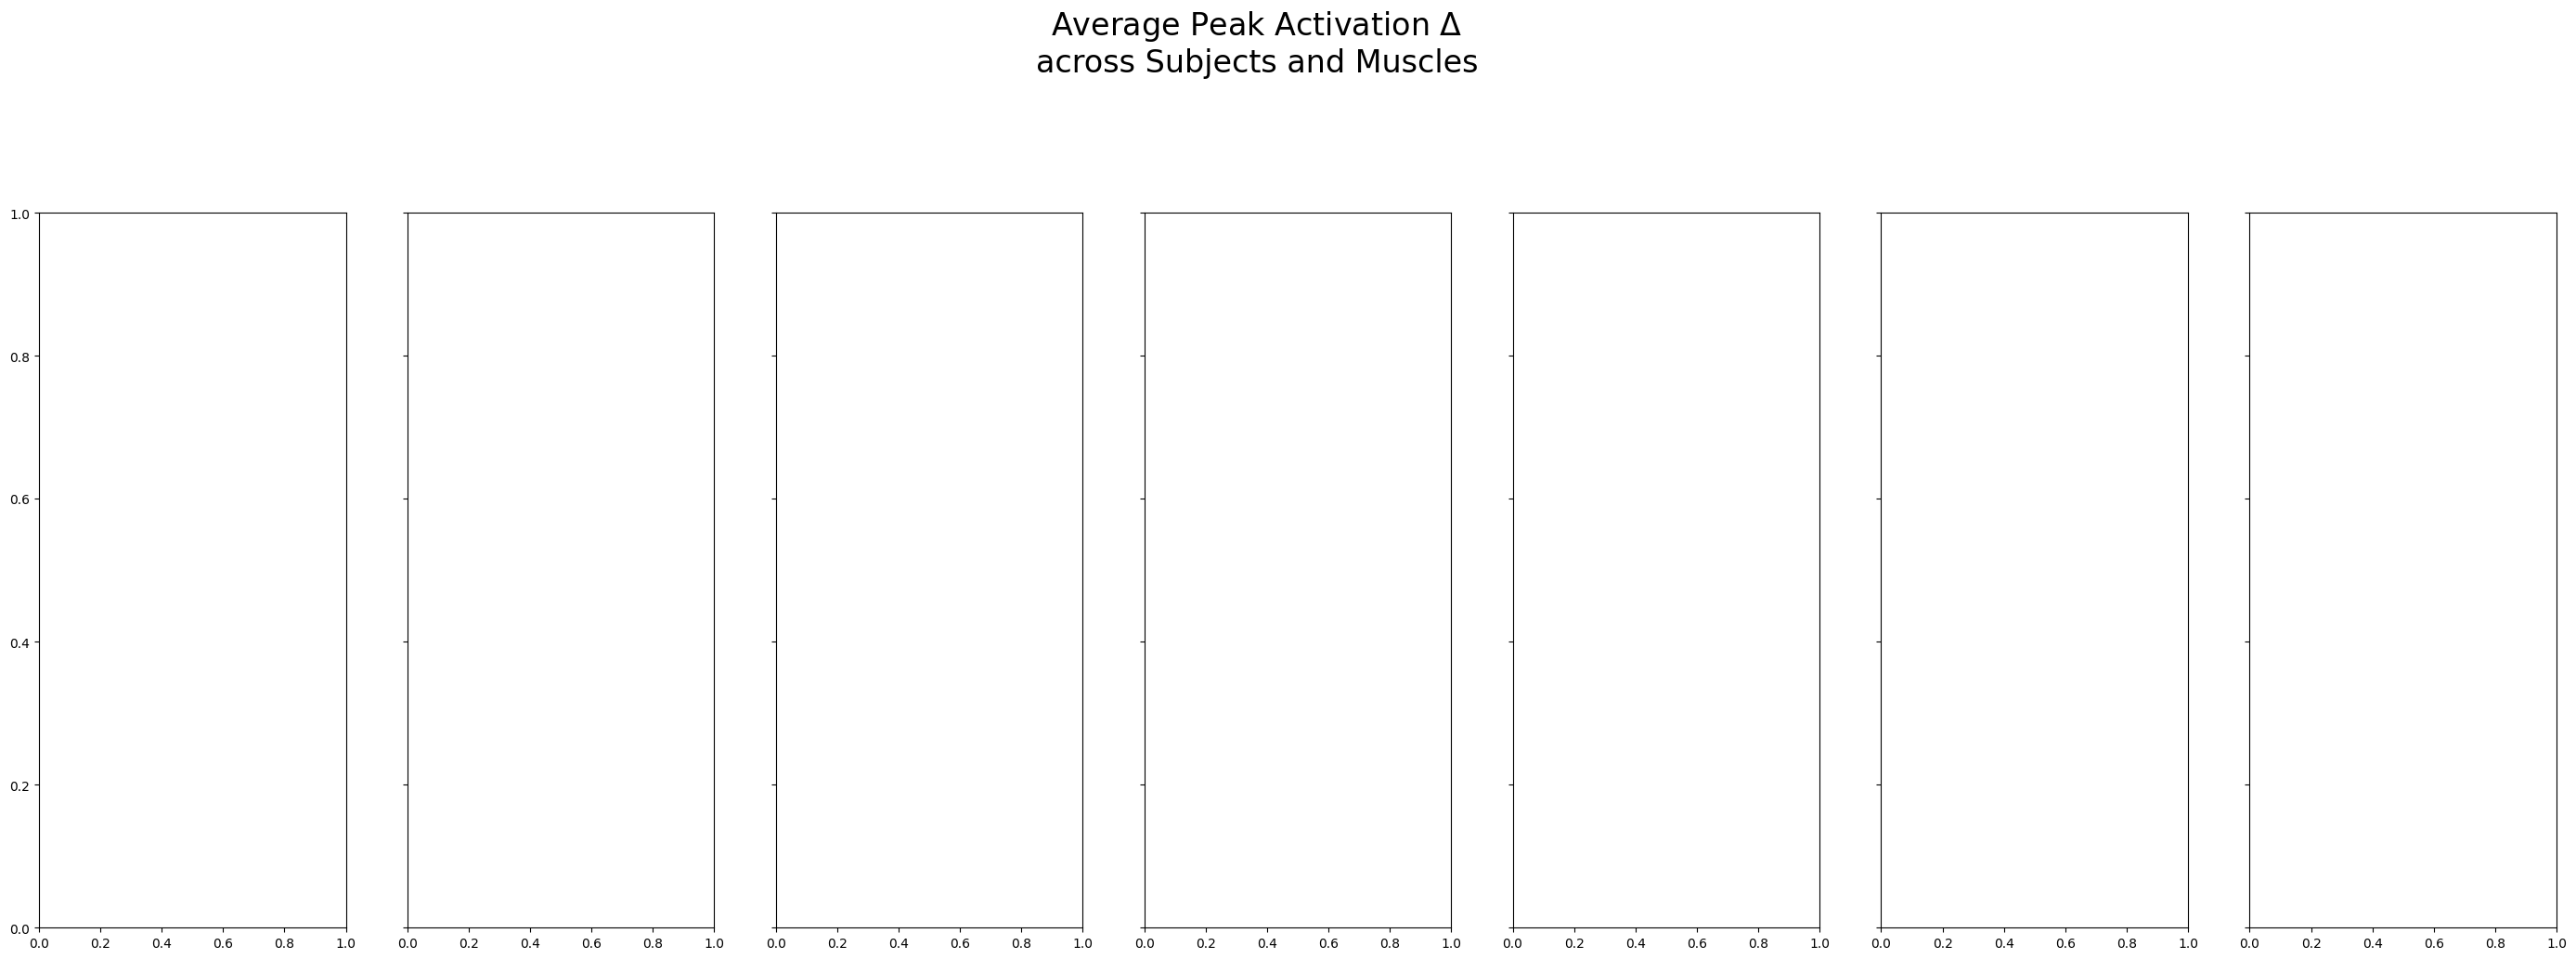

In [186]:
# Create a figure and axis for the plot
plot_dir = subject_dirs[subject][session]["plot_dir"]
filename = Path("../paper_figures") / f"average_peak_activation_delta_profile_subject.svg"

fig, ax = plt.subplots(1, n_profiles, figsize=(35, 10), sharey=True)
fig.suptitle("Average Peak Activation $\Delta$\nacross Subjects and Muscles", fontsize=24, y=1.1)

profiles = subject_data[subject][session]["session_data"]["ASSISTED"].keys()

for i, profile in enumerate(profiles):
    df_peak_deltas = df_all_deltas[df_all_deltas["Profile"] == profile].sort_values(by="Subject")

    # Drop rows where muscle == IMU or TIME
    df_peak_deltas = df_peak_deltas[df_peak_deltas["Muscle"] != "IMU"]
    df_peak_deltas = df_peak_deltas[df_peak_deltas["Muscle"] != "TIME"]

    # Plotting delta activations with consideration for missing data
    sns.barplot(x="Muscle", y="Mean Delta", hue="Subject", data=df_peak_deltas, ax=ax[i], dodge=True)

    # # Adding error bars for delta activations
    ax[i].set_xlabel("Muscles", fontsize=16)
    ax[i].tick_params(axis='x', labelrotation=45, labelsize=16)
    ax[i].tick_params(axis='y', labelsize=16)
    ax[i].set_ylabel("Peak Activation $\Delta$ (%)", fontsize=20)
    ax[i].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
    ax[i].set_title(profile, fontsize=24)
    ax[i].tick_params(labelleft=True)

    handles, labels = ax[i].get_legend_handles_labels()

    ax[i].get_legend().remove()

    
fig.legend(handles, labels, fontsize=20, ncols=len(handles), bbox_to_anchor=(0.56, 1.02))  
plt.tight_layout()
plt.savefig(filename, format='svg')
plt.savefig(filename.with_suffix('.png'), dpi=500, format='png', bbox_inches='tight')
plt.savefig(latex_figure_dir / "emg_plots" / filename.with_suffix('.png').name, dpi=500, format="png")
plt.show()

In [ ]:
fig, axs = plt.subplots(figsize=(15, 5))
fig.suptitle(f"Average PEAK muscle activation $\Delta$\nper subject and profile", fontsize=20, y=1.02)

df_all_deltas = pd.concat(all_deltas)

df_all_deltas.sort_values(by="Muscle", ascending=True, inplace=True)

In [185]:
# Create a figure and axis for the plot
plot_dir = subject_dirs[subject][session]["plot_dir"]
filename = Path("../paper_figures/") / f"peak_activation_deltas_per_subject.svg"

# Initialize a dictionary to store Mean Delta values for each profile across subjects
profile_deltas = {}

for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        mean_delta_activations = subject_data[subject][session]["peak_activation_deltas"]
        muscle_averages = mean_delta_activations[mean_delta_activations["Muscle"] == "Average"]

        # muscle_averages.loc[:, "Profile"] = list(profile_peaks.values())

        # Plotting each subject's data
        # axs.plot(muscle_averages["Profile"], muscle_averages["Mean Delta"], label=subject, marker='*', linewidth=3, markersize=10)
        
        # Accumulate Mean Delta values for averaging later
        for index, row in muscle_averages.iterrows():
            if row["Profile"] not in profile_deltas:
                profile_deltas[row["Profile"]] = []
            profile_deltas[row["Profile"]].append(row["Mean Delta"])

# Calculate and plot the average across subjects for each profile
average_deltas = {profile: np.mean(deltas) for profile, deltas in profile_deltas.items()}
profiles = subject_data[subject][session]["session_data"]["ASSISTED"].keys()
average_values = list(average_deltas.values())

# axs.set_xticks(list(profile_peaks.values()))

# axs.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
# axs.hlines(0, profile_peaks['peak_27%_62N'], profile_peaks['peak_77%_62N'], color='black', linestyle='--')
axs.set_xlabel("Peak Timing of Assistance (%)")
axs.set_ylabel("Peak Activation Delta\n(% of baseline peak)")
axs.set_ylim(-0.4, 0.4)
axs.legend(fontsize=16, title="Subjects", title_fontsize='16', loc='upper right')

# plt.savefig(filename, format='svg', bbox_inches='tight')
# plt.savefig(filename.with_suffix('.png'), dpi=500, format='png', bbox_inches='tight')
# plt.savefig(latex_figure_dir / "emg_plots" / filename.with_suffix('.png').name, dpi=500, format="png", bbox_inches='tight')
plt.show()

KeyError: 'peak_activation_deltas'

In [ ]:
assisted_average_activations = pd.concat([subject_data[subject][session]['averaged_activations']['ASSISTED'][profile]['EMG']['mean'] for profile in profile_infos.keys()], axis=1).T.mean()

In [ ]:
def label_bars(ax: plt.axes, bars: list, texts: list, orient: Literal['v', 'h'] = 'v'):
    for i, bar in enumerate(bars):
        if orient == 'v':
            # For vertical bars, position the label above the bar
            bar_height = bar.get_height()
            bar_x = bar.get_x()
            bar_width = bar.get_width()
            center = bar_x + bar_width / 2
            ax.text(center, bar_height, texts[i], ha='center', va='bottom', fontsize=14)
        else:
            # For horizontal bars, position the label to the right of the bar
            bar_width = bar.get_width()
            bar_y = bar.get_y()
            bar_height = bar.get_height()
            center = bar_y + bar_height / 2
            # Determine the horizontal alignment based on the sign of the bar width
            ha = 'left' if bar_width >= 0 else 'right'
            # Offset the text from the end of the bar by a fraction of the bar width
            offset = bar_width * 0.01 if bar_width >= 0 else bar_width * 0.01 - 0.02
            ax.text(bar_width + offset, center, texts[i], ha=ha, va='center', fontsize=14)


NameError: name 'df_all_means' is not defined

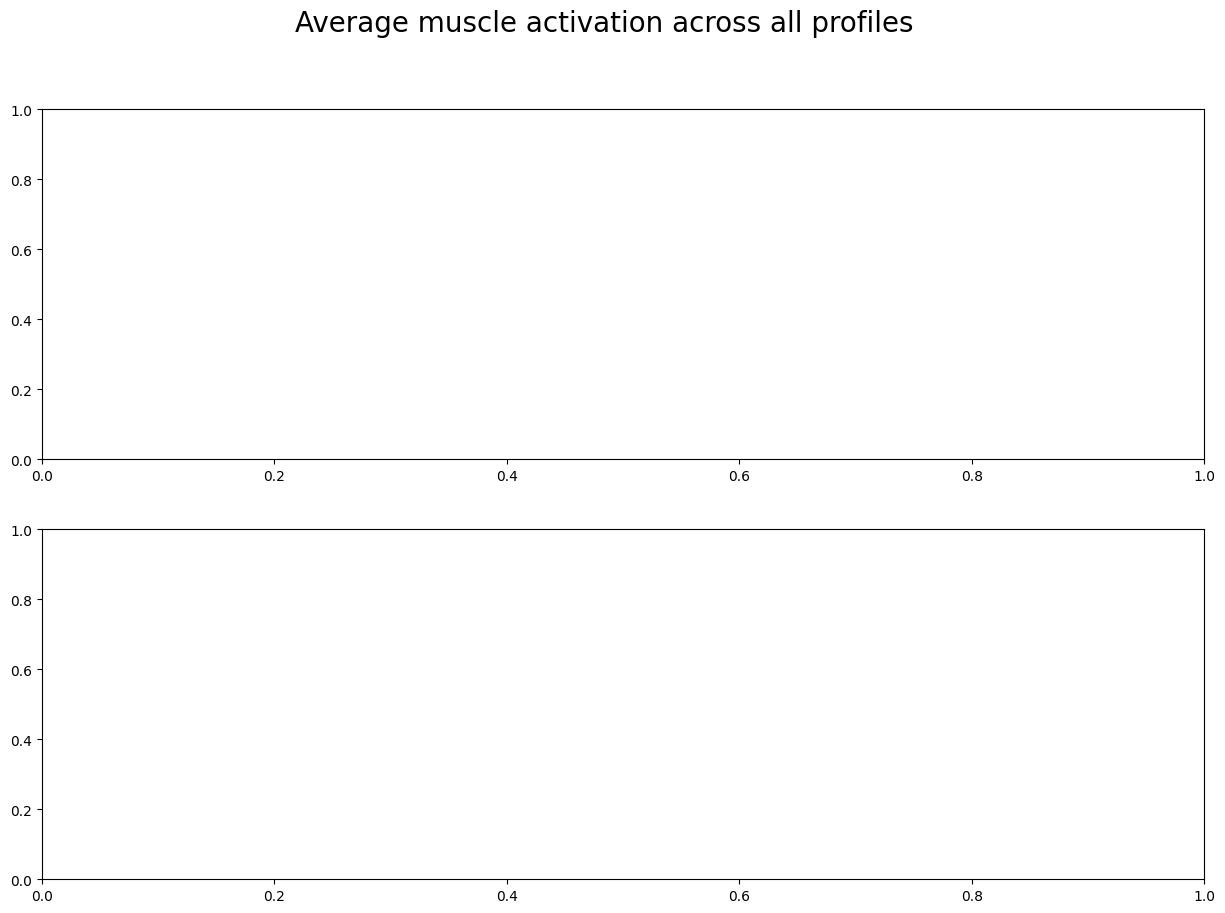

In [184]:
fig, ax = plt.subplots(2, figsize=(15, 10))
fig.suptitle("Average muscle activation across all profiles", fontsize=20)

for i, subject in enumerate(subject_data.keys()):
    subject_df = df_all_means[df_all_means["Subject"] == subject].drop(columns=["Subject", "Session"])
    baseline_df = subject_df[subject_df["Profile"] == "BASELINE"].drop(columns=["Profile"])

    # Remove time row from subject_df and baseline_df
    baseline_df = baseline_df[(baseline_df["Muscle"] != "TIME")]

    subject_df = subject_df[(subject_df["Profile"] != "BASELINE") & (subject_df["Muscle"] != "AVERAGE") & (subject_df["Profile"] != "TIME")]
    subject_df = subject_df.drop(columns='Profile').groupby('Muscle').mean().reset_index()
    subject_df['Group'] = 'Assisted'
    baseline_df['Group'] = 'Baseline'

    # Muscle activation averages by muscle and subject across profiles.
    muscle_avg_across_profiles = pd.concat([subject_df, baseline_df], ignore_index=True).sort_values(by="Group", ascending=False)
    # Remove time columns
    muscle_avg_across_profiles = muscle_avg_across_profiles[muscle_avg_across_profiles["Muscle"] != "TIME"]
    assisted_df = muscle_avg_across_profiles[muscle_avg_across_profiles["Group"] == "Assisted"].set_index("Muscle")
    baseline_df = muscle_avg_across_profiles[muscle_avg_across_profiles["Group"] == "Baseline"].set_index("Muscle")
    
    sns.barplot(x="Muscle", y="Mean Activation", data=muscle_avg_across_profiles, hue='Group', ax=ax[i])


    percentage_change = (assisted_df['Mean Activation'] - baseline_df['Mean Activation']) / baseline_df['Mean Activation']
    percentage_change = percentage_change.reset_index()
    percentage_change.columns = ["Muscle", "Activation Delta"]
    percentage_change = percentage_change.values[:, 1]

    percentage_change = [f"{val*100:.0f}%" for val in percentage_change]

    bars = ax[i].patches[:-2]

    baseline_bars = bars[:len(bars)//2]
    assisted_bars = bars[len(bars)//2:]

    label_bars(ax[i], baseline_bars, len(bars)//2 * ["0%"])
    label_bars(ax[i], assisted_bars, percentage_change)
    
    ax[0].set_ylim(0, 0.5)
    ax[1].set_ylim(0, 0.7)
    ax[i].legend().remove()
    ax[i].set_title(f"Subject {subject}")
    ax[i].set_ylabel("Average Muscle Activation (% of MVIC)")
    ax[i].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, symbol=None))
    handles, labels = ax[i].get_legend_handles_labels()

fig.legend(handles=handles, labels=labels, loc="upper right", fontsize=16, title="Condition", title_fontsize=16, bbox_to_anchor=(0.95, 1.02))
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
# plt.savefig("../paper_figures/assisted_vs_baseline_activation_change.svg", format='svg', bbox_inches='tight')
# plt.savefig("../paper_figures/assisted_vs_baseline_activation_change.png", dpi=500, format='png', bbox_inches='tight')
# plt.savefig(latex_figure_dir / "emg_plots" / "assisted_vs_baseline_activation_change.png", dpi=500, format="png", bbox_inches='tight')
plt.show()


NameError: name 'df_all_means' is not defined

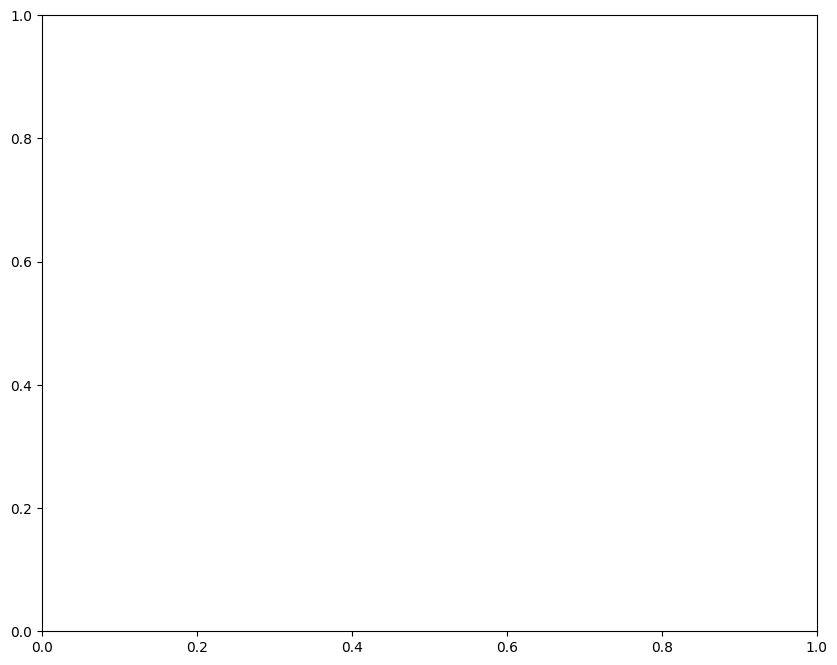

In [183]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import re
subject = "subject_Validation_22"
session = "February_11"

plot_dir = subject_dirs[subject][session]["plot_dir"]/"mean_delta_activations"
plot_dir.mkdir(parents=True, exist_ok=True)
filename = plot_dir / f"mean_delta_activations_all.svg"

# Initialize fig and ax for multiple subplots
fig, ax = plt.subplots(nrows=len(subject_data.keys()), ncols=1, figsize=(10, 8), squeeze=False)
ax = ax.flatten()  # Ensure ax is always an array for consistent indexing

# Custom sort key function to sort by base muscle name and then by "LEFT" or "RIGHT"
def muscle_sort_key(muscle):
    base_name = re.sub(r'_(LEFT|RIGHT)', '', muscle)  # Extract base name (e.g., "BF" from "BF_LEFT")
    side = '0' if 'LEFT' in muscle else '1'  # "LEFT" comes before "RIGHT"
    return (base_name, side)

for i, subject in enumerate(subject_data.keys()):
    subject_df = df_all_means[df_all_means["Subject"] == subject].drop(columns=["Subject", "Session"])
    baseline_df = subject_df[subject_df["Profile"] == "BASELINE"].drop(columns=["Profile"])

    # Remove any 'TIME' rows
    baseline_df = baseline_df[baseline_df["Muscle"] != "TIME"]
    subject_df = subject_df[(subject_df["Profile"] != "BASELINE") & (subject_df["Muscle"] != "AVERAGE") & (subject_df["Muscle"] != "TIME")]

    # Calculate averages for each muscle
    subject_df = subject_df.drop(columns='Profile').groupby('Muscle').mean().reset_index()
    subject_df['Group'] = 'Assisted'
    baseline_df['Group'] = 'Baseline'

    # Combine and sort by muscle pairs (LEFT and RIGHT) in desired order
    muscle_avg_across_profiles = pd.concat([subject_df, baseline_df], ignore_index=True)
    muscle_avg_across_profiles['SortKey'] = muscle_avg_across_profiles['Muscle'].apply(muscle_sort_key)
    muscle_avg_across_profiles = muscle_avg_across_profiles.sort_values(by=["SortKey", "Group"], ascending=[True, False]).drop(columns='SortKey')

    # Remove any remaining 'TIME' rows in combined DataFrame
    muscle_avg_across_profiles = muscle_avg_across_profiles[muscle_avg_across_profiles["Muscle"] != "TIME"]
    # remove TA_LEFT
    muscle_avg_across_profiles = muscle_avg_across_profiles[muscle_avg_across_profiles["Muscle"] != "TA_LEFT"]
    # remove SO_LEFT
    muscle_avg_across_profiles = muscle_avg_across_profiles[muscle_avg_across_profiles["Muscle"] != "SO_LEFT"]

    # Separate assisted and baseline groups for further processing
    assisted_df = muscle_avg_across_profiles[muscle_avg_across_profiles["Group"] == "Assisted"].set_index("Muscle")
    baseline_df = muscle_avg_across_profiles[muscle_avg_across_profiles["Group"] == "Baseline"].set_index("Muscle")

    # Plotting
    sns.barplot(x="Muscle", y="Mean Activation", data=muscle_avg_across_profiles, hue='Group', ax=ax[i])

    # Calculate percentage change and ensure alignment with Muscle order
    percentage_change_df = (assisted_df['Mean Activation'] - baseline_df['Mean Activation']) / baseline_df['Mean Activation']
    percentage_change_df = percentage_change_df.reset_index()
    percentage_change_df.columns = ["Muscle", "Activation Delta"]
    percentage_change_labels = [f"{val*100:.0f}%" for val in percentage_change_df["Activation Delta"]]

    # Get bars in correct muscle order (assumes order of bars matches plot data)
    bars = ax[i].patches
    num_muscles = len(percentage_change_labels)
    baseline_bars = bars[:num_muscles]   # Baseline group bars
    assisted_bars = bars[num_muscles:num_muscles * 2]  # Assisted group bars

    # Apply labels to each group separately, using correct alignment
    label_bars(ax[i], baseline_bars, ["0%"] * num_muscles)
    label_bars(ax[i], assisted_bars, percentage_change_labels)
    
    ax[i].set_ylim(0, 0.4 if i == 0 else 0.7)
    ax[i].legend().remove()
    ax[i].tick_params(axis='x', labelrotation=45, labelsize=12)
    ax[i].set_title(f"Subject {subject}")
    ax[i].set_ylabel("Average Muscle Activation (% of MVIC)")
    ax[i].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, symbol=None))
    handles, labels = ax[i].get_legend_handles_labels()

# Add a legend for all subplots
fig.legend(handles=handles, labels=labels, loc="upper right", fontsize=16, title="Condition", title_fontsize=16, bbox_to_anchor=(0.95, 1.02))
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.savefig(filename, format='svg', bbox_inches='tight')
plt.savefig(filename.with_suffix('.png'), dpi=500, format='png', bbox_inches='tight')

# Display the plot
plt.show()



In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), squeeze=False)  # Ensure axs is always 2D
fig.suptitle("Absolute Average Muscle Activation\nAssisted vs Baseline", fontsize=20)
plot_dir = subject_dirs[subject][session]["plot_dir"]
filename = plot_dir / f"assisted_vs_baseline_subjects.svg"

for i, subject in enumerate(subject_data.keys()):
    for session in subject_data[subject].keys():
        df = subject_data[subject][session]["absolute_mean_activations"]
        assisted_mean = df[df["Muscle"] == "AVERAGE"][["Mean Activation", "STD Activation"]].mean()
        baseline_mean = df[df["Profile"] == "BASELINE"][["Mean Activation", "STD Activation"]].mean()
        
        # Adjusted sns.barplot to plot horizontally
        sns.barplot(y=["Assisted", "Baseline"], 
                    x=[assisted_mean["Mean Activation"], baseline_mean["Mean Activation"]],
                    orient='h', ax=axs[0, i], palette=[u'#3f88c5', u'#d72638'], hue=["Assisted", "Baseline"])  # Note the swapped x and y parameters
        
        percentage_change = (assisted_mean['Mean Activation'] - baseline_mean['Mean Activation']) / baseline_mean['Mean Activation']
        print(percentage_change)

        label_bars(ax=axs[0, i], bars=axs[0, i].patches, texts=[f"{percentage_change*100:.0f}%", "0%"], orient='h')
        
        # Adjust title, labels, and tick parameters for horizontal orientation
        axs[0, i].set_title(f"Subject {subject}", fontsize=20)
        axs[0, i].set_ylabel("Condition", fontsize=16)  # Now y-axis is "Condition"
        axs[0, i].set_xlabel("Mean Activation\n(% of MVIC)", fontsize=16)  # x-axis shows Mean Activation
        
        axs[0, i].tick_params(axis='y', labelsize=14)  # Adjust y-tick labels for "Condition"
        axs[0, i].tick_params(axis='x', labelsize=14)  # Adjust x-tick labels for Mean Activation
        
        axs[0, i].set_xlim(0, 0.5)  # Adjust x-limits to fit the data
        axs[0, i].xaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, symbol=None, decimals=0))  # Apply percent formatter to x-axis

plt.tight_layout()
plt.savefig(filename, format='svg')
plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
plt.savefig(latex_figure_dir / "emg_plots" / filename.with_suffix('.png').name, dpi=500, format="png")
plt.show()